In [1]:
import math
import threading
import time
from multiprocessing import Process
from multiprocessing import Manager
from tensorboardX import SummaryWriter
import numpy as np
#global variable
doNormalization=True
useGpu=False
runOnG814=False
isTest=False
modelPath='/home/wangyuchen/wholeNet_300epoch_50perEpoch.pt'
maxMatrixIndex=250
runRelationLSTM=False
runObjectRelationNet=False
runSeq2SeqRelationModel=False
runLSTM=False
runDifferenceLSTMModel=True



maxRelationsNumberGlobal=20 # the maximum nubmer of relation in the "relation within the given range" version 

if useGpu:
    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [49]:
def fromAllToStr(*args):
    returnedStr=str()
    for eachItem in args:
        returnedStr=returnedStr+str(eachItem)
    return returnedStr

In [50]:
import logging
logging.basicConfig(filename='logging.txt',level=logging.DEBUG, format='%(asctime)s -%(lineno)d - %(funcName)s - %(levelname)s - %(message)s',)
console = logging.StreamHandler()
console.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s -%(lineno)d - %(funcName)s - %(levelname)s - %(message)s')
console.setFormatter(formatter)
logging.getLogger('').addHandler(console)

In [91]:
#generate a tuple in which each element is the index of a vehicle
#the tuple is used to get the property of each vehicle from the left side of data from the dataset function
listForEachVehicle=[]
for i in range(maxMatrixIndex):
    listForEachVehicle.append(i*(maxMatrixIndex-1))
tupleForEachVehicle=tuple(listForEachVehicle)

In [92]:
import numpy as np
import torch

def getValueByLable(lableList,valueList):
    """
    For instance, given a lable list ['Local_X','Local_Y'] and a value list [2.0, 24.0, 437.0, 1118846981300.0, 16.254, 
    79.349, 6451167.199, 1873312.382, 14.5, 4.9, 2.0, 39.14, -5.73, 2.0, 0.0, 13.0, 0.0, 0.0] which values sorted by the 
    order of allLableList below, the function return a value Dict {'Local_X':16.254, 'Local_Y':79.349}
    Args:
        lableList: the list of lables you've required, such as['Vehicle_ID', 'Total_Frames','Global_Time']
        valueList: the list contains all legally value, sorted by:['Vehicle_ID', 'Frame_ID','Total_Frames','Global_Time','Local_X','Local_Y','Global_X','Global_Y',\
                      'v_Length','v_Width','v_Class','v_Vel','v_Acc','Lane_ID','Preceding','Following','Space_Headway',\
                      'Time_Headway']
    Returns: 
        value dict of the input lables
    For instance, given a lable list ['Local_X','Local_Y'] and a value list [2.0, 24.0, 437.0, 1118846981300.0, 16.254, 
    79.349, 6451167.199, 1873312.382, 14.5, 4.9, 2.0, 39.14, -5.73, 2.0, 0.0, 13.0, 0.0, 0.0] which values sorted by the 
    order of allLableList above, the function return a value List [16.254, 79.349]

    """
    allLableList=['Vehicle_ID', 'Frame_ID','Total_Frames','Global_Time','Local_X','Local_Y','Global_X','Global_Y',\
                  'v_Length','v_Width','v_Class','v_Vel','v_Acc','Lane_ID','Preceding','Following','Space_Headway',\
                  'Time_Headway']
    valueDictReturn={}
    for lableItem in lableList:
        valueDictReturn[lableItem]=valueList[allLableList.index(lableItem)]
    return valueDictReturn

def rearrangeDataByGlobalTime(allValueLists):
    '''
    Args:
        allValueLists: all values have been read from a txt file which have already been converted to a list
    Returns:
        dict have been arranged by global time. One single global time generally contains several value lists.
    '''
    valueDict={}
    for valueList in allValueLists:
        dictKey=getValueByLable(['Global_Time'],valueList)['Global_Time']
        if dictKey in valueDict:
            # if dictKey already there, then add valueList to the list of the key
            valueDict[dictKey].append(valueList)
        else:
            #else, create a list and append valueList on it
            valueDict[dictKey]=[valueList]
    return valueDict

In [93]:
import copy

def readFirstFrame(matrixIndexAndVehicleIDRecordDictParam, valueLists):
    """
    To generate the first set of tensors from the first frame
    Args:
        matrixIndexAndVehicleIDRecordDictParam: just as its name
        valueLists: a list consists of all valuelist at one time
    Returns:
        several tensors arranged by: positionTensor, speedTensor, accTensor, angleTensor,newVehicleList(type:list)
    
    """
    maxMatrixIndex=matrixIndexAndVehicleIDRecordDictParam.keys().__len__()-1
    #tensors initialize
    positionTensor=torch.zeros(2,maxMatrixIndex)
    speedTensor=torch.zeros(1,maxMatrixIndex)
    accTensor=torch.zeros(1,maxMatrixIndex)
    angleTensor=torch.zeros(1,maxMatrixIndex)
    newVehicleIDList=[]
    curMatrixIndex=0
    matrixIndexAndVehicleIDRecordDictParam['time']=getValueByLable(["Global_Time"],valueLists[0])['Global_Time']
    #fill out all tensors
    for eachValueList in valueLists:
        #get values from eachValueList, generate dict
        returnedEachValueDict=getValueByLable(['Vehicle_ID','Local_X','Local_Y','v_Vel','v_Acc'],eachValueList)
        #assign to the curMatrixIndex-th row of corresponding tensor
        #angle Tensor assignment is not neeed for the initial value of each element in it is already zero
        positionTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['Local_X'],returnedEachValueDict['Local_Y']))
        speedTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['v_Vel']))
        accTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['v_Acc']))
        #then handle the record matrix
        matrixIndexAndVehicleIDRecordDictParam[curMatrixIndex]['Vehicle_ID']=returnedEachValueDict['Vehicle_ID']
        matrixIndexAndVehicleIDRecordDictParam[curMatrixIndex]['refresh']=0
        newVehicleIDList.append(copy.deepcopy(returnedEachValueDict['Vehicle_ID']))
        curMatrixIndex=curMatrixIndex+1
    return positionTensor,speedTensor,accTensor,angleTensor,newVehicleIDList

In [94]:
def findMatrixIndexByVehicleID(matrixIndexAndVehicleIDRecordDictParam, vehicle_ID):
    for i in range(0, len(matrixIndexAndVehicleIDRecordDictParam)-1):
        if matrixIndexAndVehicleIDRecordDictParam[i]['Vehicle_ID']==vehicle_ID:
            return i
    return -1

def findEmptyMatrixIndex(matrixIndexAndVehicleIDRecordDictParam):
    for i in range(0, len(matrixIndexAndVehicleIDRecordDictParam)-1):
        if matrixIndexAndVehicleIDRecordDictParam[i]['Vehicle_ID']==-1:
            #Vehicle_ID=-1 when there is no existed vehicle ID bounding to the index
            return i
    raise Exception("NO EMPTY ELEMENT IN MATRIX")

def readGeneralFrame(matrixIndexAndVehicleIDRecordDictParam, valueLists, prePositionTensor):
    """
    To generate the first set of tensors from the general frame that have a preceding one.
    In this version, we ignore the new vehicle appeared among a serial of frame.
    Args:
        matrixIndexAndVehicleIDRecordDictParam: just as its name
        valueLists: a list consists of all valuelist at one time
        prePositionTensor: positionTensor from the preceding frame, which is used to calculate angle tensor
    Returns:
        everal tensors arranged by: positionTensor, speedTensor, accTensor, angleTensor,newVehicleList(type:list),
        vanishedVehicleList(type:list)
    
    """
    #tensors initialize
    maxMatrixIndex=matrixIndexAndVehicleIDRecordDictParam.keys().__len__()-1
    positionTensor=torch.zeros(2,maxMatrixIndex)
    speedTensor=torch.zeros(1,maxMatrixIndex)
    accTensor=torch.zeros(1,maxMatrixIndex)
    angleTensor=torch.zeros(1,maxMatrixIndex)
    newVehicleIDList=[]
    vanishedVehicleList=[]
    curMatrixIndex=0
    matrixIndexAndVehicleIDRecordDictParam['time']=getValueByLable(["Global_Time"],valueLists[0])['Global_Time']
    #fill out all tensors
    for eachValueList in valueLists:
        #get values from eachValueList, generate dict
        returnedEachValueDict=getValueByLable(['Vehicle_ID','Local_X','Local_Y','v_Vel','v_Acc'],eachValueList)
        indexOfVehicle=findMatrixIndexByVehicleID(matrixIndexAndVehicleIDRecordDictParam,returnedEachValueDict['Vehicle_ID'])
        if indexOfVehicle!=-1:
        #if index exist then the vehicle already existed in the preceded frame
            matrixIndexAndVehicleIDRecordDictParam[indexOfVehicle]['refresh']=1
            curMatrixIndex=indexOfVehicle
            #assign to the curMatrixIndex-th row of corresponding tensor
            positionTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['Local_X'],returnedEachValueDict['Local_Y']))
            speedTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['v_Vel']))
            accTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['v_Acc']))
            angleTensor[:,curMatrixIndex]=math.atan2(positionTensor[0,curMatrixIndex]-\
                                                     prePositionTensor[0,curMatrixIndex],\
                                                    positionTensor[1,curMatrixIndex]-prePositionTensor[1,curMatrixIndex])
        else:
            pass #ignore new vehicleID
        #a new vehicle ID
#             newVehicleIDList.append(copy.deepcopy(returnedEachValueDict['Vehicle_ID']))
#             curMatrixIndex=findEmptyMatrixIndex(matrixIndexAndVehicleIDRecordDictParam)
#             matrixIndexAndVehicleIDRecordDictParam[curMatrixIndex]['Vehicle_ID']=copy.deepcopy(returnedEachValueDict['Vehicle_ID'])
#             matrixIndexAndVehicleIDRecordDictParam[curMatrixIndex]['refresh']=1
#             #assign to the curMatrixIndex-th row of corresponding tensor
#             positionTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['Local_X'],returnedEachValueDict['Local_Y']))
#             speedTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['v_Vel']))
#             accTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['v_Acc']))
#             angleTensor[:,curMatrixIndex]=math.atan2(positionTensor[0,curMatrixIndex]-\
#                                                      prePositionTensor[0,curMatrixIndex],\
#                                                     positionTensor[1,curMatrixIndex]-prePositionTensor[1,curMatrixIndex])
    for i in range(0,maxMatrixIndex):
    #find vanished vehicle and remove from dict
        if matrixIndexAndVehicleIDRecordDictParam[i]['refresh']==0:
            #if refresh=0 then the corresponding vehicle ID was not found in this frame
            vanishedVehicleList.append(copy.deepcopy(matrixIndexAndVehicleIDRecordDictParam[i]['Vehicle_ID']))
            matrixIndexAndVehicleIDRecordDictParam[i]['refresh']=-1
            matrixIndexAndVehicleIDRecordDictParam[i]['Vehicle_ID']=-1
    
    for i in range(0,maxMatrixIndex):
    #set all refrshed which equivalent to 1 to 0 to prepare for the next frame
        if matrixIndexAndVehicleIDRecordDictParam[i]['refresh']==1:
                #if refresh=0 then the corresponding vehicle ID was not found in this frame
                matrixIndexAndVehicleIDRecordDictParam[i]['refresh']=0

    return positionTensor,speedTensor,accTensor,angleTensor,newVehicleIDList,vanishedVehicleList


In [95]:
import torch.utils.data as utils
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
if not runOnG814:
    %matplotlib inline 

2020-09-20 22:08:53,343 -225 - switch_backend - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2020-09-20 22:08:53,343 -225 - switch_backend - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [96]:
def fromDirGenerateDict(trajectoryDir):
    """
    Returns:
        valueDict: the key is global time, and the value of each key contain SEVERAL LIST of properties, 
                   each list consist of all property of a single vehicle at one time.
    """
    trajectoryDataFile=open(trajectoryDir)
    count=0
    allLineList=[]
    count=0
    for count,line in enumerate(trajectoryDataFile):
        #read a single line, remove space and enter
        lineList=line.split(' ')
        try:
            while True:
                lineList.remove('')
        except:
            try:
                lineList.remove('\n')
            except:
                pass
            pass
        for i in range(0,lineList.__len__()):
            # convert string to float
            lineList[i]=float(lineList[i])
        allLineList.append(lineList)
    valueDict=rearrangeDataByGlobalTime(allLineList)
    return valueDict

In [97]:
def getMaxAndMinValueFromValueDict(valueDict,lableList):
    """
    Args:
        valueDict: each key in dict is global time, the value of each key is a list of all value at one time
        lableList: lables from which you want to get the max and min value. the type of each value in the list 
                    is str.
    Returns:
        a dict, which has keys keys from the input lable list and the value of each key is a dict which formed
        as 'max':value, 'min':value
    """
    maxAndMinDict={}
    keys=list(valueDict.keys())
    for lable in lableList:
        max=0
        min=0 #speed,  positon are all from 0 to max, accelerate from - to +
        for eachKey in keys:
            valueLists=valueDict[eachKey]
            for valueList in valueLists:
                value=getValueByLable([lable],valueList)[lable]
                if value>max:
                    max=value
                if value<min:
                    min=value
        maxAndMinDict[lable]={'max':max,'min':min}
    return maxAndMinDict

In [98]:
# #test function of finding the max and min value: block 1, get valueDict for saving time from file reaidng
# valueDict=fromDirGenerateDict(1)


In [99]:
#test function of finding the max and min value: block 1, get valueDict for saving time from file reaidng
# getMaxAndMinValueFromValueDict(valueDict,['Local_X','Local_Y','v_Acc','v_Vel'])

In [100]:
# valueDict=fromDirGenerateDict(1)
# theKey=list(valueDict.keys())[1000]

In [101]:
def visualizeTensorData(xTensor,yTensor, maxLength=2500,maxWidth=100,blocksize=10,normalizationDict=False):
    """
    visualize a frame on an white image
    Args:
        valueVisualize: a list of values, each item in the list can be obtained by function 
        getValueByLable
    Returns:
        the image of the input frame
    """
    image=np.ones((maxLength,maxWidth,3),dtype=np.int8)
    #set background to white
    image=image*255
#     figure=plt.figure(figsize=(10,50))
#     axe=figure.add_subplot(1,1,1)
    xLength=xTensor.shape[0] #the length of y is equivalent to x's
#     print('length:',xLength)
#     print('xTensor.shape',xTensor.shape)
    if doNormalization&(normalizationDict is not False):
        originalXTensor=torch.zeros(xLength)
        originalYTensor=torch.zeros(xLength) #originalX and Y tensor share the same length
        originalXTensor=torch.add(\
                                  torch.mul(xTensor,normalizationDict['positionXMax']-normalizationDict['positionXMin']),\
                                  torch.add(originalXTensor,normalizationDict['positionXMin'])
                                 )
        originalYTensor=torch.add(\
                                  torch.mul(yTensor,normalizationDict['positionYMax']-normalizationDict['positionYMin']),\
                                  torch.add(originalYTensor,normalizationDict['positionYMin'])
                                 )
        for i in range(xLength):
            x=int(originalXTensor[i])
            y=int(originalYTensor[i])
            colorR=int((i*17+29)%255)
            colorG=int((i*9++93)%255)
            colorB=int((i*13+111)%255)
            cv2.circle(image,(x,y),int(blocksize/2),(colorB,colorG,colorR),-1) #
    #     axe.imshow(image)
        return image
        
    
    
    for i in range(xLength):
        x=int(xTensor[i])
        y=int(yTensor[i])
        colorR=int((i*17+29)%255)
        colorG=int((i*9++93)%255)
        colorB=int((i*13+111)%255)
        cv2.circle(image,(x,y),int(blocksize/2),(colorB,colorG,colorR),-1) #
#     axe.imshow(image)
    return image

In [102]:
def visualizeTrajectory(inputTensor, maxLength=2500, maxWidth=100,radius=5,thickness=2,normalizationDict=None, vehicleList=None):
    """
    to visualize the trajectory of all or selected vehicles
    Args:
        inputTensor: Tensor to be visualized. The dimension of the tensor is supposed to be (batch, timestep, vehicles, properties)
        vehicleList: If vehicleList is not none, visualize all vehicles; if not, then only visualize vehicles of the given number.
    Returns:
        imageList: the visualized results.
    """
    imageList=[]
    for image_i in range(inputTensor.shape[0]):
        # set the horizontal image
        image=np.ones((maxWidth,maxLength,3),dtype=np.int8)
        #set background to white
        image=image*255
        imageList.append(image)
    
    if doNormalization&(normalizationDict is not False):
        newInputTensor=torch.zeros(inputTensor.shape)
        #To compute de-normalized x tensors
        newInputTensor[:,:,:,0]=torch.add(\
                                  torch.mul(inputTensor[:,:,:,0],normalizationDict['positionXMax']-normalizationDict['positionXMin']),\
                                  normalizationDict['positionXMin']
                                 )
        newInputTensor[:,:,:,1]=torch.add(\
                                  torch.mul(inputTensor[:,:,:,1],normalizationDict['positionYMax']-normalizationDict['positionYMin']),\
                                  normalizationDict['positionYMin']
                                 )
        inputTensor=newInputTensor
        
    if vehicleList is None:
        #vehicleList is none then visualize all vehicle
        vehicleList=list(range(inputTensor.shape[2]))
        
    for batch_I in range(inputTensor.shape[0]):
        for timestep_I in range(inputTensor.shape[1]):
            for vehicle_I in vehicleList:
                currentX=inputTensor[batch_I,timestep_I,vehicle_I,0]
                currentY=inputTensor[batch_I,timestep_I,vehicle_I,1]
                colorR=int((vehicle_I*17+29)%255)
                colorG=int((vehicle_I*9++93)%255)
                colorB=int((vehicle_I*13+111)%255)
                cv2.circle(imageList[batch_I],(currentY,currentX),radius,(colorB,colorG,colorR),-1)
                if timestep_I==0:
                    continue
                else:
                    preX=inputTensor[batch_I,timestep_I-1,vehicle_I,0]
                    preY=inputTensor[batch_I,timestep_I-1,vehicle_I,1]
                    cv2.line(imageList[batch_I],(preY,preX),(currentY,currentX),(colorB, colorG, colorR),thickness=thickness)
    return imageList  
    

In [103]:
test=list(range(20))
print(test)
print(test[15])
print(type(test))

test=None
if test is None:
    print(12983721908371293)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
15
<class 'list'>
12983721908371293


In [104]:
def visualizeTensorDataHorizontal(xTensor,yTensor, maxLength=2500,maxWidth=100,blocksize=10,normalizationDict=False):
    """
    visualize a frame on an white image
    Args:
        valueVisualize: a list of values, each item in the list can be obtained by function 
        getValueByLable
    Returns:
        the image of the input frame
    """
    image=np.ones((maxWidth,maxLength,3),dtype=np.int8)
    #set background to white
    image=image*255
#     figure=plt.figure(figsize=(10,50))
#     axe=figure.add_subplot(1,1,1)
    xLength=xTensor.shape[0] #the length of y is equivalent to x's
#     print('length:',xLength)
#     print('xTensor.shape',xTensor.shape)
    if doNormalization&(normalizationDict is not False):
        originalXTensor=torch.zeros(xLength)
        originalYTensor=torch.zeros(xLength) #originalX and Y tensor share the same length
        originalXTensor=torch.add(\
                                  torch.mul(xTensor,normalizationDict['positionXMax']-normalizationDict['positionXMin']),\
                                  torch.add(originalXTensor,normalizationDict['positionXMin'])
                                 )
        originalYTensor=torch.add(\
                                  torch.mul(yTensor,normalizationDict['positionYMax']-normalizationDict['positionYMin']),\
                                  torch.add(originalYTensor,normalizationDict['positionYMin'])
                                 )
        for i in range(xLength):
            x=int(originalXTensor[i])
            y=int(originalYTensor[i])
            colorR=int((i*17+29)%255)
            colorG=int((i*9++93)%255)
            colorB=int((i*13+111)%255)
            cv2.circle(image,(y,x),int(blocksize/2),(colorB,colorG,colorR),-1) #
    #     axe.imshow(image)
        return image
        
    
    
    for i in range(xLength):
        x=int(xTensor[i])
        y=int(yTensor[i])
        colorR=int((i*17+29)%255)
        colorG=int((i*9++93)%255)
        colorB=int((i*13+111)%255)
        cv2.circle(image,(y,x),int(blocksize/2),(colorB,colorG,colorR),-1) #
#     axe.imshow(image)
    return image

In [105]:
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
if not runOnG814:
    %matplotlib inline
from IPython import display
def visualizeData(valueVisualize, maxLength=1000,maxWidth=100,blocksize=10):
    """
    visualize a frame on an white image
    Args:
        valueVisualize: a list of values, each item in the list can be obtained by function 
        getValueByLable
    Returns:
        the image of the input frame
    """
    image=np.ones((maxLength,maxWidth,3),dtype=np.int8)
    image=image*255
#     figure=plt.figure(figsize=(10,50))
#     axe=figure.add_subplot(1,1,1)
    
    for item in valueVisualize:
        infoList=getValueByLable(['Vehicle_ID','Local_X','Local_Y'],item)
        vehicleID=infoList['Vehicle_ID']
        x=int(infoList['Local_X'])
        y=int(infoList['Local_Y'])
        colorR=int((vehicleID+100)%255)
        colorG=int((vehicleID+150)%255)
        colorB=int((vehicleID+200)%255)
        cv2.circle(image,(x,y),int(blocksize/2),(colorB,colorG,colorR),-1) #
#     axe.imshow(image)
    return image
# visualizeData(valueDict[theKey])




2020-09-20 22:08:53,426 -225 - switch_backend - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2020-09-20 22:08:53,426 -225 - switch_backend - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [106]:
def numericalEvaluation(resultTensor,labelTensor,normalizedDict=None,maxMatrixIndex=maxMatrixIndex):
    """
    numericla evalution for models
    REMOVE VELOCITY AND ACCELERATE FROM THE INPUT TENSOR IF THEY EXISTS IN THE INPUT TENSORS!!!
    Args:
        resultTensor: the predicted tensor of model, which dimension is (batch, timestep, vehicles, properties)
        labelTensor: the label tensor from dataset, which dimension is (batch, timestep, vehicles, properties)
        normalizedDict: the dict of normalization
    Returns:
        differenceEachVehicleEachFrame: the difference of each vehicle in each single frame
        differenceEachVehicleAllFrame: the difference of each vehicle in all frame
        averageDifferenceAllVehicleEachFrame: the average difference of all vehicle in each singel frame
        averageDifferenceAllVehicleAllFrame: the average difference of all vehicle in over all frame
    """
    differenceEachVehicleEachFrame=torch.abs(resultTensor-labelTensor)
    differenceEachVehicleAllFrame=torch.sum(differenceEachVehicleEachFrame,dim=1,keepdim=True)
    averageDifferenceAllVehicleEachFrame=torch.sum(differenceEachVehicleEachFrame,dim=2, keepdim=True)
    averageDifferenceAllVehicleEachFrame=torch.div(averageDifferenceAllVehicleEachFrame,resultTensor.shape[2])
    averageDifferenceAllVehicleAllFrame=torch.sum(averageDifferenceAllVehicleEachFrame,dim=1,keepdim=True)
    return differenceEachVehicleEachFrame,differenceEachVehicleAllFrame,averageDifferenceAllVehicleEachFrame,\
            averageDifferenceAllVehicleAllFrame
    
    
    

In [107]:
def discountParameterByExponentialWithDistance(relationTensors, xfactor=1, yfactor=1, w1=1,w2=2,w3=1):
    """
    to calculate a discount parameter matrix from the relations matrix of several vehicl pairs.
    Args:
        relationTensors: a vehicle pair is a "relation" in which two vehilce properties are of the same kind and order,
        the relationTensors consists of many vehicle pairs. An extra dimension should be added to the a single vehicle pair
        tensor if this function only take as a single vehicle pair. Generally, the relationTensors has to dimension:
        the dimension of pairs, the properties of each pair.
        xfactor,yfactor:  the weight of x part and y part
        w1, w2,w3: facor in exponential operation, w1 and w2 relate to x and w3 relate to y
    """
    vehiclePairDimension=relationTensors.shape[1] #the second dimension of relationTensors is the properties of each vehicle pair
    relationsDimension=relationTensors.shape[0]
    computationTensor=torch.zeros((relationsDimension,5)) #save the xDifference and yDifference for further computation
    secondVehiclePropertyStartIndex=int((vehiclePairDimension)/2 )
    logging.debug('secondVehiclePropertyStartIndex'+str(secondVehiclePropertyStartIndex))
    
    discountTensor=torch.zeros(relationsDimension)
    for i in range(relationsDimension):
        x1,y1,x2,y2=relationTensors[i][0],relationTensors[i][1],\
                    relationTensors[i][secondVehiclePropertyStartIndex],relationTensors[i][secondVehiclePropertyStartIndex+1]
        if y2>=y1: #the second vehilce is in front of the first vehicle
            yDifference=y2-y1
            wy=w1
        else: #the second vehicle is after the fist vehicle
            yDifference=y1-y2
            wy=w2
        xDifference=abs(x1-x2)
        wx=w3
        computationTensor[i][0]=xDifference
        computationTensor[i][1]=yDifference
        computationTensor[i][2]=wx
        computationTensor[i][3]=wy
        if (x1==0 and y1==0)or(x2==0 and y2==0):
            computationTensor[i][4]=0
        else:
            computationTensor[i][4]=1
#         discountTensor[i]=(xfactor/math.exp(wx*(xDifference)))*(yfactor/math.exp(wx*(yDifference)))
    logging.debug(fromAllToStr('computationTensor:\n',computationTensor))
    discountTensor=torch.mul(torch.mul((xfactor/torch.exp(torch.mul(computationTensor[:,0],computationTensor[:,2]))),\
                             (yfactor/torch.exp(torch.mul(computationTensor[:,1],computationTensor[:,3])))),
                             computationTensor[:,4])
    return discountTensor
    

In [108]:
def discountParameterByExponentialWithDistance(relationTensors, xfactor=1, yfactor=1, w1=1,w2=2,w3=1,isInModel=False):
    """
    to calculate a discount parameter matrix from the relations matrix of several vehicl pairs.
    This function is employed in model, especially for situation when cuda is used.
    Args:
        relationTensors: a vehicle pair is a "relation" in which two vehilce properties are of the same kind and order,
        the relationTensors consists of many vehicle pairs. An extra dimension should be added to the a single vehicle pair
        tensor if this function only take as a single vehicle pair. Generally, the relationTensors has to dimension:
        the dimension of pairs, the properties of each pair.
        xfactor,yfactor:  the weight of x part and y part
        w1, w2,w3: facor in exponential operation, w1 and w2 relate to x and w3 relate to y
    """
    vehiclePairDimension=relationTensors.shape[1] #the second dimension of relationTensors is the properties of each vehicle pair
    relationsDimension=relationTensors.shape[0]
    computationTensor=torch.zeros((relationsDimension,5)) #save the xDifference and yDifference for further computation
    if isInModel:
        if useGpu:
            computationTensor=Variable(computationTensor.cuda())
    secondVehiclePropertyStartIndex=int((vehiclePairDimension)/2)
    logging.debug('secondVehiclePropertyStartIndex'+str(secondVehiclePropertyStartIndex))
    discountTensor=torch.zeros(relationsDimension)
    if isInModel:
        if useGpu:
            discountTensor=Variable(discountTensor.cuda())
    for i in range(relationsDimension):
        x1,y1,x2,y2=relationTensors[i][0],relationTensors[i][1],\
                    relationTensors[i][secondVehiclePropertyStartIndex],relationTensors[i][secondVehiclePropertyStartIndex+1]
        if y2>=y1: #the second vehilce is in front of the first vehicle
            yDifference=y2-y1
            wy=w1
        else: #the second vehicle is after the fist vehicle
            yDifference=y1-y2
            wy=w2
        xDifference=abs(x1-x2)
        wx=w3
        computationTensor[i][0]=xDifference
        computationTensor[i][1]=yDifference
        computationTensor[i][2]=wx
        computationTensor[i][3]=wy
        if (x1==0 and y1==0)or(x2==0 and y2==0):
            computationTensor[i][4]=0
        else:
            computationTensor[i][4]=1
#         discountTensor[i]=(xfactor/math.exp(wx*(xDifference)))*(yfactor/math.exp(wx*(yDifference)))
    discountTensor=torch.mul(torch.mul((xfactor/torch.exp(torch.mul(computationTensor[:,0],computationTensor[:,2]))),\
                             (yfactor/torch.exp(torch.mul(computationTensor[:,1],computationTensor[:,3])))),
                             computationTensor[:,4])
    
    return discountTensor
    

In [109]:
#input: property tensors, target vehicle ID
#output: relations, distances between target vehicle and other vehicles which inside the range
def relationCalculateWithRange(propertyTensors, distanceRange, targetVehicleId, maxRelationsNumber=maxRelationsNumberGlobal, isInModel=False,\
                              customMaxMatrixIndex=maxMatrixIndex,preSubRelationPairs=None,isReturnRelationPairs=False):
    """
    NOTICE:THE PROPERTIES AND DISTANCE RANGE SHOULD BOTH BE NORMALIZED OR UNNORMALIZED!!
    Args:
        propertyTensors:property tensors of all vehicles, at position 0 and 1 are the x and y positon of the 
        corresponding vehicle
        distanceRange: the distance on which we decide to take other vehicles into account
        targetVehicleId: the center vehicle which we are going to calculate
        isInModel: True when this function is employed in neural network model.
        customMaxMatrixIndex: the maximum number of matrix index
        preSubRelationPairs: which dimension is (vehiclepairs), such as (0,2,5), if the max relation number is 3,
        and the given vehicle has relation with vehicles which ID is 0,2,5. The operating speed of this function
        would be rising over 40 times with when this variable is provided.
    """
    
    propertyTensorsCopy=copy.deepcopy(propertyTensors)
    #add zero tensor to vehicle for adding tensors that less than maxRelationsNumber
    propertiesDimension=propertyTensorsCopy.shape[0]
    propertyTensorsCopy=torch.cat((propertyTensorsCopy,torch.zeros(propertyTensorsCopy.shape[1]).unsqueeze(0)),0)
    reservedIndexes=[]
    reservedIndexDistanceDict={}
    timeCostInDistanceComputation=0
    timeCostInRelationConcatanation=0
    reservedIndexes=list(range(0,customMaxMatrixIndex))
#     for i in range(customMaxMatrixIndex):
#         reservedIndexes.append(i)
    #remove vehicles which position are out-of-range
    distanceComputationStartTime=time.time()
    #get a reserved vehicle dict in this block, but generate the preSubRelationPairs in the next block
    if preSubRelationPairs is None:
        for i in range(propertiesDimension):
            #simply remove the out-of-ranged vehicles by comparing y-axis before computing the distance.
            #since most vehicles are out of the given range, such operation would reduce time cost
            if abs(propertyTensorsCopy[i][1]-propertyTensors[targetVehicleId][1])>distanceRange:
                reservedIndexes.remove(i)
            #to compute if vehicle in the range
            else:
                distance=((propertyTensorsCopy[i][0]-propertyTensors[targetVehicleId][0])**2+\
                    (propertyTensorsCopy[i][1]-propertyTensors[targetVehicleId][1])**2)**0.5
                if distance>distanceRange:
                    reservedIndexes.remove(i)
                else:
                    reservedIndexDistanceDict[i]=distance
        #sort dict by value, not by key
        sortedReservedIndexDistanceDict=sorted(reservedIndexDistanceDict.items(),key=lambda item:(item[1],item[0]))
        #keep the top 'maxRelationsNumber' nearest vehicles in the generated relations
        if(sortedReservedIndexDistanceDict.__len__()>maxRelationsNumber):
            for i in range(maxRelationsNumber,sortedReservedIndexDistanceDict.__len__()):
                reservedIndexes.remove(sortedReservedIndexDistanceDict[i][0])
    #the final properties tensor is:
#     logging.debug(fromAllToStr('propertyTensorCopy.shape:',propertyTensorsCopy.shape))
#     logging.debug(fromAllToStr('reservedIndexes:',reservedIndexes))
    #For safety reason, we use torch.index_select to produce relation tensor in case that error occured in backward process
    timeCostInDistanceComputation=time.time()-distanceComputationStartTime
    relationConcatanationStartTime=time.time()
    if not isInModel:
        if preSubRelationPairs is None:
            reservedIndexesArray=np.array(reservedIndexes)
            reservedIndexesTensor=torch.from_numpy(reservedIndexesArray).long()
            #fill indexes tensor with the extra zero tensor's index
            if reservedIndexesTensor.shape[0]<maxRelationsNumber:
                reservedIndexesTensor=torch.cat((reservedIndexesTensor,\
                                                 torch.ones(maxRelationsNumber-reservedIndexesTensor.shape[0]).long()*(customMaxMatrixIndex)),0)
            finalPropertiesTensor=torch.index_select(propertyTensorsCopy,0,reservedIndexesTensor)
#         finalPropertiesTensor=propertyTensorsCopy[reservedIndexes]#edit tag:replace list with torch.index_select
        else:
            finalPropertiesTensor=torch.index_select(propertyTensorsCopy,0,preSubRelationPairs)
    else:
        if preSubRelationPairs is None:
            reservedIndexesArray=np.array(reservedIndexes)
            reservedIndexesTensor=torch.from_numpy(reservedIndexesArray).long()
            #fill indexes tensor with the extra zero tensor's index
            if reservedIndexesTensor.shape[0]<maxRelationsNumber:
                reservedIndexesTensor=torch.cat((reservedIndexesTensor,\
                                                 torch.ones(maxRelationsNumber-reservedIndexesTensor.shape[0]).long()*(customMaxMatrixIndex)),0)
            if useGpu:
                reservedIndexesTensor=Variable(reservedIndexesTensor.cuda())
            finalPropertiesTensor=torch.index_select(propertyTensorsCopy,0,reservedIndexesTensor)
        else:
            finalPropertiesTensor=torch.index_select(propertyTensorsCopy,0,preSubRelationPairs)
#     if preSubRelationPairs is None:
#         if(sortedReservedIndexDistanceDict.__len__()<maxRelationsNumber):
#             #make sure the length of all relation are equanl to the value of maxRelationNumber
#             zeroTensor=torch.zeros((maxRelationsNumber-finalPropertiesTensor.shape[0],finalPropertiesTensor.shape[1]))
#             if isInModel:
#                 if useGpu:
#                     zeroTensor=Variable(zeroTensor.cuda())
#             finalPropertiesTensor=torch.cat((finalPropertiesTensor,\
#                                              zeroTensor))
#     #     logging.debug('targetVehicleId'+str(targetVehicleId))
#     #     logging.debug('reservedIndexes.__len__()'+str(reservedIndexes.__len__()))
#     #     logging.debug('propertyTensors[targetVehicleId].shape[0]'+str(propertyTensors[targetVehicleId].shape[0]))
#         expandedTargetVehicleTensor=propertyTensors[targetVehicleId].expand(maxRelationsNumber,propertyTensors[targetVehicleId].shape[0])
#         relationTensor=torch.cat((expandedTargetVehicleTensor,finalPropertiesTensor),1)
#     else:
    #the finalPropertiesTensor has already fill with zero tensor when we already has a preSubRelationPairs
    expandedTargetVehicleTensor=propertyTensors[targetVehicleId].expand(maxRelationsNumber,propertyTensors[targetVehicleId].shape[0])
    relationTensor=torch.cat((expandedTargetVehicleTensor,finalPropertiesTensor),1)
    timeCostInRelationConcatanation=time.time()-relationConcatanationStartTime
#     logging.debug(fromAllToStr('time cost in distance computation:',timeCostInDistanceComputation,\
#                               '. time cost in relation concatenation:', timeCostInRelationConcatanation,\
#                               ', the ratio of time cost between distance/relation process:',timeCostInDistanceComputation/timeCostInRelationConcatanation))
#     logging.debug('expandedTargetVehicleTensor:'+str(expandedTargetVehicleTensor))
#     logging.debug('relationTensor:'+str(relationTensor))
    if isReturnRelationPairs is True:
        if preSubRelationPairs is None:
            return relationTensor,reservedIndexesTensor
        else:
            return relationTensor,preSubRelationPairs
    return relationTensor
#eidt tag 2020 9 8 21 57: test this function, and to finish
#function computeRelationAndAllTheOtherTensorsWithDistance with relationPairs construction part.
    
    

In [110]:
def computeRelationAndAllTheOtherTensorsWithDistance(inputFrameTensor,theGivenRange,maxRelationsNumber=20,isInModel=False,\
                                                    customMaxMatrixIndex=maxMatrixIndex, preRelationPairs=None,isReturePreRelationPairs=False,\
                                                    relationCountInterval=0,isExploitPreRelationPairsInformation=False,isUpdateRelationPairs=False):
    '''
        to generate relation tensors, discount parameter tensor with relations and the relation quantity tensor
    of each vehicle
        When the function is applied in model, the timestep is always 1.
    Args:
        inputFrameTensor: vehicle properties graph, which dimension are (timestep, property, vehicle).
        To illustrate the meaning of dimensions, supposing we have a inputFrameTensor which 
        timestep is 10, all vehicle have 6 properties and there are 250 vehicles, then the dimension of the 
        input tensor are(10, 6, 250)
        theGivenRange: only take vehicle pairs which distance are inside the given range into account.
        preRelationPair: if is not none, the dimension of this tensor should be (timestep, vehicle id pairs). 
                         the vehicle ID pairs if like (0,2,5,1,8,10),if the maxRelationNumber are 3,
                         and vechile 0 has relation with vehicle 0,2,5, vehicle 1 has relation with vehicle 1,8,10.
        relationCountInterval: the given step interval at which the relation pairs is updated when this function is explit in dataset class.
        isExploitPreRelationPairsInformation: The variable is True when we exploit relation pairs operation in dataset function.
        isUpdateRelationPairs: True when the relationPairs is updated as the function applied in model.
    Returns:
        relationTensor: the relation tensors of each vehicle pairs in the given range
        discountParameterTensor: the discount tensor of each relation, computed by the distance between vehicle pairs
        
    '''
    logging.debug(fromAllToStr('customMaxMatrixIndex:',customMaxMatrixIndex))
    #circulation for batch list
    logging.debug(fromAllToStr('inputFrameTensor.shape:',inputFrameTensor.shape))
    timeStepSize=inputFrameTensor.shape[0]
    currentRelationPairs=preRelationPairs
    intervalCount=0
    updateRelationFlag=False
    for timeStepCount in range(0,timeStepSize):
        #this 'if' block only operating in dataset class (in other word, isInModel is False)
        if not isInModel:
            if intervalCount==0:
                updateRelationFlag=True
                currentRelationPairs=None
            else:
                updateRelationFlag=False
            if intervalCount==relationCountInterval:
                intervalCount=0
            else:
                intervalCount=intervalCount+1
        for vehicleId in range(0, inputFrameTensor.shape[2]):
            if currentRelationPairs is None:
                preSubRelationPairsForSingleVehicle=None
            else:
                selectTensor=torch.arange(vehicleId*maxRelationsNumber,(vehicleId+1)*maxRelationsNumber,step=1).long()
                preSubRelationPairsForSingleVehicle=torch.index_select(currentRelationPairs,0,selectTensor)
            relationTensor,preSubRelationPairsForSingleVehicle=relationCalculateWithRange(inputFrameTensor[timeStepCount].permute(1,0),
                                                      theGivenRange,vehicleId,maxRelationsNumber=maxRelationsNumber,\
                                                      isInModel=isInModel,customMaxMatrixIndex=customMaxMatrixIndex,\
                                                      preSubRelationPairs=preSubRelationPairsForSingleVehicle,isReturnRelationPairs=True)
            #Update relation pairs in the current time step. 
            #isUpdateRelationPairs: for functing operating in model
            #updateRelationFlag: for function operating in dataset class
            if isUpdateRelationPairs or updateRelationFlag:
                if vehicleId==0:
                    newPreRelationPairs=preSubRelationPairsForSingleVehicle
                else:
                    newPreRelationPairs=torch.cat((newPreRelationPairs,preSubRelationPairsForSingleVehicle),0)
                    #update new pre relation pairs to the old relation pairs

            if vehicleId==0:
                relationTensorInOneTimeStep=relationTensor
            elif vehicleId>0:
                relationTensorInOneTimeStep=torch.cat((relationTensorInOneTimeStep,relationTensor),dim=0)
        if isUpdateRelationPairs or updateRelationFlag:
            currentRelationPairs=newPreRelationPairs
        logging.debug(fromAllToStr('relationTensorInOneTimeStep.shape:\n',relationTensorInOneTimeStep.shape))
        discountParameterTensorInOneTimeStep=discountParameterByExponentialWithDistance(relationTensorInOneTimeStep,\
                                                                                        isInModel=isInModel)
        if timeStepCount==0:
            relationTensorOfAllTimeSteps=relationTensorInOneTimeStep.unsqueeze(0)
            discountParameterTensorofAllTimeSteps=discountParameterTensorInOneTimeStep.unsqueeze(0)
        else:
            relationTensorOfAllTimeSteps=\
            torch.cat((relationTensorOfAllTimeSteps,relationTensorInOneTimeStep.unsqueeze(0)),dim=0)
            discountParameterTensorofAllTimeSteps=\
            torch.cat((discountParameterTensorofAllTimeSteps,discountParameterTensorInOneTimeStep.unsqueeze(0)),dim=0)
    if not isReturePreRelationPairs:
        return relationTensorOfAllTimeSteps,discountParameterTensorofAllTimeSteps
    else:
        return relationTensorOfAllTimeSteps,discountParameterTensorofAllTimeSteps,currentRelationPairs
    
            
            


In [111]:
def differenceBetweenTwoFrame(frameSeries):
    """
    Given a series of frame, return the difference series of those frame. Since this function 
    compute diffrences by the gap between two adjacent frames, the quantity of frame in difference 
    series is one less than the input frame series
    Args:
        frameSeries: input frames, which dimension is (vehicleQuantity, vehicleProperties)
    Returns:
        the difference series, which first dimension (quantity dimension) is one less than input frame series.
    """
    frameSeriesWithoutTheFirstFrame=frameSeries[1:]
    frameSeriesWithoutTheLastFrame=frameSeries[0:-1]
    logging.debug(str(frameSeriesWithoutTheFirstFrame))
    logging.debug(str(frameSeriesWithoutTheLastFrame))
    logging.debug(str(frameSeries))
    differenceSeries=frameSeriesWithoutTheFirstFrame-frameSeriesWithoutTheLastFrame
    return differenceSeries

In [112]:
def differenceBetweenTwoFrameForTimeSteps(frameSeries):
    """
    Given several time stpes of series of frame, return the difference series of all those frames. Since this function 
    compute diffrences by the gap between two adjacent frames, the quantity of frame in difference 
    series is one less than the input frame series
    Args:
        frameSeries: input frames, which dimension is (timeSteps,vehicleQuantity, vehicleProperties)
    Returns:
        differenceSeries:the difference series, which second dimension (quantity dimension) is one less than input frame series,
        and the dimension of differenceSeries is (timeSteps, vehicleQuantity, vehiclePropertiesDifference)
    """
    
    frameSeriesWithoutTheFirstFrame=frameSeries[1:]
    frameSeriesWithoutTheLastFrame=frameSeries[0:-1]
    logging.debug(str(frameSeriesWithoutTheFirstFrame.shape))
    logging.debug(str(frameSeriesWithoutTheLastFrame.shape))
    logging.debug(str(frameSeries.shape))
    differenceSeries=frameSeriesWithoutTheFirstFrame-frameSeriesWithoutTheLastFrame
    return differenceSeries

In [113]:
# testExpand=torch.tensor(((1,2,3),(3,4,5))).expand(2,6)
# print(testExpand)
# theList=[1,2,3,5,7]
# theList.remove(7)
# d = {'lilee':25, 'wangyan':21, 'liqun':32, 'age':19}
# print(d)
# d=sorted(d.items(), key=lambda item:item[1])
# print(d.__len__())
# print(theList)
# testTensor=torch.rand(10,10)
# print(testTensor)
# print(testTensor[[1,4,3,4]])

In [114]:
#save visulized images
# for key in list(valueDict.keys())[1:10000]:
#     image=visualizeData(valueDict[key])
#     cv2.imwrite('visualizeFolder/image'+str(key)+'.png',image)

In [115]:
class tensorsDataset(Dataset):
    def __init__(self, trajectoryFileList, numberOfTensorsEachBatch=100,lableTensorEachBatch=2):
        if(numberOfTensorsEachBatch<5):
            raise Exception("THE NUMBER OF TENSORS IN EACH BATCH IS TOO SMALL")
        self.valueDictList=[]
        self.sizeList=[]
        self.numberOfTensorsEachBatch=numberOfTensorsEachBatch
        self.lableTensorEachBatch=lableTensorEachBatch
        self.allTensorsEachBatch=numberOfTensorsEachBatch+lableTensorEachBatch
        self.keysList=[]
        for eachFile in trajectoryFileList:
            valueDict=fromDirGenerateDict(eachFile)
            self.valueDictList.append(copy.deepcopy(valueDict))
            self.sizeList.append(valueDict.keys().__len__()-self.allTensorsEachBatch)
            sortedKeys=list(valueDict.keys())
            sortedKeys.sort()
            self.keysList.append(copy.deepcopy(sortedKeys))

    def __len__(self):
        allLen=0
        for length in self.sizeList:
            allLen=allLen+length
        return allLen
    
    def fromIdxMapToList(self,idx):
        """
        since there are several lists,we have to know which list shoud we use and the ture index in the list
        Return:
            the trueIndex, listIndex
        """
        countSection=0
        for i in range(0,self.sizeList.__len__()):
            countSection+=self.sizeList[i]
            if(idx<countSection):
                return idx-countSection+self.sizeList[i],i
            
    
    def __getitem__(self,idx):
        #initialize trueIndex, listIndex
        #
        #this dict record the relation between matrix index and vehicle ID in the last frame
        matrixIndexAndVehicleIDRecordDict={}
        #initialize dict above
        for i in range(0,maxMatrixIndex):
            matrixIndexAndVehicleIDRecordDict[i]={'Vehicle_ID':-1,'refresh':-1}
        matrixIndexAndVehicleIDRecordDict['time']=-1
        trueIndex,listIndex=self.fromIdxMapToList(idx)
        itemDict={'positionTensorList':[],'speedTensorList':[],'accTensorList':[],'angleTensorList':[],'time':[]}
        valueDict=self.valueDictList[listIndex] #valueDict is the Dict of many frames
        dictKeys=self.keysList[listIndex]
        #generate tensors of first frame
        positionTensor,speedTensor,accTensor,angleTensor,newVehicleList\
        =readFirstFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[trueIndex]])
        angleSinTensor=torch.sin(angleTensor)
        angleCosTensor=torch.cos(angleTensor)
        combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                 speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                 accTensor.mul(angleCosTensor)),0)
        allCombineTensorTrain=combinedTensor.unsqueeze(0)
        allCombineTensorValid=0
#         itemDict['positionTensorList'].append(positionTensor)
#         itemDict['speedTensorList'].append(speedTensor)
#         itemDict['accTensorList'].append(accTensor)
#         itemDict['angleTensorList'].append(angleTensor)
#         time=getValueByLable(['Global_Time'],valueDict[dictKeys[trueIndex]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]][0]
#         itemDict['time'].append(time)
        
        for i in range(trueIndex+1,trueIndex+self.allTensorsEachBatch):
            #generate tensor from general frame
            positionTensor,speedTensor,accTensor,angleTensor,newVehicleList,vanishedVehicleList\
            =readGeneralFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[i]],positionTensor)
            angleSinTensor=torch.sin(angleTensor)
            angleCosTensor=torch.cos(angleTensor)
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
            if i<self.numberOfTensorsEachBatch+trueIndex:
                allCombineTensorTrain=torch.cat((allCombineTensorTrain,combinedTensor.unsqueeze(0)),0)
            elif i==self.numberOfTensorsEachBatch+trueIndex:
                allCombineTensorValid=combinedTensor.unsqueeze(0)
            else:
                allCombineTensorValid=torch.cat((allCombineTensorValid,combinedTensor.unsqueeze(0)),0)
#             itemDict['positionTensorList'].append(positionTensor)
#             itemDict['speedTensorList'].append(speedTensor)
#             itemDict['accTensorList'].append(accTensor)
#             itemDict['angleTensorList'].append(angleTensor)
#             time=getValueByLable(['Global_Time'],valueDict[dictKeys[i]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]]
#             itemDict['time'].append(time)
        return allCombineTensorTrain,allCombineTensorValid
# trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0805am-0820am/trajectories-0805am-0820am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0820am-0835am/trajectories-0820am-0835am.txt']
trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt']


In [116]:
import math
class tensorsDatasetV2(Dataset):
    """
    dataset for relation model
    """
    def __init__(self, trajectoryFileList, numberOfTensorsEachBatch=1,lableTensorEachBatch=1):
        if(numberOfTensorsEachBatch!=1 or lableTensorEachBatch!=1):
            raise Exception("BOTH TRAIN AND VALID TENSOR NUMBERS SHOULD BE ONE!")
        self.valueDictList=[]
        self.sizeList=[]
        self.numberOfTensorsEachBatch=numberOfTensorsEachBatch
        self.lableTensorEachBatch=lableTensorEachBatch
        self.allTensorsEachBatch=numberOfTensorsEachBatch+lableTensorEachBatch
        self.keysList=[]
        if doNormalization:
            self.positionXMax=0
            self.positionXMin=999999
            self.positionYMax=0
            self.positionYMin=99999
            self.speedMax=-100
            self.speedMin=999999
            self.accMax=-100
            self.accMin=9999
        for eachFile in trajectoryFileList:
            valueDict=fromDirGenerateDict(eachFile)
            if doNormalization:
                #get the max and min value for normalization
                maxAndMinDict=getMaxAndMinValueFromValueDict(valueDict,['Local_X','Local_Y','v_Vel','v_Acc'])
                #position X
                if self.positionXMax<maxAndMinDict['Local_X']['max']:
                    self.positionXMax=maxAndMinDict['Local_X']['max']
                if self.positionXMin>maxAndMinDict['Local_X']['min']:
                    self.positionXMin=maxAndMinDict['Local_X']['min']
                #position Y
                if self.positionYMax<maxAndMinDict['Local_Y']['max']:
                    self.positionYMax=maxAndMinDict['Local_Y']['max']
                if self.positionYMin>maxAndMinDict['Local_Y']['min']:
                    self.positionYMin=maxAndMinDict['Local_Y']['min']
                #speed
                if self.speedMax<maxAndMinDict['v_Vel']['max']:
                    self.speedMax=maxAndMinDict['v_Vel']['max']
                if self.speedMin>maxAndMinDict['v_Vel']['min']:
                    self.speedMin=maxAndMinDict['v_Vel']['min']
                #acc
                if self.accMax<maxAndMinDict['v_Acc']['max']:
                    self.accMax=maxAndMinDict['v_Acc']['max']
                if self.accMin>maxAndMinDict['v_Acc']['min']:
                    self.accMin=maxAndMinDict['v_Acc']['min']
            self.valueDictList.append(copy.deepcopy(valueDict))
            self.sizeList.append(valueDict.keys().__len__()-self.allTensorsEachBatch)
            sortedKeys=list(valueDict.keys())
            sortedKeys.sort()
            self.keysList.append(copy.deepcopy(sortedKeys))

    def getNormalizationDict(self):
        '''
        Returns:
            a dict:{'positionXMax':self.positionXMax,'positonYMax':self.self.positionYMax,\
               'positionXMin':self.positionXMin,'positionYMin':self.positionYMin,\
               'speedMax':self.speedMax,'speedMin':speedMin,\
               'accMax':self.accMax,'accMax':self.accMin}
        '''
        if not doNormalization:
            raise Exception('NORMALIZATION IS NOT APPLIED')
        return {'positionXMax':self.positionXMax,'positionYMax':self.positionYMax,\
               'positionXMin':self.positionXMin,'positionYMin':self.positionYMin,\
               'speedMax':self.speedMax,'speedMin':self.speedMin,\
               'accMax':self.accMax,'accMin':self.accMin}
    
    def __len__(self):
        allLen=0
        for length in self.sizeList:
            allLen=allLen+length
        return allLen
    
    def fromIdxMapToList(self,idx):
        """
        since there are several lists,we have to know which list shoud we use and the ture index in the list
        Return:
            the trueIndex, listIndex
        """
        countSection=0
        for i in range(0,self.sizeList.__len__()):
            countSection+=self.sizeList[i]
            if(idx<countSection):
                return idx-countSection+self.sizeList[i],i
            
    
            
    
    def __getitem__(self,idx):
        #initialize trueIndex, listIndex
        #
        #this dict record the relation between matrix index and vehicle ID in the last frame
        matrixIndexAndVehicleIDRecordDict={}
        #initialize dict above
        for i in range(0,maxMatrixIndex):
            matrixIndexAndVehicleIDRecordDict[i]={'Vehicle_ID':-1,'refresh':-1}
        matrixIndexAndVehicleIDRecordDict['time']=-1
        trueIndex,listIndex=self.fromIdxMapToList(idx)
        itemDict={'positionTensorList':[],'speedTensorList':[],'accTensorList':[],'angleTensorList':[],'time':[]}
        valueDict=self.valueDictList[listIndex] #valueDict is the Dict of many frames
        dictKeys=self.keysList[listIndex]
        #generate tensors of first frame
        positionTensor,speedTensor,accTensor,angleTensor,newVehicleList\
        =readFirstFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[trueIndex]])
        angleSinTensor=torch.sin(angleTensor)
        angleCosTensor=torch.cos(angleTensor)
        #first frame normalization
        if doNormalization:
#             print('before nomalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                     torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
            speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
            accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
#             print('after normalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        else:
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        #generate relation tensor for all vehicle pairs
        print('in getitem, combinedTensor shape: ',combinedTensor.shape)
        relationTensorLeft=combinedTensor[:,0].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])
        relationTensorRight=torch.transpose(torch.cat((combinedTensor[:,:0],combinedTensor[:,1:]),1),0,1)
        print('in getitem, relation tensorleft shape:',relationTensorLeft.shape)
        print('in getitem, relationtensorright shape',relationTensorRight.shape)
#         print(relationTensorRight.shape,relationTensorRight.shape)
        for i in range(1,combinedTensor.shape[1]):
            relationTensorLeft=torch.cat((relationTensorLeft,\
                                          combinedTensor[:,i].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])),0)
            relationTensorRight=torch.cat((relationTensorRight,\
                                           torch.transpose(torch.cat((combinedTensor[:,:i],combinedTensor[:,i+1:]),1),0,1)),0)
#         print(relationTensorLeft.shape,relationTensorRight.shape)
        combinedRelationTensor=torch.cat((relationTensorLeft,relationTensorRight),1)  
        firstCombinedRelationTensor=combinedRelationTensor
        
        
        allCombineTensorTrain=combinedTensor.unsqueeze(0)
        allCombineTensorValid=0
#         itemDict['positionTensorList'].append(positionTensor)
#         itemDict['speedTensorList'].append(speedTensor)
#         itemDict['accTensorList'].append(accTensor)
#         itemDict['angleTensorList'].append(angleTensor)
#         time=getValueByLable(['Global_Time'],valueDict[dictKeys[trueIndex]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]][0]
#         itemDict['time'].append(time)
        
        for i in range(trueIndex+1,trueIndex+self.allTensorsEachBatch):
            #generate tensor from general frame
            positionTensor,speedTensor,accTensor,angleTensor,newVehicleList,vanishedVehicleList\
            =readGeneralFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[i]],positionTensor)
            angleSinTensor=torch.sin(angleTensor)
            angleCosTensor=torch.cos(angleTensor)
            if doNormalization:
                positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                         torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
                speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
                accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                         speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            else:
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            #generate relation tensor for all vehicle pairs
            relationTensorLeft=combinedTensor[:,0].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])
            relationTensorRight=torch.transpose(torch.cat((combinedTensor[:,:0],combinedTensor[:,1:]),1),0,1)
#             print(relationTensorRight.shape,relationTensorRight.shape)
            for j in range(1,combinedTensor.shape[1]):
                relationTensorLeft=torch.cat((relationTensorLeft,\
                                              combinedTensor[:,j].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])),0)
                relationTensorRight=torch.cat((relationTensorRight,\
                                               torch.transpose(torch.cat((combinedTensor[:,:j],combinedTensor[:,j+1:]),1),0,1)),0)
#             print(relationTensorLeft.shape,relationTensorRight.shape)
            combinedRelationTensor=torch.cat((relationTensorLeft,relationTensorRight),1)  
            secondRelationTensor=combinedRelationTensor
            #since we only need two tensors, which is input and output tensor respectively, we could return
            #the two tensors in the first loop
            #(ok I admit that the true reason is that I am lazy)
            return firstCombinedRelationTensor,secondRelationTensor
#             if i<self.numberOfTensorsEachBatch+trueIndex:
#                 allCombineTensorTrain=torch.cat((allCombineTensorTrain,combinedTensor.unsqueeze(0)),0)
#             elif i==self.numberOfTensorsEachBatch+trueIndex:
#                 allCombineTensorValid=combinedTensor.unsqueeze(0)
#             else:
#                 allCombineTensorValid=torch.cat((allCombineTensorValid,combinedTensor.unsqueeze(0)),0)
#             itemDict['positionTensorList'].append(positionTensor)
#             itemDict['speedTensorList'].append(speedTensor)
#             itemDict['accTensorList'].append(accTensor)
#             itemDict['angleTensorList'].append(angleTensor)
#             time=getValueByLable(['Global_Time'],valueDict[dictKeys[i]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]]
#             itemDict['time'].append(time)
        return allCombineTensorTrain,allCombineTensorValid
# trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0805am-0820am/trajectories-0805am-0820am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0820am-0835am/trajectories-0820am-0835am.txt']
trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt']
#run on 2080 in g814
if runOnG814:
    trajectoryFileList=['/home/wangyuchen/US101/0750am-0805am/trajectories-0750am-0805am.txt']


In [117]:
def fromObjectsToRelationPairsBatchAndTimestepVersion(batchAndTimestepCombinedTensor):
    '''
    This function based on the other function termed as 'fromObjectsToRelationPairs'. Instead of process a 
    single frame, this function takes batch and timestep(the other dimension) into consideration.
    note: the dimension of combinedTensor is supposed to be (batchs, timesteps, properties, vehicles)
    Args:
        The input tensor should already be transposed if it is generated from the network's output
    Returns:
        Relation pairs
    '''
    #generate relation tensor for all vehicle pairs
    batchSize=batchAndTimestepCombinedTensor.shape[0]
    timesteps=batchAndTimestepCombinedTensor.shape[1]
    for batch in range(batchSize):
        for timestep in range(timesteps):
            combinedTensor=batchAndTimestepCombinedTensor[batch,timestep,:,:]
            relationTensorLeft=combinedTensor[:,0].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])
            relationTensorRight=torch.transpose(torch.cat((combinedTensor[:,:0],combinedTensor[:,1:]),1),0,1)
        #         print(relationTensorRight.shape,relationTensorRight.shape)
            for i in range(1,combinedTensor.shape[1]):
                relationTensorLeft=torch.cat((relationTensorLeft,\
                                              combinedTensor[:,i].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])),0)
                relationTensorRight=torch.cat((relationTensorRight,\
                                               torch.transpose(torch.cat((combinedTensor[:,:i],combinedTensor[:,i+1:]),1),0,1)),0)
        #         print(relationTensorLeft.shape,relationTensorRight.shape)
            combinedRelationTensor=torch.cat((relationTensorLeft,relationTensorRight),1) 
            if timestep==0:
                combineRelationTensorsTimeStep=combinedRelationTensor.unsqueeze(0)
            else:
                combineRelationTensorsTimeStep=torch.cat((combineRelationTensorsTimeStep,\
                                                          combinedRelationTensor.unsqueeze(0)),0)
        if batch==0:
            combinedRelationTensorsTimeStepAndBatch=combineRelationTensorsTimeStep.unsqueeze(0)
        else:
            combinedRelationTensorsTimeStepAndBatch=torch.cat((combinedRelationTensorsTimeStepAndBatch,\
                                                              combineRelationTensorsTimeStep.unsqueeze(0)),0)
    return combinedRelationTensorsTimeStepAndBatch

In [118]:
#test the combined tensor and relation tensor i tensorsDataV2
import math
class tensorsDatasetV2Test(Dataset):
    """
    dataset for relation model
    """
    def __init__(self, trajectoryFileList, numberOfTensorsEachBatch=1,lableTensorEachBatch=1):
        if(numberOfTensorsEachBatch!=1 or lableTensorEachBatch!=1):
            raise Exception("BOTH TRAIN AND VALID TENSOR NUMBERS SHOULD BE ONE!")
        self.valueDictList=[]
        self.sizeList=[]
        self.numberOfTensorsEachBatch=numberOfTensorsEachBatch
        self.lableTensorEachBatch=lableTensorEachBatch
        self.allTensorsEachBatch=numberOfTensorsEachBatch+lableTensorEachBatch
        self.keysList=[]
        if doNormalization:
            self.positionXMax=0
            self.positionXMin=999999
            self.positionYMax=0
            self.positionYMin=99999
            self.speedMax=-100
            self.speedMin=999999
            self.accMax=-100
            self.accMin=9999
        for eachFile in trajectoryFileList:
            valueDict=fromDirGenerateDict(eachFile)
            if doNormalization:
                #get the max and min value for normalization
                maxAndMinDict=getMaxAndMinValueFromValueDict(valueDict,['Local_X','Local_Y','v_Vel','v_Acc'])
                #position X
                if self.positionXMax<maxAndMinDict['Local_X']['max']:
                    self.positionXMax=maxAndMinDict['Local_X']['max']
                if self.positionXMin>maxAndMinDict['Local_X']['min']:
                    self.positionXMin=maxAndMinDict['Local_X']['min']
                #position Y
                if self.positionYMax<maxAndMinDict['Local_Y']['max']:
                    self.positionYMax=maxAndMinDict['Local_Y']['max']
                if self.positionYMin>maxAndMinDict['Local_Y']['min']:
                    self.positionYMin=maxAndMinDict['Local_Y']['min']
                #speed
                if self.speedMax<maxAndMinDict['v_Vel']['max']:
                    self.speedMax=maxAndMinDict['v_Vel']['max']
                if self.speedMin>maxAndMinDict['v_Vel']['min']:
                    self.speedMin=maxAndMinDict['v_Vel']['min']
                #acc
                if self.accMax<maxAndMinDict['v_Acc']['max']:
                    self.accMax=maxAndMinDict['v_Acc']['max']
                if self.accMin>maxAndMinDict['v_Acc']['min']:
                    self.accMin=maxAndMinDict['v_Acc']['min']
            self.valueDictList.append(copy.deepcopy(valueDict))
            self.sizeList.append(valueDict.keys().__len__()-self.allTensorsEachBatch)
            sortedKeys=list(valueDict.keys())
            sortedKeys.sort()
            self.keysList.append(copy.deepcopy(sortedKeys))

    def getNormalizationDict(self):
        '''
        Returns:
            a dict:{'positionXMax':self.positionXMax,'positonYMax':self.self.positionYMax,\
               'positionXMin':self.positionXMin,'positionYMin':self.positionYMin,\
               'speedMax':self.speedMax,'speedMin':speedMin,\
               'accMax':self.accMax,'accMax':self.accMin}
        '''
        if not doNormalization:
            raise Exception('NORMALIZATION IS NOT APPLIED')
        return {'positionXMax':self.positionXMax,'positionYMax':self.positionYMax,\
               'positionXMin':self.positionXMin,'positionYMin':self.positionYMin,\
               'speedMax':self.speedMax,'speedMin':self.speedMin,\
               'accMax':self.accMax,'accMin':self.accMin}
    
    def __len__(self):
        allLen=0
        for length in self.sizeList:
            allLen=allLen+length
        return allLen
    
    def fromIdxMapToList(self,idx):
        """
        since there are several lists,we have to know which list shoud we use and the ture index in the list
        Return:
            the trueIndex, listIndex
        """
        countSection=0
        for i in range(0,self.sizeList.__len__()):
            countSection+=self.sizeList[i]
            if(idx<countSection):
                return idx-countSection+self.sizeList[i],i
            
    
            
    
    def __getitem__(self,idx):
        #initialize trueIndex, listIndex
        #
        #this dict record the relation between matrix index and vehicle ID in the last frame
        matrixIndexAndVehicleIDRecordDict={}
        #initialize dict above
        for i in range(0,maxMatrixIndex):
            matrixIndexAndVehicleIDRecordDict[i]={'Vehicle_ID':-1,'refresh':-1}
        matrixIndexAndVehicleIDRecordDict['time']=-1
        trueIndex,listIndex=self.fromIdxMapToList(idx)
        itemDict={'positionTensorList':[],'speedTensorList':[],'accTensorList':[],'angleTensorList':[],'time':[]}
        valueDict=self.valueDictList[listIndex] #valueDict is the Dict of many frames
        dictKeys=self.keysList[listIndex]
        #generate tensors of first frame
        positionTensor,speedTensor,accTensor,angleTensor,newVehicleList\
        =readFirstFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[trueIndex]])
        angleSinTensor=torch.sin(angleTensor)
        angleCosTensor=torch.cos(angleTensor)
        fileName='./'+'tensorFromGetitem'+'/'+str(10000000+idx)+'.png'
        image=visualizeTensorData(positionTensor[0,:],positionTensor[1,:])
        cv2.imwrite(fileName,image)
        #first frame normalization
        if doNormalization:
#             print('before nomalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                     torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
            speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
            accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
#             print('after normalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        else:
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        #generate relation tensor for all vehicle pairs
        print('in getitem, combinedTensor shape: ',combinedTensor.shape)
        fileName='./'+'tensorFromGetitemAfterNormalization'+'/'+str(10000000+idx)+'.png'
        image=visualizeTensorData(positionTensor[0,:],positionTensor[1,:],normalizationDict=self.getNormalizationDict())
        cv2.imwrite(fileName,image)
        relationTensorLeft=combinedTensor[:,0].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])
        relationTensorRight=torch.transpose(torch.cat((combinedTensor[:,:0],combinedTensor[:,1:]),1),0,1)
        print('in getitem, relation tensorleft shape:',relationTensorLeft.shape)
        print('in getitem, relationtensorright shape',relationTensorRight.shape)
#         print(relationTensorRight.shape,relationTensorRight.shape)
        for i in range(1,combinedTensor.shape[1]):
            relationTensorLeft=torch.cat((relationTensorLeft,\
                                          combinedTensor[:,i].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])),0)
            relationTensorRight=torch.cat((relationTensorRight,\
                                           torch.transpose(torch.cat((combinedTensor[:,:i],combinedTensor[:,i+1:]),1),0,1)),0)
#         print(relationTensorLeft.shape,relationTensorRight.shape)
        combinedRelationTensor=torch.cat((relationTensorLeft,relationTensorRight),1)  
        firstCombinedRelationTensor=combinedRelationTensor
        firstCombinedTensor=combinedTensor
        
        
        allCombineTensorTrain=combinedTensor.unsqueeze(0)
        allCombineTensorValid=0
#         itemDict['positionTensorList'].append(positionTensor)
#         itemDict['speedTensorList'].append(speedTensor)
#         itemDict['accTensorList'].append(accTensor)
#         itemDict['angleTensorList'].append(angleTensor)
#         time=getValueByLable(['Global_Time'],valueDict[dictKeys[trueIndex]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]][0]
#         itemDict['time'].append(time)
        
        for i in range(trueIndex+1,trueIndex+self.allTensorsEachBatch):
            #generate tensor from general frame
            positionTensor,speedTensor,accTensor,angleTensor,newVehicleList,vanishedVehicleList\
            =readGeneralFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[i]],positionTensor)
            angleSinTensor=torch.sin(angleTensor)
            angleCosTensor=torch.cos(angleTensor)
            if doNormalization:
                positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                         torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
                speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
                accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                         speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            else:
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            #generate relation tensor for all vehicle pairs
            relationTensorLeft=combinedTensor[:,0].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])
            relationTensorRight=torch.transpose(torch.cat((combinedTensor[:,:0],combinedTensor[:,1:]),1),0,1)
#             print(relationTensorRight.shape,relationTensorRight.shape)
            for j in range(1,combinedTensor.shape[1]):
                relationTensorLeft=torch.cat((relationTensorLeft,\
                                              combinedTensor[:,j].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])),0)
                relationTensorRight=torch.cat((relationTensorRight,\
                                               torch.transpose(torch.cat((combinedTensor[:,:j],combinedTensor[:,j+1:]),1),0,1)),0)
#             print(relationTensorLeft.shape,relationTensorRight.shape)
            combinedRelationTensor=torch.cat((relationTensorLeft,relationTensorRight),1)  
            secondRelationTensor=combinedRelationTensor
            secondCombinedTensor=combinedTensor
            #since we only need two tensors, which is input and output tensor respectively, we could return
            #the two tensors in the first loop
            #(ok I admit that the true reason is that I am lazy)
            return firstCombinedTensor,secondCombinedTensor
            return firstCombinedRelationTensor,secondRelationTensor
#             if i<self.numberOfTensorsEachBatch+trueIndex:
#                 allCombineTensorTrain=torch.cat((allCombineTensorTrain,combinedTensor.unsqueeze(0)),0)
#             elif i==self.numberOfTensorsEachBatch+trueIndex:
#                 allCombineTensorValid=combinedTensor.unsqueeze(0)
#             else:
#                 allCombineTensorValid=torch.cat((allCombineTensorValid,combinedTensor.unsqueeze(0)),0)
#             itemDict['positionTensorList'].append(positionTensor)
#             itemDict['speedTensorList'].append(speedTensor)
#             itemDict['accTensorList'].append(accTensor)
#             itemDict['angleTensorList'].append(angleTensor)
#             time=getValueByLable(['Global_Time'],valueDict[dictKeys[i]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]]
#             itemDict['time'].append(time)
        return allCombineTensorTrain,allCombineTensorValid
# trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0805am-0820am/trajectories-0805am-0820am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0820am-0835am/trajectories-0820am-0835am.txt']
trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt']
#run on 2080 in g814
if runOnG814:
    trajectoryFileList=['/home/wangyuchen/US101/0750am-0805am/trajectories-0750am-0805am.txt']


datasetV2Test=tensorsDatasetV2Test(trajectoryFileList)

print(datasetV2Test.getNormalizationDict())

import os
firstCombined,secondCombined=datasetV2Test.__getitem__(40)
print(firstCombined.shape,secondCombined.shape)
image=visualizeTensorData(firstCombined[0,:],firstCombined[1,:],normalizationDict=datasetV2Test.getNormalizationDict())
dirName='combinedTensorFolder'+str(int(time.time()))
os.mkdir(dirName)
for i in range(0,2000):
    fileName='./'+dirName+'/'+str(10000000+i)+'.png'
    firstCombined,secondCombined=datasetV2Test.__getitem__(i)
    image=visualizeTensorData(firstCombined[0,:],firstCombined[1,:],normalizationDict=datasetV2Test.getNormalizationDict())
    cv2.imwrite(fileName,image)

In [119]:
import math
class tensorsDatasetV3(Dataset):
    """
    dataset for relation lstm model
    """
    def __init__(self, trajectoryFileList, numberOfTensorsEachBatch=10,lableTensorEachBatch=10):

        self.valueDictList=[]
        self.sizeList=[]
        self.numberOfTensorsEachBatch=numberOfTensorsEachBatch
        self.lableTensorEachBatch=lableTensorEachBatch
        self.allTensorsEachBatch=numberOfTensorsEachBatch+lableTensorEachBatch
        self.keysList=[]
        if doNormalization:
            self.positionXMax=0
            self.positionXMin=999999
            self.positionYMax=0
            self.positionYMin=99999
            self.speedMax=-100
            self.speedMin=999999
            self.accMax=-100
            self.accMin=9999
        for eachFile in trajectoryFileList:
            valueDict=fromDirGenerateDict(eachFile)
            if doNormalization:
                #get the max and min value for normalization
                maxAndMinDict=getMaxAndMinValueFromValueDict(valueDict,['Local_X','Local_Y','v_Vel','v_Acc'])
                #position X
                if self.positionXMax<maxAndMinDict['Local_X']['max']:
                    self.positionXMax=maxAndMinDict['Local_X']['max']
                if self.positionXMin>maxAndMinDict['Local_X']['min']:
                    self.positionXMin=maxAndMinDict['Local_X']['min']
                #position Y
                if self.positionYMax<maxAndMinDict['Local_Y']['max']:
                    self.positionYMax=maxAndMinDict['Local_Y']['max']
                if self.positionYMin>maxAndMinDict['Local_Y']['min']:
                    self.positionYMin=maxAndMinDict['Local_Y']['min']
                #speed
                if self.speedMax<maxAndMinDict['v_Vel']['max']:
                    self.speedMax=maxAndMinDict['v_Vel']['max']
                if self.speedMin>maxAndMinDict['v_Vel']['min']:
                    self.speedMin=maxAndMinDict['v_Vel']['min']
                #acc
                if self.accMax<maxAndMinDict['v_Acc']['max']:
                    self.accMax=maxAndMinDict['v_Acc']['max']
                if self.accMin>maxAndMinDict['v_Acc']['min']:
                    self.accMin=maxAndMinDict['v_Acc']['min']
            self.valueDictList.append(copy.deepcopy(valueDict))
            self.sizeList.append(valueDict.keys().__len__()-self.allTensorsEachBatch)
            sortedKeys=list(valueDict.keys())
            sortedKeys.sort()
            self.keysList.append(copy.deepcopy(sortedKeys))

    def getNormalizationDict(self):
        '''
        Returns:
            a dict:{'positionXMax':self.positionXMax,'positonYMax':self.self.positionYMax,\
               'positionXMin':self.positionXMin,'positionYMin':self.positionYMin,\
               'speedMax':self.speedMax,'speedMin':speedMin,\
               'accMax':self.accMax,'accMax':self.accMin}
        '''
        if not doNormalization:
            raise Exception('NORMALIZATION IS NOT APPLIED')
        return {'positionXMax':self.positionXMax,'positionYMax':self.positionYMax,\
               'positionXMin':self.positionXMin,'positionYMin':self.positionYMin,\
               'speedMax':self.speedMax,'speedMin':self.speedMin,\
               'accMax':self.accMax,'accMax':self.accMin}
    
    def __len__(self):
        allLen=0
        for length in self.sizeList:
            allLen=allLen+length
        return allLen
    
    def fromIdxMapToList(self,idx):
        """
        since there are several lists,we have to know which list shoud we use and the true index in the list
        Return:
            the trueIndex, listIndex
        """
        countSection=0
        for i in range(0,self.sizeList.__len__()):
            countSection+=self.sizeList[i]
            if(idx<countSection):
                return idx-countSection+self.sizeList[i],i
            
    
            
    
    def __getitem__(self,idx):
        #initialize trueIndex, listIndex
        #
        #this dict record the relation between matrix index and vehicle ID in the last frame
        matrixIndexAndVehicleIDRecordDict={}
        #initialize dict above
        for i in range(0,maxMatrixIndex):
            matrixIndexAndVehicleIDRecordDict[i]={'Vehicle_ID':-1,'refresh':-1}
        matrixIndexAndVehicleIDRecordDict['time']=-1
        trueIndex,listIndex=self.fromIdxMapToList(idx)
        itemDict={'positionTensorList':[],'speedTensorList':[],'accTensorList':[],'angleTensorList':[],'time':[]}
        valueDict=self.valueDictList[listIndex] #valueDict is the Dict of many frames
        dictKeys=self.keysList[listIndex]
        #generate tensors of first frame
        positionTensor,speedTensor,accTensor,angleTensor,newVehicleList\
        =readFirstFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[trueIndex]])
        angleSinTensor=torch.sin(angleTensor)
        angleCosTensor=torch.cos(angleTensor)
        #first frame normalization
        if doNormalization:
#             print('before nomalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                     torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
            speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
            accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
#             print('after normalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        else:
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        
        
        
        allCombineTensorTrain=combinedTensor.unsqueeze(0)
        allCombineTensorValid=0
#         itemDict['positionTensorList'].append(positionTensor)
#         itemDict['speedTensorList'].append(speedTensor)
#         itemDict['accTensorList'].append(accTensor)
#         itemDict['angleTensorList'].append(angleTensor)
#         time=getValueByLable(['Global_Time'],valueDict[dictKeys[trueIndex]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]][0]
#         itemDict['time'].append(time)
        
        for i in range(trueIndex+1,trueIndex+self.allTensorsEachBatch):
            #generate tensor from general frame
            positionTensor,speedTensor,accTensor,angleTensor,newVehicleList,vanishedVehicleList\
            =readGeneralFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[i]],positionTensor)
            angleSinTensor=torch.sin(angleTensor)
            angleCosTensor=torch.cos(angleTensor)
            if doNormalization:
                positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                         torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
                speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
                accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                         speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            else:
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            if i<self.numberOfTensorsEachBatch+trueIndex:
                allCombineTensorTrain=torch.cat((allCombineTensorTrain,combinedTensor.unsqueeze(0)),0)
            elif i==self.numberOfTensorsEachBatch+trueIndex:
                allCombineTensorValid=combinedTensor.unsqueeze(0)
            else:
                allCombineTensorValid=torch.cat((allCombineTensorValid,combinedTensor.unsqueeze(0)),0)
#             itemDict['positionTensorList'].append(positionTensor)
#             itemDict['speedTensorList'].append(speedTensor)
#             itemDict['accTensorList'].append(accTensor)
#             itemDict['angleTensorList'].append(angleTensor)
#             time=getValueByLable(['Global_Time'],valueDict[dictKeys[i]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]]
#             itemDict['time'].append(time)
        return allCombineTensorTrain,allCombineTensorValid
# trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0805am-0820am/trajectories-0805am-0820am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0820am-0835am/trajectories-0820am-0835am.txt']
trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt']
#run on 2080 in g814
if runOnG814:
    trajectoryFileList=['/home/wangyuchen/US101/0750am-0805am/trajectories-0750am-0805am.txt']


In [120]:
#ABOLISHED
class computeRelationAndAllTheOtherTensorsWithDistanceThread(Process):
    '''
    multi-thread version of function computeRelationAndAllTehOtherTensorsWithDistance.
    Normally, the value returned by this class is only of one batch.
    '''
    def __init__(self,threadID,name,timestepID,inputFrameTensor,theGivenRange,maxRelationsNumber=20):
        '''
        Args:
        threadID,name,batchID,inputFrameTensor,theGivenRange,maxRelationsNumber=20
        see details in dos string of computeRelationAndAllTheOtherTensorsWithDistance
        '''
        super().__init__()
        self.threadID=threadID
        self.name=name
        self.timestepID=timestepID
        self.inputFrameTensor=inputFrameTensor
        self.theGivenRange=theGivenRange
        self.maxRelationsNumber=maxRelationsNumber
        
    def run(self):
        logging.debug(fromAllToStr('thread',self.threadID,' start'))
        self.relationTensor,self.discountParameterTensor=computeRelationAndAllTheOtherTensorsWithDistance\
        (self.inputFrameTensor,self.theGivenRange,self.maxRelationsNumber) 
        logging.debug(fromAllToStr('thread',self.threadID,' finished'))
    
    def getValue(self):
        '''
        Returns:
        relationTensor,discountParameterTensor
        '''
        return self.relationTensor,self.discountParameterTensor
        
        

In [121]:
def relationComputationWorker(relationDict, discountDict, timestepI, inputFrameTensor, theGivenRange, maxRelationsNumber,\
                             customMaxMatrixIndex=250):
    
    '''
    a relation calculate worker function to generate relations in multi-thread dataset class. generate one timestep at each time.
    '''
    
    relationTensor,discountParameterTensor\
    =computeRelationAndAllTheOtherTensorsWithDistance\
    (inputFrameTensor,theGivenRange,maxRelationsNumber,customMaxMatrixIndex=customMaxMatrixIndex)
    relationDict[timestepI]=relationTensor
    discountDict[timestepI]=discountParameterTensor

In [122]:
def relationComputationWorkerApplyingKeepRelationPairs(relationDict, discountDict, timestepStart,\
                                                       timestepEnd, inputFrameTensor, theGivenRange, maxRelationsNumber,\
                                                      customMaxMatrixIndex=250):
    '''
    A relation calculete agent to generate relations of several time steps each time applying in multi-thread dataset class.
    The relation computation function operating in this agent will use relation-keeping module to reduce the time consuing of relation-pair computation.
    '''
    relationTensor,discountParameterTensor\
    =computeRelationAndAllTheOtherTensorsWithDistance(inputFrameTensor,theGivenRange=theGivenRange,maxRelationsNumber=maxRelationsNumber,\
                                                    relationCountInterval=timestepEnd-timestepStart)
    for i in range(timestepStart,timestepEnd):
        relationDict[i]=relationTensor[i-timestepStart].unsqueeze(0)
        discountDict[i]=discountParameterTensor[i-timestepStart].unsqueeze(0)

In [123]:
testTensor=torch.zeros(20,30,40)
print(testTensor[0].unsqueeze(0).shape)

torch.Size([1, 30, 40])


In [124]:
import math
class tensorsDatasetV4(Dataset):
    """
    dataset for difference series type
    Returns:
    INPUTS:
    relationTensors,discountParameterTensors,
    OUTPUTS:
    allCombineTensorTrain, allCombineTensorValid,\
        combinedRelationTensors, combinedDiscountParameterTensors,differenceLabels
    """
    def __init__(self, trajectoryFileList, numberOfTensorsEachBatch=10,lableTensorEachBatch=10,\
                maxRelationNumber=20,givenRange=0.08):

        self.valueDictList=[]
        self.sizeList=[]
        self.numberOfTensorsEachBatch=numberOfTensorsEachBatch
        self.lableTensorEachBatch=lableTensorEachBatch
        self.allTensorsEachBatch=numberOfTensorsEachBatch+lableTensorEachBatch
        self.keysList=[]
        self.maxRelationNumber=maxRelationNumber
        self.givenRange=givenRange
        if doNormalization:
            self.positionXMax=0
            self.positionXMin=999999
            self.positionYMax=0
            self.positionYMin=99999
            self.speedMax=-100
            self.speedMin=999999
            self.accMax=-100
            self.accMin=9999
        for eachFile in trajectoryFileList:
            valueDict=fromDirGenerateDict(eachFile)
            if doNormalization:
                #get the max and min value for normalization
                maxAndMinDict=getMaxAndMinValueFromValueDict(valueDict,['Local_X','Local_Y','v_Vel','v_Acc'])
                #position X
                if self.positionXMax<maxAndMinDict['Local_X']['max']:
                    self.positionXMax=maxAndMinDict['Local_X']['max']
                if self.positionXMin>maxAndMinDict['Local_X']['min']:
                    self.positionXMin=maxAndMinDict['Local_X']['min']
                #position Y
                if self.positionYMax<maxAndMinDict['Local_Y']['max']:
                    self.positionYMax=maxAndMinDict['Local_Y']['max']
                if self.positionYMin>maxAndMinDict['Local_Y']['min']:
                    self.positionYMin=maxAndMinDict['Local_Y']['min']
                #speed
                if self.speedMax<maxAndMinDict['v_Vel']['max']:
                    self.speedMax=maxAndMinDict['v_Vel']['max']
                if self.speedMin>maxAndMinDict['v_Vel']['min']:
                    self.speedMin=maxAndMinDict['v_Vel']['min']
                #acc
                if self.accMax<maxAndMinDict['v_Acc']['max']:
                    self.accMax=maxAndMinDict['v_Acc']['max']
                if self.accMin>maxAndMinDict['v_Acc']['min']:
                    self.accMin=maxAndMinDict['v_Acc']['min']
            self.valueDictList.append(copy.deepcopy(valueDict))
            self.sizeList.append(valueDict.keys().__len__()-self.allTensorsEachBatch)
            sortedKeys=list(valueDict.keys())
            sortedKeys.sort()
            self.keysList.append(copy.deepcopy(sortedKeys))

    def getNormalizationDict(self):
        '''
        Returns:
            a dict:{'positionXMax':self.positionXMax,'positonYMax':self.self.positionYMax,\
               'positionXMin':self.positionXMin,'positionYMin':self.positionYMin,\
               'speedMax':self.speedMax,'speedMin':speedMin,\
               'accMax':self.accMax,'accMax':self.accMin}
        '''
        if not doNormalization:
            raise Exception('NORMALIZATION IS NOT APPLIED')
        return {'positionXMax':self.positionXMax,'positionYMax':self.positionYMax,\
               'positionXMin':self.positionXMin,'positionYMin':self.positionYMin,\
               'speedMax':self.speedMax,'speedMin':self.speedMin,\
               'accMax':self.accMax,'accMax':self.accMin}
    
    def __len__(self):
        allLen=0
        for length in self.sizeList:
            allLen=allLen+length
        return allLen
    
    def fromIdxMapToList(self,idx):
        """
        since there are several lists,we have to know which list shoud we use and the true index in the list
        Return:
            the trueIndex, listIndex
        """
        countSection=0
        for i in range(0,self.sizeList.__len__()):
            countSection+=self.sizeList[i]
            if(idx<countSection):
                return idx-countSection+self.sizeList[i],i
            
    
            
    
    def __getitem__(self,idx):
        #initialize trueIndex, listIndex
        #
        #this dict record the relation between matrix index and vehicle ID in the last frame
        matrixIndexAndVehicleIDRecordDict={}
        #initialize dict above
        for i in range(0,maxMatrixIndex):
            matrixIndexAndVehicleIDRecordDict[i]={'Vehicle_ID':-1,'refresh':-1}
        matrixIndexAndVehicleIDRecordDict['time']=-1
        trueIndex,listIndex=self.fromIdxMapToList(idx)
        itemDict={'positionTensorList':[],'speedTensorList':[],'accTensorList':[],'angleTensorList':[],'time':[]}
        valueDict=self.valueDictList[listIndex] #valueDict is the Dict of many frames
        dictKeys=self.keysList[listIndex]
        #generate tensors of first frame
        positionTensor,speedTensor,accTensor,angleTensor,newVehicleList\
        =readFirstFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[trueIndex]])
        angleSinTensor=torch.sin(angleTensor)
        angleCosTensor=torch.cos(angleTensor)
        #first frame normalization
        if doNormalization:
#             print('before nomalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                     torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
            speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
            accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
#             print('after normalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        else:
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        
        
        
        allCombineTensorTrain=combinedTensor.unsqueeze(0)
        allCombineTensorValid=0
#         itemDict['positionTensorList'].append(positionTensor)
#         itemDict['speedTensorList'].append(speedTensor)
#         itemDict['accTensorList'].append(accTensor)
#         itemDict['angleTensorList'].append(angleTensor)
#         time=getValueByLable(['Global_Time'],valueDict[dictKeys[trueIndex]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]][0]
#         itemDict['time'].append(time)
        
        for i in range(trueIndex+1,trueIndex+self.allTensorsEachBatch):
            #generate tensor from general frame
            positionTensor,speedTensor,accTensor,angleTensor,newVehicleList,vanishedVehicleList\
            =readGeneralFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[i]],positionTensor)
            angleSinTensor=torch.sin(angleTensor)
            angleCosTensor=torch.cos(angleTensor)
            if doNormalization:
                positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                         torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
                speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
                accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                         speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            else:
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            if i<self.numberOfTensorsEachBatch+trueIndex:
                allCombineTensorTrain=torch.cat((allCombineTensorTrain,combinedTensor.unsqueeze(0)),0)
            elif i==self.numberOfTensorsEachBatch+trueIndex:
                allCombineTensorValid=combinedTensor.unsqueeze(0)
            else:
                allCombineTensorValid=torch.cat((allCombineTensorValid,combinedTensor.unsqueeze(0)),0)
#             itemDict['positionTensorList'].append(positionTensor)
#             itemDict['speedTensorList'].append(speedTensor)
#             itemDict['accTensorList'].append(accTensor)
#             itemDict['angleTensorList'].append(angleTensor)
#             time=getValueByLable(['Global_Time'],valueDict[dictKeys[i]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]]
#             itemDict['time'].append(time)
#         return allCombineTensorTrain,allCombineTensorValid
        #only consist of position tensor, ignore speed tensor and accelerate tensor
        allCombineTensorTrain=allCombineTensorTrain[:,0:2,:]
        allCombineTensorValid=allCombineTensorValid[:,0:2,:]
        logging.debug(fromAllToStr('allCombineTensorTrain.shape:',allCombineTensorTrain.shape))
        logging.debug(fromAllToStr('allCombineTensorValid.shape',allCombineTensorValid))
        combinedRelationTensors,combinedDiscountParameterTensors=\
        computeRelationAndAllTheOtherTensorsWithDistance(\
        allCombineTensorTrain,theGivenRange=self.givenRange,\
        maxRelationsNumber=self.maxRelationNumber)
        #permute the dimension order of the valid tensor
        differenceLabels=differenceBetweenTwoFrameForTimeSteps(allCombineTensorValid.permute(0,2,1))
        logging.debug(fromAllToStr("differenceLabels.shape:",differenceLabels.shape))
        return allCombineTensorTrain, allCombineTensorValid,\
        combinedRelationTensors, combinedDiscountParameterTensors,differenceLabels
        
        
            
# trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0805am-0820am/trajectories-0805am-0820am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0820am-0835am/trajectories-0820am-0835am.txt']
trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt']
#run on 2080 in g814
if runOnG814:
    trajectoryFileList=['/home/wangyuchen/US101/0750am-0805am/trajectories-0750am-0805am.txt']


In [125]:
import math
class tensorsDatasetV4MultiThread(Dataset):
    """
    dataset for difference series type
    Apply multi thread mode when compute relation and discount parameter
    Returns:
    INPUTS:
    relationTensors,discountParameterTensors,
    OUTPUTS:
    allCombineTensorTrain, allCombineTensorValid,\
        combinedRelationTensors, combinedDiscountParameterTensors,differenceLabels
    """
    def __init__(self, trajectoryFileList, numberOfTensorsEachBatch=10,lableTensorEachBatch=10,\
                maxRelationNumber=20,givenRange=0.08):

        self.valueDictList=[]
        self.sizeList=[]
        self.numberOfTensorsEachBatch=numberOfTensorsEachBatch
        self.lableTensorEachBatch=lableTensorEachBatch
        self.allTensorsEachBatch=numberOfTensorsEachBatch+lableTensorEachBatch
        self.keysList=[]
        self.maxRelationNumber=maxRelationNumber
        self.givenRange=givenRange
        if doNormalization:
            self.positionXMax=0
            self.positionXMin=999999
            self.positionYMax=0
            self.positionYMin=99999
            self.speedMax=-100
            self.speedMin=999999
            self.accMax=-100
            self.accMin=9999
        for eachFile in trajectoryFileList:
            valueDict=fromDirGenerateDict(eachFile)
            if doNormalization:
                #get the max and min value for normalization
                maxAndMinDict=getMaxAndMinValueFromValueDict(valueDict,['Local_X','Local_Y','v_Vel','v_Acc'])
                #position X
                if self.positionXMax<maxAndMinDict['Local_X']['max']:
                    self.positionXMax=maxAndMinDict['Local_X']['max']
                if self.positionXMin>maxAndMinDict['Local_X']['min']:
                    self.positionXMin=maxAndMinDict['Local_X']['min']
                #position Y
                if self.positionYMax<maxAndMinDict['Local_Y']['max']:
                    self.positionYMax=maxAndMinDict['Local_Y']['max']
                if self.positionYMin>maxAndMinDict['Local_Y']['min']:
                    self.positionYMin=maxAndMinDict['Local_Y']['min']
                #speed
                if self.speedMax<maxAndMinDict['v_Vel']['max']:
                    self.speedMax=maxAndMinDict['v_Vel']['max']
                if self.speedMin>maxAndMinDict['v_Vel']['min']:
                    self.speedMin=maxAndMinDict['v_Vel']['min']
                #acc
                if self.accMax<maxAndMinDict['v_Acc']['max']:
                    self.accMax=maxAndMinDict['v_Acc']['max']
                if self.accMin>maxAndMinDict['v_Acc']['min']:
                    self.accMin=maxAndMinDict['v_Acc']['min']
            self.valueDictList.append(copy.deepcopy(valueDict))
            self.sizeList.append(valueDict.keys().__len__()-self.allTensorsEachBatch)
            sortedKeys=list(valueDict.keys())
            sortedKeys.sort()
            self.keysList.append(copy.deepcopy(sortedKeys))

    def getNormalizationDict(self):
        '''
        Returns:
            a dict:{'positionXMax':self.positionXMax,'positonYMax':self.self.positionYMax,\
               'positionXMin':self.positionXMin,'positionYMin':self.positionYMin,\
               'speedMax':self.speedMax,'speedMin':speedMin,\
               'accMax':self.accMax,'accMax':self.accMin}
        '''
        if not doNormalization:
            raise Exception('NORMALIZATION IS NOT APPLIED')
        return {'positionXMax':self.positionXMax,'positionYMax':self.positionYMax,\
               'positionXMin':self.positionXMin,'positionYMin':self.positionYMin,\
               'speedMax':self.speedMax,'speedMin':self.speedMin,\
               'accMax':self.accMax,'accMax':self.accMin}
    
    def __len__(self):
        allLen=0
        for length in self.sizeList:
            allLen=allLen+length
        return allLen
    
    def fromIdxMapToList(self,idx):
        """
        since there are several lists,we have to know which list shoud we use and the true index in the list
        Return:
            the trueIndex, listIndex
        """
        countSection=0
        for i in range(0,self.sizeList.__len__()):
            countSection+=self.sizeList[i]
            if(idx<countSection):
                return idx-countSection+self.sizeList[i],i
            
    
            
    
    def __getitem__(self,idx):
        #initialize trueIndex, listIndex
        #
        #this dict record the relation between matrix index and vehicle ID in the last frame
        matrixIndexAndVehicleIDRecordDict={}
        #initialize dict above
        for i in range(0,maxMatrixIndex):
            matrixIndexAndVehicleIDRecordDict[i]={'Vehicle_ID':-1,'refresh':-1}
        matrixIndexAndVehicleIDRecordDict['time']=-1
        trueIndex,listIndex=self.fromIdxMapToList(idx)
        itemDict={'positionTensorList':[],'speedTensorList':[],'accTensorList':[],'angleTensorList':[],'time':[]}
        valueDict=self.valueDictList[listIndex] #valueDict is the Dict of many frames
        dictKeys=self.keysList[listIndex]
        #generate tensors of first frame
        positionTensor,speedTensor,accTensor,angleTensor,newVehicleList\
        =readFirstFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[trueIndex]])
        angleSinTensor=torch.sin(angleTensor)
        angleCosTensor=torch.cos(angleTensor)
        #first frame normalization
        if doNormalization:
#             print('before nomalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                     torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
            speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
            accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
#             print('after normalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        else:
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        
        
        
        allCombineTensorTrain=combinedTensor.unsqueeze(0)
        allCombineTensorValid=0
#         itemDict['positionTensorList'].append(positionTensor)
#         itemDict['speedTensorList'].append(speedTensor)
#         itemDict['accTensorList'].append(accTensor)
#         itemDict['angleTensorList'].append(angleTensor)
#         time=getValueByLable(['Global_Time'],valueDict[dictKeys[trueIndex]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]][0]
#         itemDict['time'].append(time)
        
        for i in range(trueIndex+1,trueIndex+self.allTensorsEachBatch):
            #generate tensor from general frame
            positionTensor,speedTensor,accTensor,angleTensor,newVehicleList,vanishedVehicleList\
            =readGeneralFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[i]],positionTensor)
            angleSinTensor=torch.sin(angleTensor)
            angleCosTensor=torch.cos(angleTensor)
            if doNormalization:
                positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                         torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
                speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
                accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                         speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            else:
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            if i<self.numberOfTensorsEachBatch+trueIndex:
                allCombineTensorTrain=torch.cat((allCombineTensorTrain,combinedTensor.unsqueeze(0)),0)
            elif i==self.numberOfTensorsEachBatch+trueIndex:
                allCombineTensorValid=combinedTensor.unsqueeze(0)
            else:
                allCombineTensorValid=torch.cat((allCombineTensorValid,combinedTensor.unsqueeze(0)),0)
#             itemDict['positionTensorList'].append(positionTensor)
#             itemDict['speedTensorList'].append(speedTensor)
#             itemDict['accTensorList'].append(accTensor)
#             itemDict['angleTensorList'].append(angleTensor)
#             time=getValueByLable(['Global_Time'],valueDict[dictKeys[i]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]]
#             itemDict['time'].append(time)
#         return allCombineTensorTrain,allCombineTensorValid
        #only consist of position tensor, ignore speed tensor and accelerate tensor
        allCombineTensorTrain=allCombineTensorTrain[:,0:2,:]
        allCombineTensorValid=allCombineTensorValid[:,0:2,:]
        logging.debug(fromAllToStr('allCombineTensorTrain.shape:',allCombineTensorTrain.shape))
        logging.debug(fromAllToStr('allCombineTensorValid.shape',allCombineTensorValid))
        #apply multiple thread techenique to handle the time consuming relation computation
        threadList=[]
        manager=Manager()
        relationDict=manager.dict()
        discountDict=manager.dict()
        for timestepI in range(allCombineTensorTrain.shape[0]):
            newThread=Process(target=relationComputationWorker,\
                              args=(relationDict,discountDict,timestepI,\
                                    allCombineTensorTrain[0].squeeze().unsqueeze(0),self.givenRange,self.maxRelationNumber))
#             newThread=computeRelationAndAllTheOtherTensorsWithDistanceThread\
#             (timestepI,'computeRelationThread'+str(timestepI),timestepI,\
#              allCombineTensorTrain[0].squeeze().unsqueeze(0),self.givenRange,self.maxRelationNumber)
            newThread.start()
            threadList.append(newThread)
        timestepI=0
        while timestepI<allCombineTensorTrain.shape[0]:
            threadList[timestepI].join()
            timestepI=timestepI+1
        
        for timestepI in range(allCombineTensorTrain.shape[0]):
            if timestepI==0:
                combinedRelationTensors,combinedDiscountParameterTensors\
                =relationDict[timestepI],discountDict[timestepI]
            else:
                newCombinedRelationTensors, newCombinedDiscountParameterTensors\
                =relationDict[timestepI],discountDict[timestepI]
                combinedRelationTensors=torch.cat((combinedRelationTensors,newCombinedRelationTensors),0)
                combinedDiscountParameterTensors=torch.cat((combinedDiscountParameterTensors,newCombinedDiscountParameterTensors),0)
        
#         combinedRelationTensors,combinedDiscountParameterTensors=\
#         computeRelationAndAllTheOtherTensorsWithDistance(\
#         allCombineTensorTrain,theGivenRange=self.givenRange,\
#         maxRelationsNumber=self.maxRelationNumber)
        #permute the dimension order of the valid tensor
        logging.debug(fromAllToStr('allCombineTensorValid.shape:',allCombineTensorValid.shape))
        differenceLabels=differenceBetweenTwoFrameForTimeSteps(torch.cat((allCombineTensorTrain[-1].unsqueeze(0),allCombineTensorValid),0).permute(0,2,1)) 
        logging.debug(fromAllToStr("differenceLabels.shape:",differenceLabels.shape))
        return allCombineTensorTrain, allCombineTensorValid,\
        combinedRelationTensors, combinedDiscountParameterTensors,differenceLabels
        
        
            
# trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0805am-0820am/trajectories-0805am-0820am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0820am-0835am/trajectories-0820am-0835am.txt']
trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt']
#run on 2080 in g814
if runOnG814:
    trajectoryFileList=['/home/wangyuchen/US101/0750am-0805am/trajectories-0750am-0805am.txt']


In [144]:
import math
class tensorsDatasetV4MultiThread_relationPairKeeping(Dataset):
    """
    dataset for difference series type
    Apply multi thread mode when compute relation and discount parameter
    Reducing computate consumption by applying relation-pair-keeping pattern in __getitem__()
    Returns:
    INPUTS:
    relationTensors,discountParameterTensors,
    OUTPUTS:
    allCombineTensorTrain, allCombineTensorValid,\
        combinedRelationTensors, combinedDiscountParameterTensors,differenceLabels
    """
    def __init__(self, trajectoryFileList, numberOfTensorsEachBatch=10,lableTensorEachBatch=10,\
                maxRelationNumber=20,givenRange=0.08,timeStepInterval=0,customMatrixIndex=250):

        self.valueDictList=[]
        self.sizeList=[]
        self.numberOfTensorsEachBatch=numberOfTensorsEachBatch
        self.lableTensorEachBatch=lableTensorEachBatch
        self.allTensorsEachBatch=numberOfTensorsEachBatch+lableTensorEachBatch
        self.keysList=[]
        self.maxRelationNumber=maxRelationNumber
        self.givenRange=givenRange
        self.timeStepInterval=timeStepInterval
        self.customMatrixIndex=customMatrixIndex
        if doNormalization:
            self.positionXMax=0
            self.positionXMin=999999
            self.positionYMax=0
            self.positionYMin=99999
            self.speedMax=-100
            self.speedMin=999999
            self.accMax=-100
            self.accMin=9999
        for eachFile in trajectoryFileList:
            valueDict=fromDirGenerateDict(eachFile)
            if doNormalization:
                #get the max and min value for normalization
                maxAndMinDict=getMaxAndMinValueFromValueDict(valueDict,['Local_X','Local_Y','v_Vel','v_Acc'])
                #position X
                if self.positionXMax<maxAndMinDict['Local_X']['max']:
                    self.positionXMax=maxAndMinDict['Local_X']['max']
                if self.positionXMin>maxAndMinDict['Local_X']['min']:
                    self.positionXMin=maxAndMinDict['Local_X']['min']
                #position Y
                if self.positionYMax<maxAndMinDict['Local_Y']['max']:
                    self.positionYMax=maxAndMinDict['Local_Y']['max']
                if self.positionYMin>maxAndMinDict['Local_Y']['min']:
                    self.positionYMin=maxAndMinDict['Local_Y']['min']
                #speed
                if self.speedMax<maxAndMinDict['v_Vel']['max']:
                    self.speedMax=maxAndMinDict['v_Vel']['max']
                if self.speedMin>maxAndMinDict['v_Vel']['min']:
                    self.speedMin=maxAndMinDict['v_Vel']['min']
                #acc
                if self.accMax<maxAndMinDict['v_Acc']['max']:
                    self.accMax=maxAndMinDict['v_Acc']['max']
                if self.accMin>maxAndMinDict['v_Acc']['min']:
                    self.accMin=maxAndMinDict['v_Acc']['min']
            self.valueDictList.append(copy.deepcopy(valueDict))
            self.sizeList.append(valueDict.keys().__len__()-self.allTensorsEachBatch)
            sortedKeys=list(valueDict.keys())
            sortedKeys.sort()
            self.keysList.append(copy.deepcopy(sortedKeys))

    def getNormalizationDict(self):
        '''
        Returns:
            a dict:{'positionXMax':self.positionXMax,'positonYMax':self.self.positionYMax,\
               'positionXMin':self.positionXMin,'positionYMin':self.positionYMin,\
               'speedMax':self.speedMax,'speedMin':speedMin,\
               'accMax':self.accMax,'accMax':self.accMin}
        '''
        if not doNormalization:
            raise Exception('NORMALIZATION IS NOT APPLIED')
        return {'positionXMax':self.positionXMax,'positionYMax':self.positionYMax,\
               'positionXMin':self.positionXMin,'positionYMin':self.positionYMin,\
               'speedMax':self.speedMax,'speedMin':self.speedMin,\
               'accMax':self.accMax,'accMax':self.accMin}
    
    def __len__(self):
        allLen=0
        for length in self.sizeList:
            allLen=allLen+length
        return allLen
    
    def fromIdxMapToList(self,idx):
        """
        since there are several lists,we have to know which list shoud we use and the true index in the list
        Return:
            the trueIndex, listIndex
        """
        countSection=0
        for i in range(0,self.sizeList.__len__()):
            countSection+=self.sizeList[i]
            if(idx<countSection):
                return idx-countSection+self.sizeList[i],i
            
    
            
    
    def __getitem__(self,idx):
        #initialize trueIndex, listIndex
        #
        #this dict record the relation between matrix index and vehicle ID in the last frame
        matrixIndexAndVehicleIDRecordDict={}
        #initialize dict above
        for i in range(0,maxMatrixIndex):
            matrixIndexAndVehicleIDRecordDict[i]={'Vehicle_ID':-1,'refresh':-1}
        matrixIndexAndVehicleIDRecordDict['time']=-1
        trueIndex,listIndex=self.fromIdxMapToList(idx)
        itemDict={'positionTensorList':[],'speedTensorList':[],'accTensorList':[],'angleTensorList':[],'time':[]}
        valueDict=self.valueDictList[listIndex] #valueDict is the Dict of many frames
        dictKeys=self.keysList[listIndex]
        #generate tensors of first frame
        positionTensor,speedTensor,accTensor,angleTensor,newVehicleList\
        =readFirstFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[trueIndex]])
        angleSinTensor=torch.sin(angleTensor)
        angleCosTensor=torch.cos(angleTensor)
        #first frame normalization
        if doNormalization:
#             print('before nomalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                     torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
            speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
            accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
#             print('after normalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        else:
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        
        
        
        allCombineTensorTrain=combinedTensor.unsqueeze(0)
        allCombineTensorValid=0
#         itemDict['positionTensorList'].append(positionTensor)
#         itemDict['speedTensorList'].append(speedTensor)
#         itemDict['accTensorList'].append(accTensor)
#         itemDict['angleTensorList'].append(angleTensor)
#         time=getValueByLable(['Global_Time'],valueDict[dictKeys[trueIndex]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]][0]
#         itemDict['time'].append(time)
        
        for i in range(trueIndex+1,trueIndex+self.allTensorsEachBatch):
            #generate tensor from general frame
            positionTensor,speedTensor,accTensor,angleTensor,newVehicleList,vanishedVehicleList\
            =readGeneralFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[i]],positionTensor)
            angleSinTensor=torch.sin(angleTensor)
            angleCosTensor=torch.cos(angleTensor)
            if doNormalization:
                positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                         torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
                speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
                accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                         speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            else:
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            if i<self.numberOfTensorsEachBatch+trueIndex:
                allCombineTensorTrain=torch.cat((allCombineTensorTrain,combinedTensor.unsqueeze(0)),0)
            elif i==self.numberOfTensorsEachBatch+trueIndex:
                allCombineTensorValid=combinedTensor.unsqueeze(0)
            else:
                allCombineTensorValid=torch.cat((allCombineTensorValid,combinedTensor.unsqueeze(0)),0)
#             itemDict['positionTensorList'].append(positionTensor)
#             itemDict['speedTensorList'].append(speedTensor)
#             itemDict['accTensorList'].append(accTensor)
#             itemDict['angleTensorList'].append(angleTensor)
#             time=getValueByLable(['Global_Time'],valueDict[dictKeys[i]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]]
#             itemDict['time'].append(time)
#         return allCombineTensorTrain,allCombineTensorValid
        #only consist of position tensor, ignore speed tensor and accelerate tensor
        allCombineTensorTrain=allCombineTensorTrain[:,0:2,:]
        allCombineTensorValid=allCombineTensorValid[:,0:2,:]
        logging.debug(fromAllToStr('allCombineTensorTrain.shape:',allCombineTensorTrain.shape))
        logging.debug(fromAllToStr('allCombineTensorValid.shape',allCombineTensorValid))
        #apply multiple thread techenique to handle the time consuming relation computation
        threadList=[]
        manager=Manager()
        relationDict=manager.dict()
        discountDict=manager.dict()
        timeStepInterValNumber=int(allCombineTensorTrain.shape[0]/self.timeStepInterval)
        if allCombineTensorTrain.shape[0]%self.timeStepInterval!=0:
            timeStepInterValNumber=timeStepInterValNumber+1
        for timestepI in range(timeStepInterValNumber):
            timeStepStart=timestepI*self.timeStepInterval
            timeStepEnd=timeStepStart+self.timeStepInterval
            if timeStepEnd>allCombineTensorTrain.shape[0]:
                timeStepEnd=allCombineTensorTrain.shape[0]
            inputFrameIndex=torch.arange(timeStepStart,timeStepEnd)
            framesToWorker=torch.index_select(allCombineTensorTrain,0,inputFrameIndex)
            newThread=Process(target=relationComputationWorkerApplyingKeepRelationPairs,
                              args=(relationDict,discountDict,timeStepStart,timeStepEnd,\
                                    framesToWorker,self.givenRange,self.maxRelationNumber,self.customMatrixIndex))
#             newThread=computeRelationAndAllTheOtherTensorsWithDistanceThread\
#             (timestepI,'computeRelationThread'+str(timestepI),timestepI,\
#              allCombineTensorTrain[0].squeeze().unsqueeze(0),self.givenRange,self.maxRelationNumber)
            newThread.start()
            threadList.append(newThread)
        timestepI=0
        while timestepI<timeStepInterValNumber:
            threadList[timestepI].join()
            timestepI=timestepI+1
        
        for timestepI in range(allCombineTensorTrain.shape[0]):
            if timestepI==0:
                combinedRelationTensors,combinedDiscountParameterTensors\
                =relationDict[timestepI],discountDict[timestepI]
            else:
                newCombinedRelationTensors, newCombinedDiscountParameterTensors\
                =relationDict[timestepI],discountDict[timestepI]
                combinedRelationTensors=torch.cat((combinedRelationTensors,newCombinedRelationTensors),0)
                combinedDiscountParameterTensors=torch.cat((combinedDiscountParameterTensors,newCombinedDiscountParameterTensors),0)
        
#         combinedRelationTensors,combinedDiscountParameterTensors=\
#         computeRelationAndAllTheOtherTensorsWithDistance(\
#         allCombineTensorTrain,theGivenRange=self.givenRange,\
#         maxRelationsNumber=self.maxRelationNumber)
        #permute the dimension order of the valid tensor
        logging.debug(fromAllToStr('allCombineTensorValid.shape:',allCombineTensorValid.shape))
        differenceLabels=differenceBetweenTwoFrameForTimeSteps(torch.cat((allCombineTensorTrain[-1].unsqueeze(0),allCombineTensorValid),0).permute(0,2,1)) 
        logging.debug(fromAllToStr("differenceLabels.shape:",differenceLabels.shape))
        return allCombineTensorTrain, allCombineTensorValid,\
        combinedRelationTensors, combinedDiscountParameterTensors,differenceLabels
        
        
            
# trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0805am-0820am/trajectories-0805am-0820am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0820am-0835am/trajectories-0820am-0835am.txt']
trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt']
#run on 2080 in g814
if runOnG814:
    trajectoryFileList=['/home/wangyuchen/US101/0750am-0805am/trajectories-0750am-0805am.txt']


In [138]:
print(int(10/3))

3


datasetV2=tensorsDatasetV2(trajectoryFileList)

dataIter=iter(datasetV2)
first,second=dataIter.__next__()
print(first.shape, second.shape)

maxMatrixIndex=250
dataloaderV2=DataLoader(datasetV2,batch_size=4,shuffle=True)
for i,item in enumerate(dataloaderV2):
    if(i>0):
        break
    print(i)
    first,second=item
    print(first.shape,second.shape)
    print(first[0,:5,:6])
    print(first[0,(2,245,246,247,248,249,250,251),6:])

In [86]:
import time
def generateAdjacencyMatrix(batchedPositionTensor,lambdaX,lambdaY,omegaX,omegaY,m):
    """
    Using batched position tensor generate batched adjacency matrix
    Args:
        batchedPositionTensor: a batch of position tensor, which size in (batch, timeSequence,2,vehicles), the 
        value 2 in dim=2 is the position of x and y. 
        lambda1,lambda2,omega1,omega2,m are parameters of the function. m<1
        see detail in my notebook
    Returns:
        a batch of adjacency matrix
    Example:
        if given a batch of combined tensor, named theTensor, which size as below:
            (4,100,6,250)
        which means 4 batches, 100 time step, 6 dimension which respectively of positonx, positony, velocityx, 
        velocityy, accx,accy.
        then we apply the function in such way:
        generateAdjacencyMatrix(theTensor(:,:,0:1,:))
    """
    print(batchedPositionTensor.size())
    sizeOfEachMatrix=batchedPositionTensor[0,0,0,:].size()[0]
    print(sizeOfEachMatrix)
    for batchI in range(batchedPositionTensor.size()[0]): #revolve each batch
#         print('batchI',batchI)
        timeStepsMatrixList=[]
        for timeStepI in range(batchedPositionTensor.size()[1]):#revolve each time step
#             print('timeStepI:',timeStepI)
#             adjacencyMatrix=np.zeros((sizeOfEachMatrix,sizeOfEachMatrix))
            adjacencyList=[]
            tempPositionList=batchedPositionTensor[batchI,timeStepI,:,:].numpy().tolist()
#             start=time.time()
            for i in range(sizeOfEachMatrix):
                tempLineList=[]
                for j in range(sizeOfEachMatrix):
#                     adjacencyMatrix[i,j]=1
                    if (tempPositionList[1][i]*tempPositionList[1][j]==0):
                        toZero=0
                    else:
                        toZero=1
                        
                    #calculate original element with linear function
#                     tempLineList.append((1-abs(tempPositionList[1][i]-tempPositionList[1][j]))*\
#                         (1-abs(tempPositionList[0][i]-tempPositionList[0][j]))*toZero)
                    
                    #calculate original element with exponential function
                    element=(omegaY/(math.exp(lambdaY*(abs(tempPositionList[1][j]-tempPositionList[1][i])))))*\
                    (omegaX/(math.exp(lambdaX*(abs(tempPositionList[0][j]-tempPositionList[0][i])))))*toZero
                    tempLineList.append(element)
#                     adjacencyMatrix[i,j]=(batchedPositionTensor[batchI,timeStepI,1,i]-batchedPositionTensor[batchI,timeStepI,1,j])*\
#                         (batchedPositionTensor[batchI,timeStepI,0,i]-batchedPositionTensor[batchI,timeStepI,0,j])
#                     (omegaY/math.exp(lambdaX*abs(batchedPositionTensor[batchI,timeStepI,1,i]-batchedPositionTensor[batchI,timeStepI,1,j])))*\
#                     (omegaX/math.exp(lambdaY*abs(batchedPositionTensor[batchI,timeStepI,0,i]-batchedPositionTensor[batchI,timeStepI,0,j])))
                    
                    #calculate original element with expenential
#                     adjacencyMatrix[i,j]=
#                     (omegaY/math.exp(lambdaX*abs(batchedPositionTensor[batchI,timeStepI,1,i]-batchedPositionTensor[batchI,timeStepI,1,j])))*\
#                     (omegaX/math.exp(lambdaY*abs(batchedPositionTensor[batchI,timeStepI,0,i]-batchedPositionTensor[batchI,timeStepI,0,j])))
                    if(tempPositionList[1][j]-tempPositionList[1][i]<0):
                        #if i follows j, then multiple m, m<1
                        tempLineList[j]=tempLineList[j]*m
                adjacencyList.append(tempLineList)
            
#             end=time.time()
#             print(end-start)
            adjacencyMatrix=torch.tensor(adjacencyList).unsqueeze(0)
            if timeStepI==0:
                matrixSequenceInTimeStepDim=adjacencyMatrix
            else:
                matrixSequenceInTimeStepDim=\
                torch.cat((matrixSequenceInTimeStepDim,adjacencyMatrix),0)
        matrixSequenceInTimeStepDim=matrixSequenceInTimeStepDim.unsqueeze(0)
        if batchI==0:
            matrixSequenceInBatchDim=matrixSequenceInTimeStepDim
        else:
            matrixSequenceInBatchDim=torch.cat((matrixSequenceInBatchDim,matrixSequenceInTimeStepDim),0)            
    return matrixSequenceInBatchDim

def tensorNormalization(inputTensor,minValue,maxValue):
    inputTensor.div_(maxValue)
    
def batchNormalizationForCombinedTensor(inputBatchedTensor,minX,maxX,minY,maxY,minV,maxV,minA,maxA):
    tensorNormalization(inputBatchedTensor[:,:,0,:],minX,maxX)
    tensorNormalization(inputBatchedTensor[:,:,1,:],minY,maxY)
    tensorNormalization(inputBatchedTensor[:,:,2:4,:],minV,maxV)
    tensorNormalization(inputBatchedTensor[:,:,4:6,:],minA,maxA)

In [87]:
class LSTM(nn.Module):
    """
    __init__(self, input_size, cell_size, hidden_size, output_last = True)
    """
    def __init__(self, input_size, cell_size, hidden_size, output_last = True):
        """
        cell_size is the size of cell_state.
        hidden_size is the size of hidden_state, or say the output_state of each step
        """
        super(LSTM, self).__init__()
        
        self.cell_size = cell_size
        self.hidden_size = hidden_size
        self.fl = nn.Linear(input_size + hidden_size, hidden_size)
        self.il = nn.Linear(input_size + hidden_size, hidden_size)
        self.ol = nn.Linear(input_size + hidden_size, hidden_size)
        self.Cl = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.output_last = output_last
        
    def step(self, input, Hidden_State, Cell_State):
        combined = torch.cat((input, Hidden_State), 1)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State = self.initHidden(batch_size)
        
        if self.output_last:
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  
            return Hidden_State
        else:
            outputs = None
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  
                if outputs is None:
                    outputs = Hidden_State.unsqueeze(1)
                else:
                    outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
            return outputs
    
    def initHidden(self, batch_size):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size))
            return Hidden_State, Cell_State
        

In [88]:
# import math
# maxMatrixIndex=250
# trajectorDataSet=tensorsDataset(trajectoryFileList)


In [89]:
# dataLoader=DataLoader(trajectorDataSet,batch_size=1,shuffle=True,num_workers=4)
# for i,data in enumerate(dataLoader):
#     print('11111')
#     if(i>10):
#         break
#     print(data[0].shape)
#     print(data[0][0,:,1,1:5])

In [90]:
#code fragment below is used to visualize tensor data
# dataLoader=DataLoader(trajectorDataSet,batch_size=1,shuffle=True,num_workers=4)
# for dataI,data in enumerate(dataLoader):
#     if(dataI>10):
#         break
#     for i in range(int(data[0][0,:,0,0].shape[0])):
#         tensorImage=visualizeTensorData(data[0][0,i,0,:],data[0][0,i,1,:],2500,100,10) 
#         fileName=str(100000+dataI)+'_'+str(100000+i)+'.png'
#         cv2.imwrite('./tensorVisualizeFolder/'+fileName,tensorImage)

In [91]:
class relationNetwork(nn.Module):
    """
    process objects to generate relation tensors
    """
    def __init__(self,inputSize=4,outputSize=30,size1=10,size2=10,size3=10,size4=10):
        super(relationNetwork,self).__init__()
        self.size1=size1
        self.size2=size2
        self.size3=size3
        self.size4=size4
        self.layer1=nn.Linear(inputSize,size1)
        self.layer2=nn.Linear(size1,size2)
        self.layer3=nn.Linear(size2,size3)
        self.layer4=nn.Linear(size3,size4)
        self.layer5=nn.Linear(size4,outputSize)
        self.ReLU=nn.ReLU()
        
    def forward(self,inputs):
        x1=self.ReLU(self.layer1(inputs))
        x2=self.ReLU(self.layer2(x1))
        x3=self.ReLU(self.layer3(x2))
        x4=self.ReLU(self.layer4(x3))
        outputs=self.ReLU(self.layer5(x4))
        return outputs
    

In [92]:
class effectNetwork(nn.Module):
    """
    process relationTensor to generate effect tensors
    """
    def __init__(self,inputSize=4,outputSize=30,size1=10,size2=10,size3=10,size4=10):
        super(effectNetwork,self).__init__()
        self.size1=size1
        self.size2=size2
        self.size3=size3
        self.size4=size4
        self.layer1=nn.Linear(inputSize,size1)
        self.layer2=nn.Linear(size1,size2)
        self.layer3=nn.Linear(size2,size3)
        self.layer4=nn.Linear(size3,size4)
        self.layer5=nn.Linear(size4,outputSize)
        self.ReLU=nn.ReLU()
        
    def forward(self,inputs):
        x1=self.ReLU(self.layer1(inputs))
        x2=self.ReLU(self.layer2(x1))
        x3=self.ReLU(self.layer3(x2))
        x4=self.ReLU(self.layer4(x3))
        outputs=self.ReLU(self.layer5(x4))
        return outputs

In [93]:
class effectCombinationNetwork(nn.Module):
    """
    process effect tensor to generate combined effect tensors
    """
    def __init__(self,inputSize=4,outputSize=30,size1=10,size2=10,size3=10,size4=10):
        super(effectCombinationNetwork,self).__init__()
        self.size1=size1
        self.size2=size2
        self.size3=size3
        self.size4=size4
        self.layer1=nn.Linear(inputSize,size1)
        self.layer2=nn.Linear(size1,size2)
        self.layer3=nn.Linear(size2,size3)
        self.layer4=nn.Linear(size3,size4)
        self.layer5=nn.Linear(size4,outputSize)
        self.ReLU=nn.ReLU()
        
    def forward(self,inputs):
        x1=self.ReLU(self.layer1(inputs))
        x2=self.ReLU(self.layer2(x1))
        x3=self.ReLU(self.layer3(x2))
        x4=self.ReLU(self.layer4(x3))
        outputs=self.ReLU(self.layer5(x4))
        return outputs

In [94]:
class objectModifyNetwork(nn.Module):
    """
    modify object with effect tensors
    """
    def __init__(self,inputSize=4,outputSize=30,size1=10,size2=10,size3=10,size4=10):
        super(objectModifyNetwork,self).__init__()
        self.size1=size1
        self.size2=size2
        self.size3=size3
        self.size4=size4
        self.layer1=nn.Linear(inputSize,size1)
        self.layer2=nn.Linear(size1,size2)
        self.layer3=nn.Linear(size2,size3)
        self.layer4=nn.Linear(size3,size4)
        self.layer5=nn.Linear(size4,outputSize)
        self.ReLU=nn.ReLU()
        
    def forward(self,inputs):
        x1=self.ReLU(self.layer1(inputs))
        x2=self.ReLU(self.layer2(x1))
        x3=self.ReLU(self.layer3(x2))
        x4=self.ReLU(self.layer4(x3))
        outputs=self.layer5(x4)
        return outputs

In [95]:
class hiddenStateToEffectNetwork(nn.Module):
    """
    process hidden state tensor to generate combined effect tensors
    """
    def __init__(self,inputSize=4,outputSize=30,size1=10,size2=10,size3=10,size4=10):
        super(hiddenStateToEffectNetwork,self).__init__()
        self.size1=size1
        self.size2=size2
        self.size3=size3
        self.size4=size4
        self.layer1=nn.Linear(inputSize,size1)
        self.layer2=nn.Linear(size1,size2)
        self.layer3=nn.Linear(size2,size3)
        self.layer4=nn.Linear(size3,size4)
        self.layer5=nn.Linear(size4,outputSize)
        self.ReLU=nn.ReLU()
        
    def forward(self,inputs):
        x1=self.ReLU(self.layer1(inputs))
        x2=self.ReLU(self.layer2(x1))
        x3=self.ReLU(self.layer3(x2))
        x4=self.ReLU(self.layer4(x3))
        outputs=self.ReLU(self.layer5(x4))
        return outputs

In [96]:
class hiddenStateToDifferenceNetwork(nn.Module):
    """
    process hidden state tensor to generate difference tensors
    """
    def __init__(self,inputSize=4,outputSize=30,size1=10,size2=10,size3=10,size4=10):
        super(hiddenStateToDifferenceNetwork,self).__init__()
        self.size1=size1
        self.size2=size2
        self.size3=size3
        self.size4=size4
        self.layer1=nn.Linear(inputSize,size1)
        self.layer2=nn.Linear(size1,size2)
        self.layer3=nn.Linear(size2,size3)
        self.layer4=nn.Linear(size3,size4)
        self.layer5=nn.Linear(size4,outputSize)
        self.ReLU=nn.ReLU()
        
    def forward(self,inputs):
        x1=self.ReLU(self.layer1(inputs))
        x2=self.ReLU(self.layer2(x1))
        x3=self.ReLU(self.layer3(x2))
        x4=self.ReLU(self.layer4(x3))
        outputs=self.ReLU(self.layer5(x4))
        return outputs

#this block build for relation network testing
#delete later if needed
relationTensorSize=40
positionTuple=(0,1,6,7)
velocityTuple=(2,3,8,9)
acclerateTuple=(4,5,10,11)
positionRelationNet=relationNetwork(outputSize=relationTensorSize)
velocityRelationNet=relationNetwork(outputSize=relationTensorSize)
accelerateRelationNet=relationNetwork(outputSize=relationTensorSize)

maxMatrixIndex=250

#load test data in network testing block
dataloaderV2=DataLoader(datasetV2,batch_size=1,shuffle=True)
for i,item in enumerate(dataloaderV2):
    if(i>0):
        break
    print(i)
    first,second=item
#     print(first.shape,second.shape)
#     print(first[0,:5,:6])
#     print(first[0,(2,245,246,247,248,249,250,251),6:])
    #from frame to position, velocity, accelerate
    positionRelationTensors=positionRelationNet(first[:,:,positionTuple])
    velocityRelationTensors=velocityRelationNet(first[:,:,velocityTuple])
    accelerateRelationTensors=accelerateRelationNet(first[:,:,acclerateTuple])
    print(positionRelationTensors.shape)
    objectsAndRelationTensors=torch.cat((first[:,:,positionTuple],positionRelationTensors),2)
    print(objectsAndRelationTensors.shape)
    

objectAndTensorSize=relationTensorSize+4 
effectOutputTensorSize=20

#the number 4 is is the size of positon(or velocity or accelerate) pairs,
#such as (positonxObject1,positonyObject1,positionxObject2,positionyObject2)
positionEffectNet=effectNetwork(inputSize=objectAndTensorSize,outputSize=effectOutputTensorSize)
velocityEffectNet=effectNetwork(inputSize=objectAndTensorSize,outputSize=effectOutputTensorSize)
accelerateEffectNet=effectNetwork(inputSize=objectAndTensorSize,outputSize=effectOutputTensorSize)
first,second=next(iter(dataloaderV2))
print(first.shape)

#relation computation
positionRelationTensors=positionRelationNet(first[:,:,positionTuple])
velocityRelationTensors=velocityRelationNet(first[:,:,velocityTuple])
accelerateRelationTensors=accelerateRelationNet(first[:,:,acclerateTuple])
                                                      
objectsAndPositionRelationTensors=torch.cat((first[:,:,positionTuple],positionRelationTensors),2)
objectsAndVelocityRelationTensors=torch.cat((first[:,:,positionTuple],velocityRelationTensors),2)
objectsAndAccelerateRelationTensors=torch.cat((first[:,:,positionTuple],accelerateRelationTensors),2)

#effect computation
positionEffectTensors=positionEffectNet(objectsAndPositionRelationTensors)
velocityEffectTensors=velocityEffectNet(objectsAndVelocityRelationTensors)
accelerateEffectTensors=accelerateEffectNet(objectsAndAccelerateRelationTensors)

#effect combination type 1
#tensor summation
batchSize=positionRelationTensors.shape[0]
positionEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
velocityEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
accelerateEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
for i in range(maxMatrixIndex):
    positionEffectSummation[:,i,:]=torch.sum(positionEffectTensors[:,(i*249):((i+1)*249),:],1)
    velocityEffectSummation[:,i,:]=torch.sum(velocityEffectTensors[:,(i*249):((i+1)*249),:],1)
    accelerateEffectSummation[:,i,:]=torch.sum(accelerateEffectTensors[:,(i*249):((i+1)*249),:],1)
    
#effect combination net initial
#combined tensors length
combinedTensorSize=20
effectCombinationNet=effectCombinationNetwork(inputSize=effectOutputTensorSize*3,outputSize=combinedTensorSize)

#combine tensors and process the combined one
combinedEffectTensors=torch.cat((positionEffectSummation,velocityEffectSummation,accelerateEffectSummation),2)
print(combinedEffectTensors.shape)
processedCombinedEffectTensors=effectCombinationNet(combinedEffectTensors)
print(processedCombinedEffectTensors.shape)

#generate a tuple in which each element is the index of a vehicle
#the tuple is used to get the property of each vehicle from the left side of data from the dataset function
#this part has been put into init function of Module class
listForEachVehicle=[]
for i in range(maxMatrixIndex):
    listForEachVehicle.append(i*(maxMatrixIndex-1))
tupleForEachVehicle=tuple(listForEachVehicle)

#the property of each vehicle
vehicleProperty=first[:,tupleForEachVehicle,0:6]

objectAndFinalEffect=torch.cat((vehicleProperty,processedCombinedEffectTensors),2)
print(objectAndFinalEffect.shape)

#initialize the final network to generate new objects properties
objectModifyNet=objectModifyNetwork(inputSize=combinedTensorSize+6,outputSize=6)
finalObjectState=objectModifyNet(objectAndFinalEffect)
print(finalObjectState.shape)

In [97]:
#from relation to new object network
class fromRelationToObjectNetwork(nn.Module):
    def __init__(self):
        super(fromRelationToObjectNetwork,self).__init__()
        self.maxMatrixIndex=250
        #generate a tuple in which each element is the index of a vehicle
        #the tuple is used to get the property of each vehicle from the left side of data from the dataset function
        listForEachVehicle=[]
        for i in range(self.maxMatrixIndex):
            listForEachVehicle.append(i*(self.maxMatrixIndex-1))
        self.tupleForEachVehicle=tuple(listForEachVehicle)
        
        #position relation network initialize
        self.relationTensorSize=40
        self.positionTuple=(0,1,6,7)
        self.velocityTuple=(2,3,8,9)
        self.acclerateTuple=(4,5,10,11)
        self.positionRelationNet=relationNetwork(outputSize=self.relationTensorSize)
        self.velocityRelationNet=relationNetwork(outputSize=self.relationTensorSize)
        self.accelerateRelationNet=relationNetwork(outputSize=self.relationTensorSize)
        
        #effect network initialize
        self.objectAndTensorSize=self.relationTensorSize+4 
        self.effectOutputTensorSize=20
        #the number 4 is is the size of positon(or velocity or accelerate) pairs,
        #such as (positonxObject1,positonyObject1,positionxObject2,positionyObject2)
        self.positionEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)
        self.velocityEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)
        self.accelerateEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)
        
        #effect combination net initialize
        #combined tensors length
        self.combinedTensorSize=20
        self.effectCombinationNet=\
        effectCombinationNetwork(inputSize=self.effectOutputTensorSize*3,outputSize=self.combinedTensorSize)
        
        #initialize the final network to generate new objects properties
        self.objectModifyNet=objectModifyNetwork(inputSize=self.combinedTensorSize+6,outputSize=6)
        
    def forward(self,inputObjectsPairs):
        #relation computation
        positionRelationTensors=self.positionRelationNet(inputObjectsPairs[:,:,self.positionTuple])
        velocityRelationTensors=self.velocityRelationNet(inputObjectsPairs[:,:,self.velocityTuple])
        accelerateRelationTensors=self.accelerateRelationNet(inputObjectsPairs[:,:,self.acclerateTuple])

        objectsAndPositionRelationTensors=torch.cat((inputObjectsPairs[:,:,self.positionTuple],positionRelationTensors),2)
        objectsAndVelocityRelationTensors=torch.cat((inputObjectsPairs[:,:,self.velocityTuple],velocityRelationTensors),2)
        objectsAndAccelerateRelationTensors=torch.cat((inputObjectsPairs[:,:,self.acclerateTuple],accelerateRelationTensors),2)

        #effect computation
        positionEffectTensors=self.positionEffectNet(objectsAndPositionRelationTensors)
        velocityEffectTensors=self.velocityEffectNet(objectsAndVelocityRelationTensors)
        accelerateEffectTensors=self.accelerateEffectNet(objectsAndAccelerateRelationTensors)

        
        #effect combination type 1
        #tensor summation
        batchSize=positionRelationTensors.shape[0]
        if useGpu==True:
            positionEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize).cuda()
            velocityEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize).cuda()
            accelerateEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize).cuda()
        else: 
            positionEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
            velocityEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
            accelerateEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
        for i in range(maxMatrixIndex):
            positionEffectSummation[:,i,:]=torch.sum(positionEffectTensors[:,(i*249):((i+1)*249),:],1)
            velocityEffectSummation[:,i,:]=torch.sum(velocityEffectTensors[:,(i*249):((i+1)*249),:],1)
            accelerateEffectSummation[:,i,:]=torch.sum(accelerateEffectTensors[:,(i*249):((i+1)*249),:],1)
        combinedEffectTensors=torch.cat((positionEffectSummation,velocityEffectSummation,accelerateEffectSummation),2)
        processedCombinedEffectTensors=self.effectCombinationNet(combinedEffectTensors)
        
        #the property of each vehicle
        vehicleProperty=inputObjectsPairs[:,self.tupleForEachVehicle,0:6]
        objectAndFinalEffect=torch.cat((vehicleProperty,processedCombinedEffectTensors),2)
        
        #compute final state
        finalObjectState=self.objectModifyNet(objectAndFinalEffect)
        return finalObjectState

In [98]:
#This module is supposed to be placed in LSTM model
class fromRelationToEffectNetwork(nn.Module):
    def __init__(self,effectOutputTensorSize=20):
        super(fromRelationToEffectNetwork,self).__init__()
        self.maxMatrixIndex=250
        #generate a tuple in which each element is the index of a vehicle
        #the tuple is used to get the property of each vehicle from the left side of data from the dataset function
        listForEachVehicle=[]
        for i in range(self.maxMatrixIndex):
            listForEachVehicle.append(i*(self.maxMatrixIndex-1))
        self.tupleForEachVehicle=tuple(listForEachVehicle)
        
        #position relation network initialize
        self.relationTensorSize=40
        self.positionTuple=(0,1,6,7)
        self.velocityTuple=(2,3,8,9)
        self.acclerateTuple=(4,5,10,11)
        self.positionRelationNet=relationNetwork(outputSize=self.relationTensorSize)
        self.velocityRelationNet=relationNetwork(outputSize=self.relationTensorSize)
        self.accelerateRelationNet=relationNetwork(outputSize=self.relationTensorSize)
        
        #effect network initialize
        self.objectAndTensorSize=self.relationTensorSize+4 
        self.effectOutputTensorSize=effectOutputTensorSize
        #the number 4 is the size of positon(or velocity or accelerate) pairs,
        #such as (positonxObject1,positonyObject1,positionxObject2,positionyObject2)
        self.positionEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)
        self.velocityEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)
        self.accelerateEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)
        
        #effect combination net initialize
        #combined tensors length
        self.combinedTensorSize=20
        self.effectCombinationNet=\
        effectCombinationNetwork(inputSize=self.effectOutputTensorSize*3,outputSize=self.combinedTensorSize)
        
        #remove objectModifyNet in objectToEffectModel
        #initialize the final network to generate new objects properties
#         self.objectModifyNet=objectModifyNetwork(inputSize=self.combinedTensorSize+6,outputSize=6)
        
    def forward(self,inputObjectsPairs):
        #relation computation
        effectOutputTensorSize=self.effectOutputTensorSize
        positionRelationTensors=self.positionRelationNet(inputObjectsPairs[:,:,self.positionTuple])
        velocityRelationTensors=self.velocityRelationNet(inputObjectsPairs[:,:,self.velocityTuple])
        accelerateRelationTensors=self.accelerateRelationNet(inputObjectsPairs[:,:,self.acclerateTuple])

        objectsAndPositionRelationTensors=torch.cat((inputObjectsPairs[:,:,self.positionTuple],positionRelationTensors),2)
        objectsAndVelocityRelationTensors=torch.cat((inputObjectsPairs[:,:,self.velocityTuple],velocityRelationTensors),2)
        objectsAndAccelerateRelationTensors=torch.cat((inputObjectsPairs[:,:,self.acclerateTuple],accelerateRelationTensors),2)

        #effect computation
        positionEffectTensors=self.positionEffectNet(objectsAndPositionRelationTensors)
        velocityEffectTensors=self.velocityEffectNet(objectsAndVelocityRelationTensors)
        accelerateEffectTensors=self.accelerateEffectNet(objectsAndAccelerateRelationTensors)

        
        #effect combination type 1
        #tensor summation
        batchSize=positionRelationTensors.shape[0]
        if useGpu==True:
            positionEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize).cuda()
            velocityEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize).cuda()
            accelerateEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize).cuda()
        else: 
            positionEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
            velocityEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
            accelerateEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
        for i in range(maxMatrixIndex):
            positionEffectSummation[:,i,:]=torch.sum(positionEffectTensors[:,(i*249):((i+1)*249),:],1)
            velocityEffectSummation[:,i,:]=torch.sum(velocityEffectTensors[:,(i*249):((i+1)*249),:],1)
            accelerateEffectSummation[:,i,:]=torch.sum(accelerateEffectTensors[:,(i*249):((i+1)*249),:],1)
        combinedEffectTensors=torch.cat((positionEffectSummation,velocityEffectSummation,accelerateEffectSummation),2)
        processedCombinedEffectTensors=self.effectCombinationNet(combinedEffectTensors)
        
        #remove object extraction component and computation component
#         #the property of each vehicle
#         vehicleProperty=inputObjectsPairs[:,self.tupleForEachVehicle,0:6]
#         objectAndFinalEffect=torch.cat((vehicleProperty,processedCombinedEffectTensors),2)
        
#         #compute final state
#         finalObjectState=self.objectModifyNet(objectAndFinalEffect)
        return processedCombinedEffectTensors

In [99]:
#This module is supposed to be placed in LSTM model
class fromRelationToEffectNetworkPositionOnly(nn.Module):
    def __init__(self,effectOutputTensorSize=20):
        super(fromRelationToEffectNetworkPositionOnly,self).__init__()
        self.maxMatrixIndex=250
        #generate a tuple in which each element is the index of a vehicle
        #the tuple is used to get the property of each vehicle from the left side of data from the dataset function
        listForEachVehicle=[]
        for i in range(self.maxMatrixIndex):
            listForEachVehicle.append(i*(self.maxMatrixIndex-1))
        self.tupleForEachVehicle=tuple(listForEachVehicle)
        
        #position relation network initialize
        self.relationTensorSize=40
        self.positionTuple=(0,1,6,7)
#         self.velocityTuple=(2,3,8,9)
#         self.acclerateTuple=(4,5,10,11)
        self.positionRelationNet=relationNetwork(outputSize=self.relationTensorSize)
#         self.velocityRelationNet=relationNetwork(outputSize=self.relationTensorSize)
#         self.accelerateRelationNet=relationNetwork(outputSize=self.relationTensorSize)
        
        #effect network initialize
        self.objectAndTensorSize=self.relationTensorSize+4 
        self.effectOutputTensorSize=effectOutputTensorSize
        #the number 4 is the size of positon(or velocity or accelerate) pairs,
        #such as (positonxObject1,positonyObject1,positionxObject2,positionyObject2)
        self.positionEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)
#         self.velocityEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)
#         self.accelerateEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)
        
        #effect combination net initialize
        #combined tensors length
#         self.combinedTensorSize=20
#         self.effectCombinationNet=\
#         effectCombinationNetwork(inputSize=self.effectOutputTensorSize*3,outputSize=self.combinedTensorSize)
        
        #remove objectModifyNet in objectToEffectModel
        #initialize the final network to generate new objects properties
#         self.objectModifyNet=objectModifyNetwork(inputSize=self.combinedTensorSize+6,outputSize=6)
        
    def forward(self,inputObjectsPairs):
        #relation computation
        effectOutputTensorSize=self.effectOutputTensorSize
        positionRelationTensors=self.positionRelationNet(inputObjectsPairs[:,:,self.positionTuple])
#         velocityRelationTensors=self.velocityRelationNet(inputObjectsPairs[:,:,self.velocityTuple])
#         accelerateRelationTensors=self.accelerateRelationNet(inputObjectsPairs[:,:,self.acclerateTuple])

        objectsAndPositionRelationTensors=torch.cat((inputObjectsPairs[:,:,self.positionTuple],positionRelationTensors),2)
#         objectsAndVelocityRelationTensors=torch.cat((inputObjectsPairs[:,:,self.velocityTuple],velocityRelationTensors),2)
#         objectsAndAccelerateRelationTensors=torch.cat((inputObjectsPairs[:,:,self.acclerateTuple],accelerateRelationTensors),2)

        #effect computation
        positionEffectTensors=self.positionEffectNet(objectsAndPositionRelationTensors)
#         velocityEffectTensors=self.velocityEffectNet(objectsAndVelocityRelationTensors)
#         accelerateEffectTensors=self.accelerateEffectNet(objectsAndAccelerateRelationTensors)

        
        #effect combination type 1
        #tensor summation
        batchSize=positionRelationTensors.shape[0]
        if useGpu==True:
            positionEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize).cuda()
#             velocityEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize).cuda()
#             accelerateEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize).cuda()
        else: 
            positionEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
#             velocityEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
#             accelerateEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
        for i in range(maxMatrixIndex):
            positionEffectSummation[:,i,:]=torch.sum(positionEffectTensors[:,(i*249):((i+1)*249),:],1)
#             velocityEffectSummation[:,i,:]=torch.sum(velocityEffectTensors[:,(i*249):((i+1)*249),:],1)
#             accelerateEffectSummation[:,i,:]=torch.sum(accelerateEffectTensors[:,(i*249):((i+1)*249),:],1)
#         combinedEffectTensors=torch.cat((positionEffectSummation,velocityEffectSummation,accelerateEffectSummation),2)
#         processedCombinedEffectTensors=self.effectCombinationNet(combinedEffectTensors)
        
        #remove object extraction component and computation component
#         #the property of each vehicle
#         vehicleProperty=inputObjectsPairs[:,self.tupleForEachVehicle,0:6]
#         objectAndFinalEffect=torch.cat((vehicleProperty,processedCombinedEffectTensors),2)
        
#         #compute final state
#         finalObjectState=self.objectModifyNet(objectAndFinalEffect)
        return positionEffectSummation

In [100]:
class RelationLSTM(nn.Module):
    def __init__(self, input_size=20, cell_size=20, hidden_size=20, output_last = True):
        """
        cell_size is the size of cell_state.
        hidden_size is the size of hidden_state, or say the output_state of each step
        the input of LSTM  structure was the output of 'fromRelationToEffectNet' module, so that 
        the effectOutputTensorSize has the same number as input_size. 
        
        """
        super(RelationLSTM, self).__init__()
        self.maxMatrixIndex=250
        
        #generate a tuple in which each element is the index of a vehicle
        #the tuple is used to get the property of each vehicle from the left side of data from the dataset function
        listForEachVehicle=[]
        for i in range(self.maxMatrixIndex):
            listForEachVehicle.append(i*(self.maxMatrixIndex-1))
        self.tupleForEachVehicle=tuple(listForEachVehicle)
        self.positionTuple=(0,1,6,7)
        self.velocityTuple=(2,3,8,9)
        self.acclerateTuple=(4,5,10,11)
        
        self.cell_size = cell_size
        self.hidden_size = hidden_size
        self.fl = nn.Linear(input_size + hidden_size, hidden_size)
        self.il = nn.Linear(input_size + hidden_size, hidden_size)
        self.ol = nn.Linear(input_size + hidden_size, hidden_size)
        self.Cl = nn.Linear(input_size + hidden_size, hidden_size)
        self.fromRelationToEffectNet=fromRelationToEffectNetwork(effectOutputTensorSize=input_size)
        self.objectModifyNet=objectModifyNetwork(inputSize=hidden_size+6,outputSize=6)
        
        self.output_last = output_last
        
    def step(self, inputEffectTensor, Hidden_State, Cell_State):
        combined = torch.cat((inputEffectTensor, Hidden_State), 2)
        print('in step,combined.shape',combined.shape)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State = self.initHidden(batch_size)
        
        if self.output_last:
            for i in range(time_step):
                effects=self.fromRelationToEffectNet(inputs[:,i,:,:])
                Hidden_State, Cell_State = self.step(torch.squeeze(effects), Hidden_State, Cell_State) 
                #the property of each vehicle
            print(inputs.shape)
            vehicleProperty=inputs[:,-1,self.tupleForEachVehicle,0:6].squeeze()
            objectAndFinalEffect=torch.cat((vehicleProperty,Hidden_State),2)
            outputState=self.objectModifyNet(objectAndFinalEffect)
            return outputState
        else:
            outputs = None
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:,:]), Hidden_State, Cell_State)  
                if outputs is None:
                    outputs = Hidden_State.unsqueeze(1)
                else:
                    outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
            return outputs
    
    def initHidden(self, batch_size):
#         use_gpu = torch.cuda.is_available()
        if useGpu:
            Hidden_State = Variable(torch.zeros(batch_size,maxMatrixIndex, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size,maxMatrixIndex, self.hidden_size).cuda())
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(torch.zeros(batch_size, maxMatrixIndex,self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, maxMatrixIndex,self.hidden_size))
            return Hidden_State, Cell_State
        

In [101]:
import random
def fromObjectsToRelationPairs(combinedTensor):
    '''
    Args:
        The input tensor should already be transposed if it is generated from the network's output
    Returns:
        Relation pairs
    '''
    #generate relation tensor for all vehicle pairs
    relationTensorLeft=combinedTensor[:,0].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])
    relationTensorRight=torch.transpose(torch.cat((combinedTensor[:,:0],combinedTensor[:,1:]),1),0,1)
#         print(relationTensorRight.shape,relationTensorRight.shape)
    for i in range(1,combinedTensor.shape[1]):
        relationTensorLeft=torch.cat((relationTensorLeft,\
                                      combinedTensor[:,i].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])),0)
        relationTensorRight=torch.cat((relationTensorRight,\
                                       torch.transpose(torch.cat((combinedTensor[:,:i],combinedTensor[:,i+1:]),1),0,1)),0)
#         print(relationTensorLeft.shape,relationTensorRight.shape)
    combinedRelationTensor=torch.cat((relationTensorLeft,relationTensorRight),1) 
    return combinedRelationTensor



In [102]:
class RelationLSTMSeq2Seq(nn.Module):
    def __init__(self, input_size=20, cell_size=20, hidden_size=20, \
                 input_size_2=20, cell_size_2=20,hidden_size_2=20, outputTimeFrame=5,output_last = True):
        """
        cell_size is the size of cell_state.
        hidden_size is the size of hidden_state, or say the output_state of each step
        the input of LSTM  structure was the output of 'fromRelationToEffectNet' module, so that 
        the effectOutputTensorSize has the same number as input_size. 
        
        """
        super(RelationLSTMSeq2Seq, self).__init__()
        self.maxMatrixIndex=250
        
        #generate a tuple in which each element is the index of a vehicle
        #the tuple is used to get the property of each vehicle from the left side of data from the dataset function
        listForEachVehicle=[]
        for i in range(self.maxMatrixIndex):
            listForEachVehicle.append(i*(self.maxMatrixIndex-1))
        self.tupleForEachVehicle=tuple(listForEachVehicle)
        self.positionTuple=(0,1,6,7)
        self.velocityTuple=(2,3,8,9)
        self.acclerateTuple=(4,5,10,11)
        
        #effect representive vector computation lstm
        self.cell_size = cell_size
        self.hidden_size = hidden_size
        self.fl = nn.Linear(input_size + hidden_size, hidden_size)
        self.il = nn.Linear(input_size + hidden_size, hidden_size)
        self.ol = nn.Linear(input_size + hidden_size, hidden_size)
        self.Cl = nn.Linear(input_size + hidden_size, hidden_size)
        
        #object modifying lstm
        self.cell_size2 = cell_size_2
        self.hidden_size2 = hidden_size_2
        self.fl2 = nn.Linear(input_size_2 + hidden_size_2, hidden_size_2)
        self.il2 = nn.Linear(input_size_2 + hidden_size_2, hidden_size_2)
        self.ol2 = nn.Linear(input_size_2 + hidden_size_2, hidden_size_2)
        self.Cl2 = nn.Linear(input_size_2 + hidden_size_2, hidden_size_2)
        
        self.outputTimeFrame=outputTimeFrame

        self.fromRelationToEffectNet=fromRelationToEffectNetwork(effectOutputTensorSize=input_size)
        self.objectModifyNet=objectModifyNetwork(inputSize=hidden_size+6,outputSize=6)
        self.hiddenStateToEffectNetwork=hiddenStateToEffectNetwork(inputSize=hidden_size,outputSize=input_size)
        #descreption for the statement above: the input_size applied to the parameter outputSize is 
        #the size of effect tensor in the init function. 
        
        
        self.output_last = output_last
        
    def step(self, inputEffectTensor, Hidden_State, Cell_State):
        combined = torch.cat((inputEffectTensor, Hidden_State), 2)
#         print('in step,combined.shape',combined.shape)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def step2(self, inputPreEffectTensor, Hidden_State, Cell_State):
        combined = torch.cat((inputPreEffectTensor, Hidden_State), 2)
#         print('in step2,combined.shape',combined.shape)
        f = F.sigmoid(self.fl2(combined))
        i = F.sigmoid(self.il2(combined))
        o = F.sigmoid(self.ol2(combined))
        C = F.tanh(self.Cl2(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State,Hidden_State_2,Cell_State_2 = self.initHidden(batch_size)
        
        if self.output_last:
            #effect computation
            for i in range(time_step):
                effects=self.fromRelationToEffectNet(inputs[:,i,:,:])
                Hidden_State, Cell_State = self.step(torch.squeeze(effects), Hidden_State, Cell_State) 
                #the property of each vehicle
                
            Hidden_State_2=Hidden_State
            Cell_State_2=Cell_State
            
            #the lstm process below take as inputs the previous object states and output the next predicted states
            #applying function permute to deal with the dimension inconsistency
            '''
            inputs should be processed by function "fromObjectsToRelationPairsBatchAndTimestepVersion" 
            IF DATASETV3 VERSION IS USED TO GET DATA
            '''
            print('in seq2seq, inputs shape:',inputs.shape)
            preVehicleProperty=inputs[:,-1,self.tupleForEachVehicle,0:6].squeeze()
            preVehicleRelations=inputs[:,-1,:,:]
            
            #object properties computation
            for i in range(outputTimeFrame):
                objectAndFinalEffect=torch.cat((preVehicleProperty,Hidden_State_2),2)  
                preVehicleProperty=self.objectModifyNet(objectAndFinalEffect)
                effects=self.fromRelationToEffectNet(preVehicleRelations)
                Hidden_State_2,Cell_State_2=self.step2(torch.squeeze(effects),Hidden_State_2,Cell_State_2)
                if i==0:
                    #add dimension timestep, which in dimension 1
                    outputVehicleProperties=preVehicleProperty.unsqueeze(1) 
                else:
                    outputVehicleProperties=torch.cat((outputVehicleProperties,preVehicleProperty.unsqueeze(1)),1)
                #don't need to compute new effect vector after the prediction of the last time step
                if i<outputTimeFrame-1:
                    effectFromHiddenState=self.hiddenStateToEffectNetwork(Hidden_State_2)
                    self.objectModifyNet()
                    preVehicleProperty.cpu()
                    #add timestep dimension for further process
                    preVehiclePropertyAddTimestep=preVehicleProperty.unsqueeze(1)
                    relationPairs=fromObjectsToRelationPairsBatchAndTimestepVersion(preVehiclePropertyAddTimestep).squeeze()
                    if useGpu:
                        relationPairs.cuda()
                    effectInPropertiesComputation=self.fromRelationToEffectNet(relationPairs)
                    Hidden_State_2,Cell_State_2=self.step2(effectInPropertiesComputation,Hidden_State_2,Cell_State_2)
                if i==outputTimeFrame:
                    break
#             print(inputs.shape)
#             vehicleProperty=inputs[:,-1,self.tupleForEachVehicle,0:6].squeeze()
#             objectAndFinalEffect=torch.cat((vehicleProperty,Hidden_State),2)
#             outputState=self.objectModifyNet(objectAndFinalEffect)
            return outputVehicleProperties
        else:
            outputs = None
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:,:]), Hidden_State, Cell_State)  
                if outputs is None:
                    outputs = Hidden_State.unsqueeze(1)
                else:
                    outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
            return outputs
    
    def initHidden(self, batch_size):
#         use_gpu = torch.cuda.is_available()
        if useGpu:
            Hidden_State = Variable(torch.zeros(batch_size,maxMatrixIndex, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size,maxMatrixIndex, self.hidden_size).cuda())
            Hidden_State_2=Variable(torch.zeros(batch_size,maxMatrixIndex,self.hidden_size2).cuda())
            Cell_State_2=Variable(torch.zeros(batch_size,maxMatrixIndex,self.hidden_size2).cuda())
            return Hidden_State, Cell_State,Hidden_State_2,Cell_State_2
        else:
            Hidden_State = Variable(torch.zeros(batch_size, maxMatrixIndex,self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, maxMatrixIndex,self.hidden_size))
            Hidden_State_2=Variable(torch.zeros(batch_size,maxMatrixIndex,self.hidden_size2))
            Cell_State_2=Variable(torch.zeros(batch_size,maxMatrixIndex,self.hidden_size2))
            return Hidden_State, Cell_State,Hidden_State_2,Cell_State_2
        

In [103]:
class RelationLSTMSeq2SeqPositionOnly(nn.Module):
    def __init__(self, input_size=20, cell_size=20, hidden_size=20, \
                 input_size_2=20, cell_size_2=20,hidden_size_2=20, outputTimeFrame=5,output_last = True):
        """
        cell_size is the size of cell_state.
        hidden_size is the size of hidden_state, or say the output_state of each step
        the input of LSTM  structure is the output of 'fromRelationToEffectNet' module, so that 
        the effectOutputTensorSize has the same number as input_size. 
        
        """
        super(RelationLSTMSeq2SeqPositionOnly, self).__init__()
        self.maxMatrixIndex=250
        
        #generate a tuple in which each element is the index of a vehicle
        #the tuple is used to get the property of each vehicle from the left side of data from the dataset function
        listForEachVehicle=[]
        for i in range(self.maxMatrixIndex):
            listForEachVehicle.append(i*(self.maxMatrixIndex-1))
        self.tupleForEachVehicle=tuple(listForEachVehicle)
        self.positionTuple=(0,1,6,7)
#         self.velocityTuple=(2,3,8,9)
#         self.acclerateTuple=(4,5,10,11)
        
        #effect representive vector computation lstm
        self.cell_size = cell_size
        self.hidden_size = hidden_size
        self.fl = nn.Linear(input_size + hidden_size, hidden_size)
        self.il = nn.Linear(input_size + hidden_size, hidden_size)
        self.ol = nn.Linear(input_size + hidden_size, hidden_size)
        self.Cl = nn.Linear(input_size + hidden_size, hidden_size)
        
        #object modifying lstm
        self.cell_size2 = cell_size_2
        self.hidden_size2 = hidden_size_2
        self.fl2 = nn.Linear(input_size_2 + hidden_size_2, hidden_size_2)
        self.il2 = nn.Linear(input_size_2 + hidden_size_2, hidden_size_2)
        self.ol2 = nn.Linear(input_size_2 + hidden_size_2, hidden_size_2)
        self.Cl2 = nn.Linear(input_size_2 + hidden_size_2, hidden_size_2)
        
        self.outputTimeFrame=outputTimeFrame

        self.fromRelationToEffectNet=fromRelationToEffectNetworkPositionOnly(effectOutputTensorSize=input_size)
        self.objectModifyNet=objectModifyNetwork(inputSize=input_size+6,outputSize=6)
        self.hiddenStateToEffectNetwork=hiddenStateToEffectNetwork(inputSize=hidden_size,outputSize=input_size)
        
        self.output_last = output_last
        
    def step(self, inputEffectTensor, Hidden_State, Cell_State):
        combined = torch.cat((inputEffectTensor, Hidden_State), 2)
#         print('in step,combined.shape',combined.shape)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def step2(self, inputPreEffectTensor, Hidden_State, Cell_State):
        combined = torch.cat((inputPreEffectTensor, Hidden_State), 2)
#         print('in step2,combined.shape',combined.shape)
        f = F.sigmoid(self.fl2(combined))
        i = F.sigmoid(self.il2(combined))
        o = F.sigmoid(self.ol2(combined))
        C = F.tanh(self.Cl2(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State,Hidden_State_2,Cell_State_2 = self.initHidden(batch_size)
        
        if self.output_last:
            #effect computation
            for i in range(time_step):
                effects=self.fromRelationToEffectNet(inputs[:,i,:,:])
                Hidden_State, Cell_State = self.step(torch.squeeze(effects), Hidden_State, Cell_State) 
                #the property of each vehicle
                
            Hidden_State_2=Hidden_State
            Cell_State_2=Cell_State
            
            #the lstm process below take as inputs the previous object states and output the next predicted states
            #applying function permute to deal with the dimension inconsistency
            '''
            inputs should be processed by function "fromObjectsToRelationPairsBatchAndTimestepVersion" 
            IF DATASETV3 VERSION IS USED TO GET DATA
            '''
            print('in seq2seq, inputs shape:',inputs.shape)
            preVehicleProperty=inputs[:,-1,self.tupleForEachVehicle,0:6].squeeze()
            preRelations=inputs[:,-1,:,:]
            #object properties computation
            for i in range(outputTimeFrame):
                #objectAndFinalEffect=torch.cat((preVehicleProperty,Hidden_State_2),2)  #??????????
                #WRONG!!!!The final hidden state of the first lstm model is not a effect tensor!!
                #The hidden state of the first lstm represents somehow the encode hidden state in translation network,
                #and obviously, the hidden state of encode component in translation network 
                #does not contain the result of translation. We could get the result from the output of
                #the decode part of the translation network
                #the shape of input tensor to the function fromRelationToEffectNet is (batch, vehicles, properties)
                preEffect=self.fromRelationToEffectNet(preRelations)#the effect produced by this function is already a combined effect
                logging.debug(fromAllToStr('preEffect.shape: ',preEffect.shape))
                Hidden_State_2,Cell_State_2=self.step2(preEffect,Hidden_State_2,Cell_State_2)
                logging.debug(fromAllToStr('Hidden_State_2.shape: ',Hidden_State_2.shape))
                effectFromHiddenState=self.hiddenStateToEffectNetwork(Hidden_State_2)
                logging.debug(fromAllToStr('effectFromeHiddenState.shape: ',effectFromHiddenState.shape))
                objectAndEffectTensor=torch.cat((effectFromHiddenState,preVehicleProperty),2)
                logging.debug(fromAllToStr('objectAndEffectTensor.shape: ',objectAndEffectTensor.shape))
                modifiedObject=self.objectModifyNet(objectAndEffectTensor)
                logging.debug(fromAllToStr('modifiedObject.shape: ',modifiedObject.shape))
                newRelation=fromObjectsToRelationPairsBatchAndTimestepVersion(modifiedObject.unsqueeze(1).permute(0,1,3,2))
                preRelations=newRelation.squeeze()
                if i==0:
                    #add dimension timestep, which in dimension 1
                    outputVehicleProperties=modifiedObject.unsqueeze(1) 
                else:
                    outputVehicleProperties=torch.cat((outputVehicleProperties,modifiedObject.unsqueeze(1)),1)
                #doesn't need to compute new effect vector after the prediction of the last time step
                if i==outputTimeFrame:
                    break
#             print(inputs.shape)
#             vehicleProperty=inputs[:,-1,self.tupleForEachVehicle,0:6].squeeze()
#             objectAndFinalEffect=torch.cat((vehicleProperty,Hidden_State),2)
#             outputState=self.objectModifyNet(objectAndFinalEffect)
            return outputVehicleProperties
        else:
            outputs = None
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:,:]), Hidden_State, Cell_State)  
                if outputs is None:
                    outputs = Hidden_State.unsqueeze(1)
                else:
                    outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
            return outputs
    
    def initHidden(self, batch_size):
#         use_gpu = torch.cuda.is_available()
        if useGpu:
            Hidden_State = Variable(torch.zeros(batch_size,maxMatrixIndex, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size,maxMatrixIndex, self.hidden_size).cuda())
            Hidden_State_2=Variable(torch.zeros(batch_size,maxMatrixIndex,self.hidden_size2).cuda())
            Cell_State_2=Variable(torch.zeros(batch_size,maxMatrixIndex,self.hidden_size2).cuda())
            return Hidden_State, Cell_State,Hidden_State_2,Cell_State_2
        else:
            Hidden_State = Variable(torch.zeros(batch_size, maxMatrixIndex,self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, maxMatrixIndex,self.hidden_size))
            Hidden_State_2=Variable(torch.zeros(batch_size,maxMatrixIndex,self.hidden_size2))
            Cell_State_2=Variable(torch.zeros(batch_size,maxMatrixIndex,self.hidden_size2))
            return Hidden_State, Cell_State,Hidden_State_2,Cell_State_2
        

In [104]:
class fromRelationToEffectNetworkWithDiscountParameter(nn.Module):
    '''
    A new network for producing effect from relation with a discount parameter tensor 
    the dimension of the input relation tensor is (batches, timesteps, properties)
    '''
    def __init__(self,effectOutputTensorSize=20, maxRelationNumber=20,customMaxMatrixIndex=maxMatrixIndex,relationTensorSize=40):
        super(fromRelationToEffectNetworkWithDiscountParameter,self).__init__()
        self.maxMatrixIndex=customMaxMatrixIndex

        
        #position relation network initialize
        self.relationTensorSize=relationTensorSize
        self.positionTuple=(0,1,2,3)
        self.positionRelationNet=relationNetwork(outputSize=self.relationTensorSize)
        self.maxRelationNumber=maxRelationNumber
       
        #effect network initialize
        self.objectAndTensorSize=self.relationTensorSize+4 #NOTE HERE: does it neccessary to contain both the tow object positions in the effect tensor?
        self.effectOutputTensorSize=effectOutputTensorSize
        #the number 4 is the size of positon(or velocity or accelerate) pairs,
        #such as (positonxObject1,positonyObject1,positionxObject2,positionyObject2)
        self.positionEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)

  
    def forward(self,inputObjectsPairs,discountParameterTensor):
        #relation computation
        effectOutputTensorSize=self.effectOutputTensorSize
        positionRelationTensors=self.positionRelationNet(inputObjectsPairs[:,:,self.positionTuple])
        objectsAndPositionRelationTensors=torch.cat((inputObjectsPairs[:,:,self.positionTuple],positionRelationTensors),2)
        #effect computation
        positionEffectTensors=self.positionEffectNet(objectsAndPositionRelationTensors)
        #effect combination with discount parameter
        #tensor summation
        batchSize=positionRelationTensors.shape[0]
        #apply discount parameters of distance to effectTensors
        logging.debug(fromAllToStr('positionEffectTensors.shape: ',positionEffectTensors.shape))
        logging.debug(fromAllToStr('discountParameterTensor.shape: ',discountParameterTensor.shape))
        positionEffectTensors=torch.mul(positionEffectTensors,discountParameterTensor.unsqueeze(2))
        if useGpu==True:
            positionEffectSummation=torch.zeros(batchSize,self.maxMatrixIndex,effectOutputTensorSize).cuda()
        else: 
            positionEffectSummation=torch.zeros(batchSize,self.maxMatrixIndex,effectOutputTensorSize)
        for i in range(self.maxMatrixIndex):
            positionEffectSummation[:,i,:]=torch.sum(positionEffectTensors[:,(i*self.maxRelationNumber):((i+1)*self.maxRelationNumber),:],1)
        
        #remove object extraction component and computation component
#         #the property of each vehicle
#         vehicleProperty=inputObjectsPairs[:,self.tupleForEachVehicle,0:6]
#         objectAndFinalEffect=torch.cat((vehicleProperty,processedCombinedEffectTensors),2)
        
#         #compute final state
#         finalObjectState=self.objectModifyNet(objectAndFinalEffect)
        return positionEffectSummation

In [105]:
class differenceLSTMModel(nn.Module):
    def __init__(self, input_size=20, cell_size=20, hidden_size=20, \
                 input_size_2=20, cell_size_2=20,hidden_size_2=20, outputTimeFrame=11,output_last = True,\
                maxRelationNumber=20,differenceSize=2,inputRelationTensor=4,theGivenRange=0.08,customMaxMatrixIndex=maxMatrixIndex):
        """
        cell_size is the size of cell_state.
        hidden_size is the size of hidden_state, or say the output_state of each step
        the input of LSTM  structure was the output of 'fromRelationToEffectNet' module, so that 
        the effectOutputTensorSize has the same number as input_size. 
        The dataset for this mode, DatasetV4, only return tensors with position values without velocity and accelerate values.
        
        """
        super(differenceLSTMModel, self).__init__()
        self.maxMatrixIndex=customMaxMatrixIndex
        self.theGivenRange=theGivenRange
        self.maxRelationNumber=maxRelationNumber
        
        #generate a tuple in which each element is the index of a vehicle
        #the tuple is used to get the property of each vehicle from the left side of data from the dataset function
        listForEachVehicle=[]
        for i in range(self.maxMatrixIndex):
            listForEachVehicle.append(i*(self.maxMatrixIndex-1))
        self.tupleForEachVehicle=tuple(listForEachVehicle)
#         self.positionTuple=(0,1,6,7)
#         self.velocityTuple=(2,3,8,9)
#         self.acclerateTuple=(4,5,10,11)
        
        #effect representive vector computation lstm
        self.cell_size = cell_size
        self.hidden_size = hidden_size
        self.fl = nn.Linear(input_size + hidden_size, hidden_size)
        self.il = nn.Linear(input_size + hidden_size, hidden_size)
        self.ol = nn.Linear(input_size + hidden_size, hidden_size)
        self.Cl = nn.Linear(input_size + hidden_size, hidden_size)
        
        #object modifying lstm
        self.cell_size2 = cell_size_2
        self.hidden_size2 = hidden_size_2
        self.fl2 = nn.Linear(input_size_2 + hidden_size_2, hidden_size_2)
        self.il2 = nn.Linear(input_size_2 + hidden_size_2, hidden_size_2)
        self.ol2 = nn.Linear(input_size_2 + hidden_size_2, hidden_size_2)
        self.Cl2 = nn.Linear(input_size_2 + hidden_size_2, hidden_size_2)
        
        self.outputTimeFrame=outputTimeFrame

        self.fromRelationToEffectNet=fromRelationToEffectNetworkPositionOnly(effectOutputTensorSize=input_size)
        self.objectModifyNet=objectModifyNetwork(inputSize=hidden_size+6,outputSize=6)
        self.effectComputationWithDiscountParameterNet=fromRelationToEffectNetworkWithDiscountParameter(\
            maxRelationNumber=self.maxRelationNumber,effectOutputTensorSize=input_size,customMaxMatrixIndex=self.maxMatrixIndex) 
        #the two variable in output size represent the difference of x and y positions
        self.hiddenStateToDifferenceTensorNet=\
        hiddenStateToDifferenceNetwork(inputSize=hidden_size,outputSize=2)
        
        
        self.output_last = output_last
        
    def step(self, inputEffectTensor, Hidden_State, Cell_State):
        combined = torch.cat((inputEffectTensor, Hidden_State), 2)
#         print('in step,combined.shape',combined.shape)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def step2(self, inputPreEffectTensor, Hidden_State, Cell_State):
        combined = torch.cat((inputPreEffectTensor, Hidden_State), 2)
#         print('in step2,combined.shape',combined.shape)
        f = F.sigmoid(self.fl2(combined))
        i = F.sigmoid(self.il2(combined))
        o = F.sigmoid(self.ol2(combined))
        C = F.tanh(self.Cl2(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def forward(self, inputs,discountParameterTensor,vehicleGraph):
        '''
        Args(only for notes):
            inputs:relation tensors
        Returns:
            allDifferenceTensor,allGraphTensor
        '''
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State,Hidden_State_2,Cell_State_2 = self.initHidden(batch_size)
        logging.info(fromAllToStr('input computation started'))
        if self.output_last:
            #effect computation
            for i in range(time_step):
                logging.debug(fromAllToStr('inputs[:,i,:,:].shape',inputs[:,i,:,:].shape))
                logging.debug(fromAllToStr('discountParameterTensor[:,i,:].shape',discountParameterTensor[:,i,:].shape))
                logging.debug(fromAllToStr('self.effectComputationWithDiscountParameterNet',self.effectComputationWithDiscountParameterNet))
                logging.info(fromAllToStr('is effectComputationWithDiscountParameterNet in cuda:',next(self.effectComputationWithDiscountParameterNet.parameters()).is_cuda))
                logging.info(fromAllToStr('inputs.device:',inputs.device))
                logging.info(fromAllToStr('discoutParameterTensor.device',discountParameterTensor.device))
                effects=self.effectComputationWithDiscountParameterNet\
                (inputs[:,i,:,:],discountParameterTensor[:,i,:])
                logging.debug(fromAllToStr('effects.shape',effects.shape))
                logging.debug(fromAllToStr('Hidden_State.shape',Hidden_State.shape))
                Hidden_State, Cell_State = self.step(torch.squeeze(effects), Hidden_State, Cell_State) 
                #the property of each vehicle
            logging.info(fromAllToStr('input computation finished')) 
            Hidden_State_2=Hidden_State
            Cell_State_2=Cell_State
            
            #the lstm process below take as inputs the previous object states and output the next predicted states
            #applying function permute to deal with the dimension inconsistency
            logging.debug(fromAllToStr('in seq2seq, inputs shape:',inputs.shape))
            preVehicleProperty=vehicleGraph[:,-1,:,:].squeeze()
            
            logging.info(fromAllToStr('output computation started'))
            #object properties computation
            for i in range(self.outputTimeFrame):
                #produce relation first
                for relationComputingBatch in range(preVehicleProperty.shape[0]):
                    logging.info(fromAllToStr())
                    relationTensorInBatchComputing, discountParameterTensorInBatchComputing=\
                    computeRelationAndAllTheOtherTensorsWithDistance(preVehicleProperty[relationComputingBatch].unsqueeze(0),self.theGivenRange,\
                                                                    isInModel=True,maxRelationsNumber=self.maxRelationNumber,customMaxMatrixIndex=self.maxMatrixIndex)
                    logging.debug(fromAllToStr('relationTensorInBatchComputing.shape: ',relationTensorInBatchComputing.shape))
                    logging.debug(fromAllToStr('discountParameterTensorInBatchComputing.shape: ',discountParameterTensorInBatchComputing.shape))
                    relationTensorInBatchComputing,discountParameterTensorInBatchComputing=\
                    relationTensorInBatchComputing.unsqueeze(0),discountParameterTensorInBatchComputing.unsqueeze(0)
                    if relationComputingBatch==0:
                        allRelationTensorOfPrevehicle,allDiscountParameterTensor=\
                        relationTensorInBatchComputing,discountParameterTensorInBatchComputing
                        logging.debug(fromAllToStr('relationComputingBatch=0 allRelationTensorOfPrevehicle.shape:',allRelationTensorOfPrevehicle.shape))
                        logging.debug(fromAllToStr('relationComputingBatch=0 allDiscountParameterTensor.shape:',allDiscountParameterTensor.shape))
                    else:
                        allRelationTensorOfPrevehicle,allDiscountParameterTensor=\
                        torch.cat((allRelationTensorOfPrevehicle,relationTensorInBatchComputing),0),\
                        torch.cat((allDiscountParameterTensor,discountParameterTensorInBatchComputing),0)
                        logging.debug(fromAllToStr('else allRelationTensorOfPrevehicle.shape:',allRelationTensorOfPrevehicle.shape))
                        logging.debug(fromAllToStr('else allDiscountParameterTensor.shape:',allDiscountParameterTensor.shape))
                #then compute effect using relations and discount parameters
                logging.debug(fromAllToStr('allRelationTensorOfPrevehicle.shape:',allRelationTensorOfPrevehicle.shape))
                logging.debug(fromAllToStr('allDiscountParameterTensor.shape:',allDiscountParameterTensor.shape))
                combinedEffect=self.effectComputationWithDiscountParameterNet\
                (allRelationTensorOfPrevehicle[:,0,:,:],allDiscountParameterTensor[:,0,:])
#                 if i==0:
#                     #add dimension timestep, which in dimension 1
#                     outputVehicleProperties=preVehicleProperty.unsqueeze(1) 
#                 else:
#                     outputVehicleProperties=torch.cat((outputVehicleProperties,preVehicleProperty.unsqueeze(1)),1)
                #don't need to compute new effect vector after the prediction of the last time step
                if i<self.outputTimeFrame:
                    Hidden_State_2,Cell_State_2=self.step2(combinedEffect,Hidden_State_2,Cell_State_2)
                    differenceTensor=self.hiddenStateToDifferenceTensorNet(Hidden_State_2)
                    logging.debug(fromAllToStr('differenceTensor.shape:',differenceTensor.shape))
                    logging.debug(fromAllToStr('preVehicleProperty.shape:',preVehicleProperty.shape))
                    newGraph=preVehicleProperty+differenceTensor.permute(0,2,1)
                    #tensors of difference and predicted graph should be stored as the output of the model
                    if i==0:
                        #the reason for we do not unsqueeze dimension 0 but 1 is that 0 is the dimension of batch, and 1 represent time step
                        allDifferenceTensor=differenceTensor.unsqueeze(1)
                        allGraphTensor=newGraph.unsqueeze(1)
                    else:
                        #see above why we cat dimension 1 but not 0
                        allDifferenceTensor=torch.cat((allDifferenceTensor,differenceTensor.unsqueeze(1)),1)
                        allGraphTensor=torch.cat((allGraphTensor,newGraph.unsqueeze(1)),1)
                if i==self.outputTimeFrame:
                    break
#             print(inputs.shape)
#             vehicleProperty=inputs[:,-1,self.tupleForEachVehicle,0:6].squeeze()
#             objectAndFinalEffect=torch.cat((vehicleProperty,Hidden_State),2)
#             outputState=self.objectModifyNet(objectAndFinalEffect)
            logging.info(fromAllToStr('output computation finished'))
            return allDifferenceTensor,allGraphTensor
        else:
            outputs = None
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:,:]), Hidden_State, Cell_State)  
                if outputs is None:
                    outputs = Hidden_State.unsqueeze(1)
                else:
                    outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
            return outputs
    
    def initHidden(self, batch_size):
#         use_gpu = torch.cuda.is_available()
        if useGpu:
            Hidden_State = Variable(torch.zeros(batch_size,self.maxMatrixIndex, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size,self.maxMatrixIndex, self.hidden_size).cuda())
            Hidden_State_2=Variable(torch.zeros(batch_size,self.maxMatrixIndex,self.hidden_size2).cuda())
            Cell_State_2=Variable(torch.zeros(batch_size,self.maxMatrixIndex,self.hidden_size2).cuda())
            return Hidden_State, Cell_State,Hidden_State_2,Cell_State_2
        else:
            Hidden_State = Variable(torch.zeros(batch_size, self.maxMatrixIndex,self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, self.maxMatrixIndex,self.hidden_size))
            Hidden_State_2=Variable(torch.zeros(batch_size,self.maxMatrixIndex,self.hidden_size2))
            Cell_State_2=Variable(torch.zeros(batch_size,self.maxMatrixIndex,self.hidden_size2))
            return Hidden_State, Cell_State,Hidden_State_2,Cell_State_2
        

# custom loss function

In [184]:
class elementWeightedLoss(nn.Module):
    def __init__(self,lambdaDistance,lambdaVelocity,lambdaAccelerate):
        super(elementWeightedLoss,self).__init__()
        self.lambdaDistance,self.lambdaVelocity,self.lambdaAccelerate=\
        lambdaDistance,lambdaVelocity,lambdaAccelerate
        
    def forward(self,output,label):
        '''
        output and label dimension: [batch, timestep, vehiclenum, properties]
        properties dimension:(distancex,distancey,velocityx,velocityy,acceleratex,acceleratey)
        '''
        distanceLoss=torch.mean(torch.pow(output[:,:,:,0:2]-label[:,:,:,0:2],2))
        velocityLoss=torch.mean(torch.pow(output[:,:,:,2:4]-label[:,:,:,2:4],2))
        accelerateLoss=torch.mean(torch.pow(output[:,:,:,4:6]-label[:,:,:,4:6],2))
        return torch.mul(distanceLoss,self.lambdaDistance)+torch.mul(velocityLoss,self.lambdaVelocity)+\
                torch.mul(accelerateLoss,self.lambdaAccelerate)

# --------------------------------------------------------------------------
# seperation of model and testing part

# testing tensorsDatasetV4MultiThread_keepRelationPairs

In [178]:
if runDifferenceLSTMModel:
    trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt']
    datasetV4Instance=tensorsDatasetV4MultiThread_relationPairKeeping(trajectoryFileList,numberOfTensorsEachBatch=100,lableTensorEachBatch=100,timeStepInterval=30)

In [183]:
datasetV4Instance.timeStepInterval=13
# datasetV4Instance.numberOfTensorsEachBatch=100
# datasetV4Instance.lableTensorEachBatch=100
if runDifferenceLSTMModel:
    datasetV4Loader=DataLoader(datasetV4Instance,batch_size=2,shuffle=True)

In [184]:
startTime=time.time()
if runDifferenceLSTMModel:
    for items in iter(datasetV4Loader):
        allCombineTensorTrain, allCombineTensorValid,\
        combinedRelationTensors, combinedDiscountParameterTensors,differenceLabels=items
        break
print(time.time()-startTime)

2020-09-20 22:47:51,938 -184 - __getitem__ - DEBUG - allCombineTensorTrain.shape:torch.Size([100, 2, 250])
2020-09-20 22:47:51,938 -184 - __getitem__ - DEBUG - allCombineTensorTrain.shape:torch.Size([100, 2, 250])
2020-09-20 22:47:51,940 -185 - __getitem__ - DEBUG - allCombineTensorValid.shapetensor([[[0.1047, 0.7380, 0.5847,  ..., 0.0000, 0.0000, 0.0000],
         [0.6495, 0.6197, 0.6164,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1045, 0.7362, 0.5844,  ..., 0.0000, 0.0000, 0.0000],
         [0.6515, 0.6218, 0.6187,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1044, 0.7344, 0.5843,  ..., 0.0000, 0.0000, 0.0000],
         [0.6536, 0.6240, 0.6211,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.1195, 0.7188, 0.5982,  ..., 0.0000, 0.0000, 0.0000],
         [0.8949, 0.8361, 0.8724,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1180, 0.7188, 0.5999,  ..., 0.0000, 0.0000, 0.0000],
         [0.8979, 0.8386, 0.8751,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1166, 0.7185, 0.6015

2020-09-20 22:48:07,021 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:07,094 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:07,094 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:07,146 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:07,146 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:07,231 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:07,231 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:07,522 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationT

torch.Size([5000, 4])
2020-09-20 22:48:13,379 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:13,412 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:13,379 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:13,412 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:13,443 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:13,443 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:13,523 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:13,523 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertySt

2020-09-20 22:48:19,452 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:19,464 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:19,464 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:19,461 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:19,461 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:19,650 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:19,650 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:19,719 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 2

torch.Size([5000, 4])
2020-09-20 22:48:25,318 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:25,318 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:25,536 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:25,536 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:25,556 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:25,563 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:25,563 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:25,556 -70 - computeRelationAndAllTheOtherTensorsWithDistan


2020-09-20 22:48:31,427 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:31,514 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:31,514 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:31,558 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:31,558 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:31,622 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:31,622 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:31,675 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relation

2020-09-20 22:48:37,330 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:37,316 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:37,361 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:37,361 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:37,512 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:37,512 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:37,529 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:37,529 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePr

2020-09-20 22:48:42,996 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:43,163 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:43,163 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:48:43,246 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:43,246 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:48:45,761 -229 - __getitem__ - DEBUG - allCombineTensorValid.shape:torch.Size([100, 2, 250])
2020-09-20 22:48:45,761 -229 - __getitem__ - DEBUG - allCombineTensorValid.shape:torch.Size([100, 2, 250])
2020-09-20 22:48:45,764 -15 - differenceBetweenTwoFrameForTimeSteps - DEBUG - torch.Size([100, 250, 2])
2020-09-20 22:48:45,764 -15 - differenceBe


2020-09-20 22:49:05,041 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])2020-09-20 22:49:05,007 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])

2020-09-20 22:49:05,082 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:05,041 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])2020-09-20 22:49:05,082 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2

2020-09-20 22:49:05,118 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:05,126 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])2020-09-20 22:49:05,118 -20 - discountParameterByExponentialWithDist

2020-09-20 22:49:11,339 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:11,339 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:11,393 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:11,427 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])2020-09-20 22:49:11,393 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2

2020-09-20 22:49:11,427 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:11,485 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:11,485 -20 - discountParameterByExponentialWithDist

2020-09-20 22:49:17,443 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:17,483 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:17,509 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:17,516 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])2020-09-20 22:49:17,483 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:17,509 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:17,545 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2

2020-09-20 22:49:17,545 -20 - discount

torch.Size([5000, 4])
2020-09-20 22:49:23,658 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:23,658 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:23,821 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:23,821 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:23,873 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:23,884 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:23,873 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:23,884 -70 - computeRelationAndAllTheOtherTensorsWithDistan

torch.Size([5000, 4])
2020-09-20 22:49:29,487 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:29,554 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:29,554 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:30,151 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:30,151 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:30,243 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])2020-09-20 22:49:30,222 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2

2020-09-20 22:49:30,243 -70 - computeRelationA

2020-09-20 22:49:36,028 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:36,028 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:36,057 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:36,057 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:36,445 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:36,445 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:36,485 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:36,485 -20 - discountParameterByExponentialWithDist

2020-09-20 22:49:41,493 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:41,699 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:41,699 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:41,738 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:41,738 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:49:41,911 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:41,911 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:49:41,941 -20 - discountParameterByExponentialWithDist

113.63308668136597


# testing differenceLSTM model

In [185]:
if runDifferenceLSTMModel:
    differenceLSTMNet=differenceLSTMModel(outputTimeFrame=3) 

In [120]:
if runDifferenceLSTMModel:
    trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt']
    datasetV4Instance=tensorsDatasetV4MultiThread(trajectoryFileList,numberOfTensorsEachBatch=3,lableTensorEachBatch=3)

In [121]:
if runDifferenceLSTMModel:
    datasetV4Loader=DataLoader(datasetV4Instance,batch_size=2,shuffle=True)

allCombineTensorTrain, allCombineTensorValid,\
combinedRelationTensors, combinedDiscountParameterTensors,differenceLabels=item
logging.debug(fromAllToStr(all))
print(differenceLSTMNet)
differenceLSTMNet(combinedRelationTensors,combinedDiscountParameterTensors,allCombineTensorTrain) 

In [151]:
startTime=time.time()
if runDifferenceLSTMModel:
    for items in iter(datasetV4Loader):
        allCombineTensorTrain, allCombineTensorValid,\
        combinedRelationTensors, combinedDiscountParameterTensors,differenceLabels=items
        break
print(time.time()-startTime)

2020-09-20 22:20:13,657 -184 - __getitem__ - DEBUG - allCombineTensorTrain.shape:torch.Size([20, 2, 250])
2020-09-20 22:20:13,657 -184 - __getitem__ - DEBUG - allCombineTensorTrain.shape:torch.Size([20, 2, 250])
2020-09-20 22:20:13,658 -185 - __getitem__ - DEBUG - allCombineTensorValid.shapetensor([[[0.0000, 0.0000, 0.5714,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.9657,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.5714,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.9684,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 

torch.Size([5000, 4])
2020-09-20 22:20:18,469 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:20:18,505 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:20:18,505 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:20:18,546 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:20:18,546 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])2020-09-20 22:20:18,561 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])

2020-09-20 22:20:18,572 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:20:18,572 -20 - discountParamete

2020-09-20 22:20:22,151 -16 - differenceBetweenTwoFrameForTimeSteps - DEBUG - torch.Size([10, 250, 2])
2020-09-20 22:20:22,152 -17 - differenceBetweenTwoFrameForTimeSteps - DEBUG - torch.Size([11, 250, 2])
2020-09-20 22:20:22,152 -17 - differenceBetweenTwoFrameForTimeSteps - DEBUG - torch.Size([11, 250, 2])
2020-09-20 22:20:22,154 -231 - __getitem__ - DEBUG - differenceLabels.shape:torch.Size([10, 250, 2])
2020-09-20 22:20:22,154 -231 - __getitem__ - DEBUG - differenceLabels.shape:torch.Size([10, 250, 2])
2020-09-20 22:20:22,267 -184 - __getitem__ - DEBUG - allCombineTensorTrain.shape:torch.Size([20, 2, 250])
2020-09-20 22:20:22,267 -184 - __getitem__ - DEBUG - allCombineTensorTrain.shape:torch.Size([20, 2, 250])
2020-09-20 22:20:22,270 -185 - __getitem__ - DEBUG - allCombineTensorValid.shapetensor([[[0.2350, 0.5662, 0.5595,  ..., 0.0000, 0.0000, 0.0000],
         [0.1853, 0.1848, 0.1566,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.2363, 0.5647, 0.5591,  ..., 0.0000, 0.0000, 0.0000],


torch.Size([5000, 4])
2020-09-20 22:20:34,268 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:20:34,285 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:20:34,285 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:20:35,064 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:20:35,064 -70 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([5000, 4])
2020-09-20 22:20:35,096 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:20:35,096 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-20 22:20:35,163 -70 - computeRelationAndAllTheOtherTensorsWithDistan

2020-09-20 22:20:38,881 -229 - __getitem__ - DEBUG - allCombineTensorValid.shape:torch.Size([10, 2, 250])
2020-09-20 22:20:38,881 -229 - __getitem__ - DEBUG - allCombineTensorValid.shape:torch.Size([10, 2, 250])
2020-09-20 22:20:38,883 -15 - differenceBetweenTwoFrameForTimeSteps - DEBUG - torch.Size([10, 250, 2])
2020-09-20 22:20:38,883 -15 - differenceBetweenTwoFrameForTimeSteps - DEBUG - torch.Size([10, 250, 2])
2020-09-20 22:20:38,884 -16 - differenceBetweenTwoFrameForTimeSteps - DEBUG - torch.Size([10, 250, 2])
2020-09-20 22:20:38,884 -16 - differenceBetweenTwoFrameForTimeSteps - DEBUG - torch.Size([10, 250, 2])
2020-09-20 22:20:38,885 -17 - differenceBetweenTwoFrameForTimeSteps - DEBUG - torch.Size([11, 250, 2])
2020-09-20 22:20:38,885 -17 - differenceBetweenTwoFrameForTimeSteps - DEBUG - torch.Size([11, 250, 2])
2020-09-20 22:20:38,886 -231 - __getitem__ - DEBUG - differenceLabels.shape:torch.Size([10, 250, 2])
2020-09-20 22:20:38,886 -231 - __getitem__ - DEBUG - differenceLabels

25.54566264152527


In [145]:
logging.debug(fromAllToStr(combinedRelationTensors.shape,combinedDiscountParameterTensors.shape,allCombineTensorTrain.shape))

2020-09-08 20:27:59,159 -1 - <module> - DEBUG - torch.Size([2, 3, 5000, 4])torch.Size([2, 3, 5000])torch.Size([2, 3, 2, 250])


In [244]:
fakeCombinedRelationTensors=torch.rand((2,3,200,4))
fakeCombinedDiscoundParameterTensors=torch.rand((2,3,200))
fakeAllCombineTensorTrain=torch.rand((2,3,2,10))
fakeDifferenceLSTMNet=differenceLSTMModel(outputTimeFrame=2,customMaxMatrixIndex=10) 
fakeResult=fakeDifferenceLSTMNet(fakeCombinedRelationTensors,fakeCombinedDiscoundParameterTensors,fakeAllCombineTensorTrain)

2020-09-07 21:07:56,615 -95 - forward - DEBUG - inputs[:,i,:,:].shapetorch.Size([2, 200, 4])
2020-09-07 21:07:56,615 -95 - forward - DEBUG - inputs[:,i,:,:].shapetorch.Size([2, 200, 4])
2020-09-07 21:07:56,615 -95 - forward - DEBUG - inputs[:,i,:,:].shapetorch.Size([2, 200, 4])
2020-09-07 21:07:56,615 -95 - forward - DEBUG - inputs[:,i,:,:].shapetorch.Size([2, 200, 4])
2020-09-07 21:07:56,618 -96 - forward - DEBUG - discountParameterTensor[:,i,:].shapetorch.Size([2, 200])
2020-09-07 21:07:56,618 -96 - forward - DEBUG - discountParameterTensor[:,i,:].shapetorch.Size([2, 200])
2020-09-07 21:07:56,618 -96 - forward - DEBUG - discountParameterTensor[:,i,:].shapetorch.Size([2, 200])
2020-09-07 21:07:56,618 -96 - forward - DEBUG - discountParameterTensor[:,i,:].shapetorch.Size([2, 200])
2020-09-07 21:07:56,621 -97 - forward - DEBUG - self.effectComputationWithDiscountParameterNetfromRelationToEffectNetworkWithDiscountParameter(
  (positionRelationNet): relationNetwork(
    (layer1): Linear(i

2020-09-07 21:07:56,648 -97 - forward - DEBUG - self.effectComputationWithDiscountParameterNetfromRelationToEffectNetworkWithDiscountParameter(
  (positionRelationNet): relationNetwork(
    (layer1): Linear(in_features=4, out_features=10, bias=True)
    (layer2): Linear(in_features=10, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=10, bias=True)
    (layer4): Linear(in_features=10, out_features=10, bias=True)
    (layer5): Linear(in_features=10, out_features=40, bias=True)
    (ReLU): ReLU()
  )
  (positionEffectNet): effectNetwork(
    (layer1): Linear(in_features=44, out_features=10, bias=True)
    (layer2): Linear(in_features=10, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=10, bias=True)
    (layer4): Linear(in_features=10, out_features=10, bias=True)
    (layer5): Linear(in_features=10, out_features=20, bias=True)
    (ReLU): ReLU()
  )
)
2020-09-07 21:07:56,648 -97 - forward - DEBUG - self.effectComputationWithDisco

2020-09-07 21:07:56,689 -97 - forward - DEBUG - self.effectComputationWithDiscountParameterNetfromRelationToEffectNetworkWithDiscountParameter(
  (positionRelationNet): relationNetwork(
    (layer1): Linear(in_features=4, out_features=10, bias=True)
    (layer2): Linear(in_features=10, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=10, bias=True)
    (layer4): Linear(in_features=10, out_features=10, bias=True)
    (layer5): Linear(in_features=10, out_features=40, bias=True)
    (ReLU): ReLU()
  )
  (positionEffectNet): effectNetwork(
    (layer1): Linear(in_features=44, out_features=10, bias=True)
    (layer2): Linear(in_features=10, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=10, bias=True)
    (layer4): Linear(in_features=10, out_features=10, bias=True)
    (layer5): Linear(in_features=10, out_features=20, bias=True)
    (ReLU): ReLU()
  )
)
2020-09-07 21:07:56,689 -97 - forward - DEBUG - self.effectComputationWithDisco

2020-09-07 21:07:56,738 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:56,738 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:56,738 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:56,738 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:56,741 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:56,741 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:56,741 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:56,741 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:56,748 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:07:56,748 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:

2020-09-07 21:07:56,806 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:56,806 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:56,806 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:56,809 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:56,809 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:56,809 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:56,809 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:56,811 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:07:56,811 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:07:56,811 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:07:5

2020-09-07 21:07:56,887 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:56,887 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:56,889 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:07:56,889 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:07:56,889 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:07:56,889 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:07:56,893 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:56,893 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:56,893 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:56,893 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:56,896 -42 - relationCalculateWithRange - DEBUG

2020-09-07 21:07:56,929 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:56,930 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:07:56,930 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:07:56,930 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:07:56,930 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:07:56,932 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 21:07:56,932 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 21:07:56,932 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 21:07:56,932 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorIn

2020-09-07 21:07:57,005 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,005 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,005 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,008 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:57,008 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:57,008 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:57,008 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:57,010 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[1]
2020-09-07 21:07:57,010 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[1]
2020-09-07 21:07:57,010 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[1]
2020-09-07 21:07:5

2020-09-07 21:07:57,060 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,060 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,063 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:57,063 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:57,063 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:57,063 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:57,065 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 21:07:57,065 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 21:07:57,065 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 21:07:57,065 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 21:07:57,06

2020-09-07 21:07:57,131 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:57,133 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[1]
2020-09-07 21:07:57,133 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[1]
2020-09-07 21:07:57,133 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[1]
2020-09-07 21:07:57,133 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[1]
2020-09-07 21:07:57,136 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,136 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,136 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,136 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,138 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:57,138 -42 - relationCalculateWithRange - DEBUG

2020-09-07 21:07:57,183 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 21:07:57,183 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 21:07:57,183 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 21:07:57,183 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 21:07:57,185 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,185 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,185 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,185 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:07:57,188 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:57,188 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:07:57,188 -42 - relationCalculateWithRange - DEBUG

In [245]:
fakeDifferenceLSTMNet=differenceLSTMModel(outputTimeFrame=2,customMaxMatrixIndex=10) 
fakeDifferenceLSTMNet(fakeCombinedRelationTensors,fakeCombinedDiscoundParameterTensors,fakeAllCombineTensorTrain)

2020-09-07 21:08:38,466 -95 - forward - DEBUG - inputs[:,i,:,:].shapetorch.Size([2, 200, 4])
2020-09-07 21:08:38,466 -95 - forward - DEBUG - inputs[:,i,:,:].shapetorch.Size([2, 200, 4])
2020-09-07 21:08:38,466 -95 - forward - DEBUG - inputs[:,i,:,:].shapetorch.Size([2, 200, 4])
2020-09-07 21:08:38,466 -95 - forward - DEBUG - inputs[:,i,:,:].shapetorch.Size([2, 200, 4])
2020-09-07 21:08:38,468 -96 - forward - DEBUG - discountParameterTensor[:,i,:].shapetorch.Size([2, 200])
2020-09-07 21:08:38,468 -96 - forward - DEBUG - discountParameterTensor[:,i,:].shapetorch.Size([2, 200])
2020-09-07 21:08:38,468 -96 - forward - DEBUG - discountParameterTensor[:,i,:].shapetorch.Size([2, 200])
2020-09-07 21:08:38,468 -96 - forward - DEBUG - discountParameterTensor[:,i,:].shapetorch.Size([2, 200])
2020-09-07 21:08:38,471 -97 - forward - DEBUG - self.effectComputationWithDiscountParameterNetfromRelationToEffectNetworkWithDiscountParameter(
  (positionRelationNet): relationNetwork(
    (layer1): Linear(i

2020-09-07 21:08:38,499 -97 - forward - DEBUG - self.effectComputationWithDiscountParameterNetfromRelationToEffectNetworkWithDiscountParameter(
  (positionRelationNet): relationNetwork(
    (layer1): Linear(in_features=4, out_features=10, bias=True)
    (layer2): Linear(in_features=10, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=10, bias=True)
    (layer4): Linear(in_features=10, out_features=10, bias=True)
    (layer5): Linear(in_features=10, out_features=40, bias=True)
    (ReLU): ReLU()
  )
  (positionEffectNet): effectNetwork(
    (layer1): Linear(in_features=44, out_features=10, bias=True)
    (layer2): Linear(in_features=10, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=10, bias=True)
    (layer4): Linear(in_features=10, out_features=10, bias=True)
    (layer5): Linear(in_features=10, out_features=20, bias=True)
    (ReLU): ReLU()
  )
)
2020-09-07 21:08:38,499 -97 - forward - DEBUG - self.effectComputationWithDisco

2020-09-07 21:08:38,526 -97 - forward - DEBUG - self.effectComputationWithDiscountParameterNetfromRelationToEffectNetworkWithDiscountParameter(
  (positionRelationNet): relationNetwork(
    (layer1): Linear(in_features=4, out_features=10, bias=True)
    (layer2): Linear(in_features=10, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=10, bias=True)
    (layer4): Linear(in_features=10, out_features=10, bias=True)
    (layer5): Linear(in_features=10, out_features=40, bias=True)
    (ReLU): ReLU()
  )
  (positionEffectNet): effectNetwork(
    (layer1): Linear(in_features=44, out_features=10, bias=True)
    (layer2): Linear(in_features=10, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=10, bias=True)
    (layer4): Linear(in_features=10, out_features=10, bias=True)
    (layer5): Linear(in_features=10, out_features=20, bias=True)
    (ReLU): ReLU()
  )
)
2020-09-07 21:08:38,527 -98 - forward - INFO - is effectComputationWithDiscount

2020-09-07 21:08:38,593 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:08:38,593 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:08:38,593 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:08:38,596 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,596 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,596 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,596 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,605 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,605 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,605 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,605 -42 - relationC

2020-09-07 21:08:38,643 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:08:38,643 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:08:38,645 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 21:08:38,645 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 21:08:38,645 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 21:08:38,645 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 21:08:38,647 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-07 21:08:38,647 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-07 21:

2020-09-07 21:08:38,700 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,700 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,700 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,700 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,702 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[3]
2020-09-07 21:08:38,702 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[3]
2020-09-07 21:08:38,702 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[3]
2020-09-07 21:08:38,702 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[3]
2020-09-07 21:08:38,704 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,704 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,70

2020-09-07 21:08:38,741 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-07 21:08:38,741 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-07 21:08:38,741 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-07 21:08:38,741 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-07 21:08:38,761 -125 - forward - DEBUG - relationTensorInBatchComputing.shape: torch.Size([1, 200, 4])
2020-09-07 21:08:38,761 -125 - forward - DEBUG - relationTensorInBatchComputing.shape: torch.Size([1, 200, 4])
2020-09-07 21:08:38,761 -125 - forward - DEBUG - relationTensorInBatchComputing.shape: torch.Size([1, 200, 4])
2020-09-07 21:08:38,761 -125 - forward - DEBUG - relationTensorInBatchComputing.shape: torch.Size([1, 200, 4])
2020-09-07 21:08:38,763 -126 - forward - DEBUG - discountParameterTensorInBatchComputing.sha

2020-09-07 21:08:38,803 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,803 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,803 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,803 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,806 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,806 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,806 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,806 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,808 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:08:38,808 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:

2020-09-07 21:08:38,851 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,851 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,851 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,853 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,853 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,853 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,853 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,855 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:08:38,855 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:08:38,855 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:08:3

2020-09-07 21:08:38,921 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,921 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,923 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:08:38,923 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:08:38,923 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:08:38,923 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[2]
2020-09-07 21:08:38,925 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,925 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,925 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,925 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 21:08:38,927 -42 - relationCalculateWithRange - DEBUG

2020-09-07 21:08:38,972 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 21:08:38,974 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:08:38,974 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:08:38,974 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:08:38,974 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 21:08:38,977 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 21:08:38,977 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 21:08:38,977 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 21:08:38,977 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorIn

(tensor([[[[0.2786, 0.0884],
           [0.2786, 0.0885],
           [0.2786, 0.0884],
           [0.2784, 0.0884],
           [0.2786, 0.0884],
           [0.2786, 0.0884],
           [0.2784, 0.0884],
           [0.2785, 0.0882],
           [0.2786, 0.0883],
           [0.2786, 0.0884]],
 
          [[0.2781, 0.0892],
           [0.2780, 0.0891],
           [0.2781, 0.0892],
           [0.2781, 0.0894],
           [0.2781, 0.0892],
           [0.2780, 0.0891],
           [0.2781, 0.0894],
           [0.2783, 0.0893],
           [0.2781, 0.0892],
           [0.2782, 0.0893]]],
 
 
         [[[0.2786, 0.0886],
           [0.2786, 0.0883],
           [0.2786, 0.0885],
           [0.2786, 0.0884],
           [0.2786, 0.0884],
           [0.2786, 0.0885],
           [0.2786, 0.0886],
           [0.2786, 0.0885],
           [0.2786, 0.0884],
           [0.2786, 0.0884]],
 
          [[0.2778, 0.0889],
           [0.2783, 0.0893],
           [0.2779, 0.0889],
           [0.2782, 0.0893],
  

In [182]:
fakeDifferenceLSTMNet=differenceLSTMModel(outputTimeFrame=2,customMaxMatrixIndex=10) 

with SummaryWriter(comment='differenceNet') as w:
    w.add_graph(fakeDifferenceLSTMNet,(fakeCombinedRelationTensors,fakeCombinedDiscoundParameterTensors,fakeAllCombineTensorTrain,))

/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:94: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:4: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  after removing the cwd from sys.path.
2020-09-07 20:42:10,192 -95 - forward - DEBUG - inputs[:,i,:,:].shapetorch.Size([2, 200, 4])
2020-09-07 20:42:10,192 -95 - forward - DEBUG - inputs[:,i,:,:].shapetorch.Size([2, 200, 4])
2020-09-07 20:42:10,192 -95 - forward - DEBUG - inputs[:,i,:,:].s

2020-09-07 20:42:10,249 -97 - forward - DEBUG - self.effectComputationWithDiscountParameterNetfromRelationToEffectNetworkWithDiscountParameter(
  (positionRelationNet): relationNetwork(
    (layer1): Linear(in_features=4, out_features=10, bias=True)
    (layer2): Linear(in_features=10, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=10, bias=True)
    (layer4): Linear(in_features=10, out_features=10, bias=True)
    (layer5): Linear(in_features=10, out_features=40, bias=True)
    (ReLU): ReLU()
  )
  (positionEffectNet): effectNetwork(
    (layer1): Linear(in_features=44, out_features=10, bias=True)
    (layer2): Linear(in_features=10, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=10, bias=True)
    (layer4): Linear(in_features=10, out_features=10, bias=True)
    (layer5): Linear(in_features=10, out_features=20, bias=True)
    (ReLU): ReLU()
  )
)
2020-09-07 20:42:10,251 -98 - forward - INFO - is effectComputationWithDiscount

2020-09-07 20:42:10,334 -113 - forward - DEBUG - in seq2seq, inputs shape:torch.Size([2, 3, 200, 4])
/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:120: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
2020-09-07 20:42:10,337 -121 - forward - INFO - 
2020-09-07 20:42:10,337 -121 - forward - INFO - 
2020-09-07 20:42:10,337 -121 - forward - INFO - 
2020-09-07 20:42:10,338 -18 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - customMaxMatrixIndex:10
2020-09-07 20:42:10,338 -18 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - customMaxMatrixIndex:10
2020-09-07 20:42:10,338 -18 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - customMaxMatrixIndex:10
2020-09-07 20:42:10,340 -20 - computeRelationAndAllTheOthe

2020-09-07 20:42:10,441 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[5]
2020-09-07 20:42:10,444 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:10,444 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:10,444 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:10,452 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:10,452 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:10,452 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:10,453 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[6]
2020-09-07 20:42:10,453 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[6]
2020-09-07 20:42:10,453 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[6]
2020-09-07 20:42:10,456 -14 - relationCalcu

2020-09-07 20:42:11,029 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:11,029 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:11,041 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:11,041 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:11,041 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:11,042 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[0]
2020-09-07 20:42:11,042 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[0]
2020-09-07 20:42:11,042 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[0]
2020-09-07 20:42:11,045 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:11,045 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:11,045 -14 - relationC

2020-09-07 20:42:11,187 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:11,188 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 20:42:11,188 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 20:42:11,188 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 20:42:11,192 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 20:42:11,192 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 20:42:11,192 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 20:42:11,194 -20 - discountParameterByExponentialWithDistance - DEBUG - secondVehiclePropertyStartIndex2
2020-09-07 20:42:11,194 -20 - discountParameterByExponentialWithDistance - D

2020-09-07 20:42:11,991 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:11,991 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:11,992 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[3]
2020-09-07 20:42:11,992 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[3]
2020-09-07 20:42:11,992 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[3]
2020-09-07 20:42:11,996 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:11,996 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:11,996 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:12,009 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:12,009 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:1

2020-09-07 20:42:12,943 -18 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - customMaxMatrixIndex:10
2020-09-07 20:42:12,943 -18 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - customMaxMatrixIndex:10
2020-09-07 20:42:12,944 -20 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - inputFrameTensor.shape:torch.Size([1, 2, 10])
2020-09-07 20:42:12,944 -20 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - inputFrameTensor.shape:torch.Size([1, 2, 10])
2020-09-07 20:42:12,944 -20 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - inputFrameTensor.shape:torch.Size([1, 2, 10])
2020-09-07 20:42:12,946 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:12,946 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:12,946 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:12,955 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torc

2020-09-07 20:42:13,080 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 20:42:13,080 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 20:42:13,080 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 20:42:13,084 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:13,084 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:13,084 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:13,095 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:13,095 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:13,095 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:13,096 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 20:42:13,096 -43 - relationCalcu

2020-09-07 20:42:14,885 -98 - forward - INFO - is effectComputationWithDiscountParameterNet in cuda:False
2020-09-07 20:42:14,885 -98 - forward - INFO - is effectComputationWithDiscountParameterNet in cuda:False
2020-09-07 20:42:14,885 -98 - forward - INFO - is effectComputationWithDiscountParameterNet in cuda:False
2020-09-07 20:42:14,886 -99 - forward - INFO - inputs.device:cpu
2020-09-07 20:42:14,886 -99 - forward - INFO - inputs.device:cpu
2020-09-07 20:42:14,886 -99 - forward - INFO - inputs.device:cpu
2020-09-07 20:42:14,887 -100 - forward - INFO - discoutParameterTensor.devicecpu
2020-09-07 20:42:14,887 -100 - forward - INFO - discoutParameterTensor.devicecpu
2020-09-07 20:42:14,887 -100 - forward - INFO - discoutParameterTensor.devicecpu
2020-09-07 20:42:14,897 -36 - forward - DEBUG - positionEffectTensors.shape: torch.Size([2, 200, 20])
2020-09-07 20:42:14,897 -36 - forward - DEBUG - positionEffectTensors.shape: torch.Size([2, 200, 20])
2020-09-07 20:42:14,897 -36 - forward - 

2020-09-07 20:42:14,961 -97 - forward - DEBUG - self.effectComputationWithDiscountParameterNetfromRelationToEffectNetworkWithDiscountParameter(
  (positionRelationNet): relationNetwork(
    (layer1): Linear(in_features=4, out_features=10, bias=True)
    (layer2): Linear(in_features=10, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=10, bias=True)
    (layer4): Linear(in_features=10, out_features=10, bias=True)
    (layer5): Linear(in_features=10, out_features=40, bias=True)
    (ReLU): ReLU()
  )
  (positionEffectNet): effectNetwork(
    (layer1): Linear(in_features=44, out_features=10, bias=True)
    (layer2): Linear(in_features=10, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=10, bias=True)
    (layer4): Linear(in_features=10, out_features=10, bias=True)
    (layer5): Linear(in_features=10, out_features=20, bias=True)
    (ReLU): ReLU()
  )
)
2020-09-07 20:42:14,961 -97 - forward - DEBUG - self.effectComputationWithDisco

2020-09-07 20:42:15,066 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[3]
2020-09-07 20:42:15,066 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[3]
2020-09-07 20:42:15,070 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:15,070 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:15,070 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:15,088 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:15,088 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:15,088 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:15,090 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[4]
2020-09-07 20:42:15,090 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[4]
2020-09-07 20:42:15,090 -43 - relationCalcu

2020-09-07 20:42:15,706 -20 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - inputFrameTensor.shape:torch.Size([1, 2, 10])
2020-09-07 20:42:15,706 -20 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - inputFrameTensor.shape:torch.Size([1, 2, 10])
2020-09-07 20:42:15,708 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:15,708 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:15,708 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:15,718 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:15,718 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:15,718 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:15,719 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[0]
2020-09-07 20:42:15,719 -43 - rela

2020-09-07 20:42:15,846 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:15,859 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:15,859 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:15,859 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:15,860 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 20:42:15,860 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 20:42:15,860 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[9]
2020-09-07 20:42:15,863 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 20:42:15,863 -31 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - relationTensorInOneTimeStep.shape:
torch.Size([200, 4])
2020-09-07 20:42:15,86

2020-09-07 20:42:16,658 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:16,658 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:16,677 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:16,677 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:16,677 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:16,678 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[3]
2020-09-07 20:42:16,678 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[3]
2020-09-07 20:42:16,678 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[3]
2020-09-07 20:42:16,683 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:16,683 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:16,683 -14 - relationC

2020-09-07 20:42:17,647 -121 - forward - INFO - 
2020-09-07 20:42:17,647 -121 - forward - INFO - 
2020-09-07 20:42:17,647 -121 - forward - INFO - 
2020-09-07 20:42:17,649 -18 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - customMaxMatrixIndex:10
2020-09-07 20:42:17,649 -18 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - customMaxMatrixIndex:10
2020-09-07 20:42:17,649 -18 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - customMaxMatrixIndex:10
2020-09-07 20:42:17,650 -20 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - inputFrameTensor.shape:torch.Size([1, 2, 10])
2020-09-07 20:42:17,650 -20 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - inputFrameTensor.shape:torch.Size([1, 2, 10])
2020-09-07 20:42:17,650 -20 - computeRelationAndAllTheOtherTensorsWithDistance - DEBUG - inputFrameTensor.shape:torch.Size([1, 2, 10])
2020-09-07 20:42:17,653 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:1

2020-09-07 20:42:17,792 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:17,792 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:17,792 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 20:42:17,792 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 20:42:17,792 -43 - relationCalculateWithRange - DEBUG - reservedIndexes:[8]
2020-09-07 20:42:17,795 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:17,795 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:17,795 -14 - relationCalculateWithRange - DEBUG - customMaxMatrixIndex：10
2020-09-07 20:42:17,806 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:17,806 -42 - relationCalculateWithRange - DEBUG - propertyTensorCopy.shape:torch.Size([10, 2])
2020-09-07 20:42:1

TracingCheckError: Tracing failed sanity checks!
Encountered an exception while running the trace with test inputs.
Exception:
	Dimension out of range (expected to be in range of [-1, 0], but got 1)
	The above operation failed in interpreter.
	Traceback (most recent call last):
	<ipython-input-145-8115c59f0710>(57): relationCalculateWithRange
	<ipython-input-146-3882f50c2e5c>(26): computeRelationAndAllTheOtherTensorsWithDistance
	<ipython-input-180-59c3307d2266>(124): forward
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/module.py(516): _slow_forward
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/module.py(530): __call__
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/torch/jit/__init__.py(1034): trace_module
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/torch/jit/__init__.py(882): trace
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/tensorboard/_pytorch_graph.py(285): graph
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/tensorboardX/writer.py(794): add_graph
	<ipython-input-182-7f1bb2b88501>(4): <module>
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py(3331): run_code
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py(3254): run_ast_nodes
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py(3063): run_cell_async
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py(2886): _run_cell
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py(2858): run_cell
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel/zmqshell.py(536): run_cell
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel/ipkernel.py(300): do_execute
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/tornado/gen.py(209): wrapper
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py(541): execute_request
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/tornado/gen.py(209): wrapper
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py(268): dispatch_shell
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/tornado/gen.py(209): wrapper
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel/kernelbase.py(361): process_one
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/tornado/gen.py(748): run
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/tornado/gen.py(787): inner
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/tornado/ioloop.py(743): _run_callback
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/tornado/ioloop.py(690): <lambda>
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/asyncio/events.py(145): _run
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/asyncio/base_events.py(1462): _run_once
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/asyncio/base_events.py(442): run_forever
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/tornado/platform/asyncio.py(153): start
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel/kernelapp.py(583): start
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/traitlets/config/application.py(664): launch_instance
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py(16): <module>
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/runpy.py(85): _run_code
	/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/runpy.py(193): _run_module_as_main


In [68]:
if runDifferenceLSTMModel:
    if not isTest:
        learningRate=1e-3
        MSELoss=nn.MSELoss()
        lambdaWholeNet=lambda epoch: 0.5**(epoch//30)
        optim=torch.optim.RMSprop([{'params':differenceLSTMNet.parameters(),'initial_lr':learningRate}],lr=learningRate)
        lrSchedule=torch.optim.lr_scheduler.LambdaLR(optim,lambdaWholeNet,last_epoch=10)
        if useGpu:
            differenceLSTMNet.cuda()
        differenceLSTMNet.train()

for eachItem in result:
    logging.debug(fromAllToStr(eachItem.shape))
logging.debug(fromAllToStr('allCombinedTensorValid.shape:',allCombineTensorValid.shape))
logging.debug(fromAllToStr('differenceLabel.shape:',differenceLabels.shape))
logging.debug(fromAllToStr('allCombineTensorTrain.shape:',allCombineTensorTrain.shape))
logging.debug(fromAllToStr('allCombineTensorValid.shape:',allCombineTensorValid.shape))
logging.debug(fromAllToStr('combinedRelationTensors.shape:',combinedRelationTensors.shape))

#outputDifferences,outputGraphs=result
loss1=MSELoss(outputDifferences,differenceLabels)
loss2=MSELoss(outputGraphs,allCombineTensorValid)
lossAll=loss1+loss2
optim.zero_grad()
lossAll.backward()
optim.step()

In [69]:
optim.zero_grad()
count=0
if runDifferenceLSTMModel:
    if useGpu:
        differenceLSTMNet.cuda()
    losses1=[]
    losses2=[]
    lossesAll=[]
    for items in iter(datasetV4Loader):
        logging.info('data loading finished')
        # differenceLSTMNet=differenceLSTMModel(outputTimeFrame=10) 
        allCombineTensorTrain, allCombineTensorValid,\
        combinedRelationTensors, combinedDiscountParameterTensors,differenceLabels=items
        if useGpu:
            combinedRelationTensors=Variable(combinedRelationTensors.cuda())
            combinedDiscountParameterTensors=Variable(combinedDiscountParameterTensors.cuda())
            allCombineTensorTrain=Variable(allCombineTensorTrain.cuda())
            allCombineTensorValid=Variable(allCombineTensorValid.cuda())
            differenceLabels=Variable(differenceLabels.cuda())
        logging.info(fromAllToStr('combinedRelationTensors.device:',combinedRelationTensors.device))
        logging.info('forward start')
        optim.zero_grad()
        result=differenceLSTMNet(combinedRelationTensors,combinedDiscountParameterTensors,allCombineTensorTrain) 
        logging.info('forward finished')
        outputDifferences,outputGraphs=result
        loss1=MSELoss(outputDifferences,differenceLabels)
        loss2=MSELoss(outputGraphs,allCombineTensorValid)
        lossAll=loss1+loss2
        lossesAll.append(lossAll)
        losses1.append(loss1)
        losses2.append(loss2)
        logging.info(fromAllToStr('loss1:',loss1,'\nloss2:',loss2,'\nlossAll:',lossAll))
        logging.info('backward started')
        lossAll.backward()
        logging.info('backward finished')
        optim.step()
        count=count+1
        if count>100:
            break
    logging.INFO(fromAllToStr(lossesAll))

2020-09-07 21:52:00,683 -10 - <module> - INFO - data loading finished
2020-09-07 21:52:00,684 -20 - <module> - INFO - combinedRelationTensors.device:cuda:0
2020-09-07 21:52:00,685 -21 - <module> - INFO - forward start
2020-09-07 21:52:00,686 -91 - forward - INFO - input computation started
2020-09-07 21:52:00,687 -98 - forward - INFO - is effectComputationWithDiscountParameterNet in cuda:True
2020-09-07 21:52:00,688 -99 - forward - INFO - inputs.device:cuda:0
2020-09-07 21:52:00,688 -100 - forward - INFO - discoutParameterTensor.devicecuda:0
/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.ta

KeyboardInterrupt: 

In [ ]:
print(differenceLSTMNet)
next(differenceLSTMNet.parameters()).is_cuda

In [ ]:
logging.debug(fromAllToStr(loss1,loss2,lossAll))

In [ ]:
for eachItem in items:
    logging.debug(fromAllToStr(eachItem.shape))
logging.debug(fromAllToStr('differenceLabels.shape',differenceLabels.shape))

# TEST RELATION WITHIN A GIVEN RANGE

datasetV4Instance=tensorsDatasetV4(trajectoryFileList,lableTensorEachBatch=5)

datasetV4Loader=DataLoader(datasetV4Instance,batch_size=5,num_workers=4,shuffle=True)

itemList=datasetV4Instance.__getitem__(20)


for item in itemList:
    logging.debug(fromAllToStr(item.shape))

combineTensorTrain,combineTensorValid,combinedRelationTensors,combinedDiscountParameterTensors,\
differenceLabels=itemList

logging.debug(fromAllToStr('combnedRelationTensors.shape',combinedRelationTensors.shape))
for i in range(combinedRelationTensors.shape[0]):
    logging.debug(fromAllToStr('combinedRelationTensor, batch ', i, ':',combinedRelationTensors[i,0:50]))

logging.debug(fromAllToStr("relationInAllTimeStep.shape:",relationInAllTimeStep.shape))
logging.debug(fromAllToStr("discountInAllTimeStep,shape:",discountInAllTimeStep.shape))

tensorA=torch.randn(10,10,100)
tensorB=torch.randn(10,10,1)
logging.debug(fromAllToStr('tensorA',tensorA))
logging.debug(fromAllToStr('tensorB',tensorB))
tensorAmB=torch.mul(tensorA,tensorB)
logging.debug(fromAllToStr('tensorAmB',tensorAmB))

loaderIter=iter(datasetV3Loader)
toTestDifferenceItem, toTestDifferenceLabel=loaderIter.__next__()
logging.debug(fromAllToStr("toTestDifferenceItem[0]:",toTestDifferenceItem[0][0][0]))
differenceSeries=differenceBetweenTwoFrameForBatch(toTestDifferenceItem)
logging.debug(fromAllToStr('differenceSeries.shape:',differenceSeries.shape,'toTestDifferenceItem.shape:',\
                          toTestDifferenceItem.shape))

logging.info('test')
logTensor=torch.zeros(3,3)
logging.debug(str(logTensor))

testTensor=torch.rand((6))
logging.debug(testTensor)
logging.debug(testTensor.expand(3,6))

# test seq2seq relation model

#test code
if runSeq2SeqRelationModel:
    outputTimeFrame=5
    RelationLSTMSeq2SeqModel=RelationLSTMSeq2Seq(outputTimeFrame=outputTimeFrame)
    datasetV3Instance=tensorsDatasetV3(trajectoryFileList,lableTensorEachBatch=outputTimeFrame)
    datasetV3Loader=DataLoader(datasetV3Instance,batch_size=2)
    V3iter=iter(datasetV3Loader)
    

#test code
if runSeq2SeqRelationModel:
    RelationLSTMSeq2SeqModel=RelationLSTMSeq2Seq(outputTimeFrame=outputTimeFrame)
    inputs, labels=V3iter.__next__()
    inputs=fromObjectsToRelationPairsBatchAndTimestepVersion(inputs)
    outputs=RelationLSTMSeq2SeqModel(inputs)
    print(outputs.shape)

In [59]:
#loading model and dataset
if runSeq2SeqRelationModel:
    epochs=2
    itersInEachEpoch=2
    outputTimeFrame=2
    relationLSTMSeq2SeqModel=RelationLSTMSeq2SeqPositionOnly(outputTimeFrame=outputTimeFrame)
    datasetV3Instance=tensorsDatasetV3(trajectoryFileList,numberOfTensorsEachBatch=3,lableTensorEachBatch=outputTimeFrame)
    datasetV3Loader=DataLoader(datasetV3Instance,batch_size=2,num_workers=2)
    V3iter=iter(datasetV3Loader)
    if useGpu:
        relationLSTMSeq2SeqModel.cuda()

In [60]:
if runSeq2SeqRelationModel:
    if not isTest:
        learningRate=1e-3
        lossFn=elementWeightedLoss(100,0.1,0.1)
        lambdaWholeNet=lambda epoch: 0.5**(epoch//30)
        optim=torch.optim.RMSprop([{'params':relationLSTMSeq2SeqModel.parameters(),'initial_lr':learningRate}],lr=learningRate)
        lrSchedule=torch.optim.lr_scheduler.LambdaLR(optim,lambdaWholeNet,last_epoch=10)
        relationLSTMSeq2SeqModel.train()

# training seq2seqRelation model

2020-09-07 21:38:26,281 -17 - <module> - INFO - forward stated
/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2020-09-07 21:38:26,491 -106 - forward - DEBUG - preEffect.shape: torch.Size([2, 250, 20])
2020-09-07 21:38:26,492 -108 - forward - DEBUG - Hidden_State_2.shape: torch.Size([2, 250, 20])
2020-09-07 21:38:26,493 -110 - forward - DEBUG - effectFromeHiddenState.shape: torch.Size([2, 250, 20])
2020-09-07 21:38:26,494 -112 - forward - DEBUG - objectAndEffectTensor.shape: torch.Size([2, 250, 26])
2020-09-07 21:38:26,495 -114 - forward - DEBUG 

in seq2seq, inputs shape: torch.Size([2, 3, 62250, 12])


2020-09-07 21:38:26,648 -19 - <module> - INFO - forward finished
2020-09-07 21:38:26,649 -20 - <module> - DEBUG - compare the shape of outputs and labels:torch.Size([2, 2, 250, 6])torch.Size([2, 2, 250, 6])
2020-09-07 21:38:26,652 -23 - <module> - INFO - backward started
2020-09-07 21:38:31,640 -25 - <module> - INFO - backward finished
2020-09-07 21:38:31,647 -27 - <module> - INFO - loss in opoch 0,iteration0:tensor(3.7380, grad_fn=<AddBackward0>)
2020-09-07 21:38:31,682 -1259 - _findfont_cached - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2020-09-07 21:38:31,683 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
2020-09-07 21:38:31,684 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335
2020-09-07 21:38:31,684 -1271 - _findfont_cached - DEBUG - findfon

2020-09-07 21:38:31,717 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Khmer OS' (KhmerOS.ttf) normal normal 400 normal>) = 10.05
2020-09-07 21:38:31,717 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05
2020-09-07 21:38:31,717 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Rekha' (Rekha.ttf) normal normal 400 normal>) = 10.05
2020-09-07 21:38:31,718 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'KacstOne' (KacstOne.ttf) normal normal 400 normal>) = 10.05
2020-09-07 21:38:31,719 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Samyak Devanagari' (Samyak-Devanagari.ttf) normal normal 400 normal>) = 10.05
2020-09-07 21:38:31,719 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
2020-09-07 21:38:31,720 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'DejaVu Sa

2020-09-07 21:38:31,746 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Noto Serif CJK JP' (NotoSerifCJK-Bold.ttc) normal normal bold normal>) = 10.335
2020-09-07 21:38:31,747 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'aakar' (aakar-medium.ttf) normal normal 400 normal>) = 10.05
2020-09-07 21:38:31,747 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Navilu' (Navilu.ttf) normal normal 400 normal>) = 10.05
2020-09-07 21:38:31,748 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Umpush' (Umpush-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-09-07 21:38:31,749 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Norasi' (Norasi-BoldItalic.ttf) italic normal bold normal>) = 11.335
2020-09-07 21:38:31,750 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Sawasdee' (Sawasdee-Bold.ttf) normal normal bold normal>) = 10.335
2020-09-07 21:38:31,750 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Liberation Sans Narrow' (Lib

2020-09-07 21:38:31,781 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'FreeMono' (FreeMonoOblique.ttf) oblique normal 400 normal>) = 11.05
2020-09-07 21:38:31,782 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Samyak Malayalam' (Samyak-Malayalam.ttf) normal normal 400 normal>) = 10.05
2020-09-07 21:38:31,782 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'KacstScreen' (KacstScreen.ttf) normal normal 400 normal>) = 10.05
2020-09-07 21:38:31,783 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-BoldItalic.ttf) italic normal bold condensed>) = 11.535
2020-09-07 21:38:31,783 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Chandas' (chandas1-2.ttf) normal normal 400 normal>) = 10.05
2020-09-07 21:38:31,784 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'WenQuanYi Micro Hei' (wqy-microhei.ttc) normal normal 400 normal>) = 10.05
2020-09-07 21:38:31,784 -1271 - _findfont_cached - DEBUG - findfont: s

2020-09-07 21:38:31,810 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25
2020-09-07 21:38:31,811 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'FreeSans' (FreeSansBold.ttf) normal normal bold normal>) = 10.335
2020-09-07 21:38:31,811 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Padauk' (Padauk-Regular.ttf) normal normal 400 normal>) = 10.05
2020-09-07 21:38:31,812 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'FreeSans' (FreeSans.ttf) normal normal 400 normal>) = 10.05
2020-09-07 21:38:31,812 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Bold.ttf) normal normal bold normal>) = 10.335
2020-09-07 21:38:31,813 -1271 - _findfont_cached - DEBUG - findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-BI.ttf) italic normal bold normal>) = 11.335
2020-09-07 21:38:31,814 -1271 - _findfont_cached - DEBUG - findfont: sco

in seq2seq, inputs shape: torch.Size([2, 3, 62250, 12])


2020-09-07 21:38:37,393 -25 - <module> - INFO - backward finished
2020-09-07 21:38:37,397 -27 - <module> - INFO - loss in opoch 0,iteration1:tensor(2.4480, grad_fn=<AddBackward0>)
2020-09-07 21:38:37,545 -17 - <module> - INFO - forward stated
2020-09-07 21:38:37,730 -106 - forward - DEBUG - preEffect.shape: torch.Size([2, 250, 20])
2020-09-07 21:38:37,731 -108 - forward - DEBUG - Hidden_State_2.shape: torch.Size([2, 250, 20])
2020-09-07 21:38:37,732 -110 - forward - DEBUG - effectFromeHiddenState.shape: torch.Size([2, 250, 20])
2020-09-07 21:38:37,733 -112 - forward - DEBUG - objectAndEffectTensor.shape: torch.Size([2, 250, 26])
2020-09-07 21:38:37,734 -114 - forward - DEBUG - modifiedObject.shape: torch.Size([2, 250, 6])
2020-09-07 21:38:37,827 -106 - forward - DEBUG - preEffect.shape: torch.Size([2, 250, 20])
2020-09-07 21:38:37,828 -108 - forward - DEBUG - Hidden_State_2.shape: torch.Size([2, 250, 20])
2020-09-07 21:38:37,829 -110 - forward - DEBUG - effectFromeHiddenState.shape: to

in seq2seq, inputs shape: torch.Size([2, 3, 62250, 12])


2020-09-07 21:38:42,674 -25 - <module> - INFO - backward finished
2020-09-07 21:38:42,678 -27 - <module> - INFO - loss in opoch 1,iteration0:tensor(1.7720, grad_fn=<AddBackward0>)
2020-09-07 21:38:42,865 -17 - <module> - INFO - forward stated
/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/wangyuchen/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2020-09-07 21:38:43,059 -106 - forward - DEBUG - preEffect.shape: torch.Size([2, 250, 20])
2020-09-07 21:38:43,060 -108 - forward - DEBUG - Hidden_State_2.shape: torch.Size([2, 250, 20])
2020-09-07 21:38:43,061 -110 - forward - DEBUG - effectFromeHiddenState.sh

in seq2seq, inputs shape: torch.Size([2, 3, 62250, 12])


2020-09-07 21:38:47,887 -25 - <module> - INFO - backward finished
2020-09-07 21:38:47,891 -27 - <module> - INFO - loss in opoch 1,iteration1:tensor(1.3117, grad_fn=<AddBackward0>)


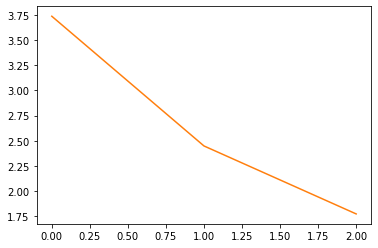

In [61]:
if runSeq2SeqRelationModel:
    if not isTest:
        lossCurve=[]
        for epoch in range(epochs):
            for iteration in range(itersInEachEpoch):
                try:
                    inputs, labels=V3iter.__next__()
                except StopIteration:
                    V3iter=iter(datasetV3Loader)
                    inputs, labels=V3iter.__next__()
                inputs=fromObjectsToRelationPairsBatchAndTimestepVersion(inputs)
                labels=labels.permute(0,1,3,2)
                if useGpu:
                    inputs=Variable(inputs.cuda())
                    labels=Variable(labels.cuda())
                optim.zero_grad()
                logging.info('forward stated')
                outputs=relationLSTMSeq2SeqModel(inputs)
                logging.info('forward finished')
                logging.debug(fromAllToStr('compare the shape of outputs and labels:',outputs.shape, labels.shape))
                loss=lossFn(outputs,labels)
                lossCurve.append(loss)
                logging.info('backward started')
                loss.backward()
                logging.info('backward finished')
                optim.step()
                logging.info(fromAllToStr('loss in opoch ',epoch,',iteration',iteration,':',loss))
                if(iteration%10==0):
                    plt.plot(lossCurve)
                    plt.savefig(fromAllToStr('.\positionOnly\lossCurve epoch ',epoch+1000000, ' iteration ',iteration+10000000,'.jpg'))
            lrSchedule.step()
            if epoch%2==0:
                torch.save(relationLSTMSeq2SeqModel.state_dict(),\
                           '.\positionOnly\relationLSTMSeq2SeqMode_in_epoch_weightedLossAndPositionOnly_'+str(epoch+10000)+'.pt')
                

# testing seq2seqRelation model

In [ ]:
datasetV3Loader=DataLoader(datasetV3Instance,batch_size=2,num_workers=4)
V3iter=iter(datasetV3Loader)

In [ ]:
if runSeq2SeqRelationModel:
    if isTest:
        relationLSTMSeq2SeqModel.eval()
        with torch.no_grad():
            relationLSTMSeq2SeqModel.load_state_dict(torch.load('relationLSTMSeq2SeqMode_in_epoch_weightedLossAndPositionOnly_10008.pt'))
    #         inputs,labels=V3iter.__next__()
            itemIndex=5838
            inputs,labels=datasetV3Instance.__getitem__(itemIndex)
            inputs=inputs.unsqueeze(0)
            labels=labels.unsqueeze(0)
            for ii in range(4):
                newInput, newLabel=datasetV3Instance.__getitem__(itemIndex+ii)
                newInput=newInput.unsqueeze(0)
                newLabel=newLabel.unsqueeze(0)
                inputs=torch.cat((inputs,newInput),0)
                labels=torch.cat((labels,newLabel),0)

            print(inputs.shape,labels.shape)

            inputs=fromObjectsToRelationPairsBatchAndTimestepVersion(inputs)
            print(inputs.shape)
            labels=labels.permute(0,1,3,2)
            outputs=relationLSTMSeq2SeqModel(inputs)
            print(outputs.shape)
            normalizationDict=datasetV3Instance.getNormalizationDict()
            for i in range(labels.shape[1]):
                resultImage=visualizeTensorData(outputs[0,i,:,0],outputs[0,i,:,1],normalizationDict=normalizationDict)
                fileName='./predictWithRelationSeq2Seq/'+str(i)+'.png'
                cv2.imwrite(fileName,resultImage)
                resultImage=visualizeTensorData(labels[0,i,:,0],labels[0,i,:,1],normalizationDict=normalizationDict)
                fileName='./predictWithRelationSeq2Seq/'+'l'+str(i)+'.png'
                cv2.imwrite(fileName,resultImage)



In [ ]:
if runSeq2SeqRelationModel:
    if isTest:
        vehicleListHalf=[]
        for i in range(0,250,2):
            vehicleListHalf.append(i)
        trajectoryImage=visualizeTrajectory(outputs,normalizationDict=normalizationDict,radius=3,vehicleList=vehicleListHalf)
        cv2.imwrite('trajectoryImage.jpg',trajectoryImage[0]) 
        differenceEachVehicleEachFrame,differenceEachVehicleAllFrame,averageDifferenceAllVehicleEachFrame,\
        averageDifferenceAllVehicleAllFrame=numericalEvaluation(outputs,labels) 
        logging.debug(fromAllToStr(averageDifferenceAllVehicleAllFrame.shape))
        logging.debug(fromAllToStr(averageDifferenceAllVehicleAllFrame))

# test lstm relation model

In [ ]:
print('start test lstm relation model')
if runRelationLSTM:
    datasetV3Instance=tensorsDatasetV3(trajectoryFileList)
    datasetV3Loader=DataLoader(datasetV3Instance,batch_size=2)
    V3iter=iter(datasetV3Loader)
    relationLSTMInstance=RelationLSTM()
    if useGpu:
        relationLSTMInstance.cuda()

%matplotlib inline
def calculateXandN(x,n):
    return (1+x)/(n+1+2*x)
ns=[]
xs=[]
for i in range(0,100):
    xs.append(i)
for i in range(0,10):
    ns.append(i)
lines=[]
for i in range(20):
    lines.append([])
for x in xs:
    for n in ns:
        lines[n].append(calculateXandN(x,n))
plt.figure(figsize=(20,20))
plt.subplot(241)
plt.plot(xs,lines[0],'b')
plt.plot(xs,lines[1],'g')
plt.plot(xs,lines[2],'k')
plt.plot(xs,lines[3],'y')
plt.plot(xs,lines[4],'m')
plt.plot(xs,lines[5],'-')
plt.subplot(242)
plt.plot(ns,lines[0],'b')
plt.subplot(243)
plt.plot(ns,lines[1],'b')
plt.subplot(244)
plt.plot(ns,lines[2],'b')
plt.subplot(245)
plt.plot(ns,lines[3],'b')
plt.subplot(246)
plt.plot(ns,lines[4],'b')
plt.subplot(247)
plt.plot(ns,lines[5],'b')

In [ ]:
#training relation lstm
if runRelationLSTM:
    if not isTest:
        learningRate=1e-3
        MSELoss=nn.MSELoss()
        lambdaWholeNet=lambda epoch: 0.5**(epoch//30)
        optim=torch.optim.RMSprop([{'params':relationLSTMInstance.parameters(),'initial_lr':learningRate}],lr=learningRate)
        lrSchedule=torch.optim.lr_scheduler.LambdaLR(optim,lambdaWholeNet,last_epoch=10)
        relationLSTMInstance.train()

In [ ]:
if runRelationLSTM:
    #training relation lstm
    if not runOnG814:
        %matplotlib inline
    from IPython.display import clear_output
    normalizationDict=datasetV3Instance.getNormalizationDict()
    optim.zero_grad()
    if not isTest:  
        losses=[]
        iterInEpoch=50
        for epoch in range(5):
            print(epoch)
            i=0
            for inputs,label in V3iter:
                i=i+1
                if i>iterInEpoch*(epoch+1):
                    break
        #         print(i)
                inputs=fromObjectsToRelationPairsBatchAndTimestepVersion(inputs)
                print('label.shape',label.shape)
                label=label[:,0,:,:].squeeze()
                label=label.permute(0,2,1)
#                 label=label[:,tupleForEachVehicle,0:6]
                if useGpu:
                    inputs=Variable(inputs.cuda())
                    label=Variable(label.cuda())
                output=relationLSTMInstance(inputs)

        #         print(output[0,0:10,:],secondObjects[0,0:10,:])
                print('output.shape',output.shape)
                loss=MSELoss(output,label)
                if i<5:
                    print('epoch ',epoch, ' i', i,' loss',loss)
        #         print(loss)
                losses.append(loss.item())
                optim.zero_grad()
                loss.backward()
                optim.step()
    #             outputView=output.reshape((7,6,250)).cpu()
    #             for j in range(10):
    #                 inputs=inputs.cpu()
    #                 resultImage=visualizeTensorData(inputs[0,j,0,:],inputs[0,j,1,:],normalizationDict=normalizationDict)
    #                 fileName='./predictWithRelationLSTM/'+str((epoch+1)*10000000+i*100000+j)+'.png'
    #                 cv2.imwrite(fileName,resultImage)
    #             resultImage=visualizeTensorData(outputView[0,0,:],outputView[0,1,:],normalizationDict=normalizationDict)
    #             fileName='./predictWithLSTMOnly/'+str((epoch+1)*10000000+i*100000+50)+'.png' #the predicted image is named with string which last two number is 50(because j < 50)
    #             cv2.imwrite(fileName,resultImage)
            lrSchedule.step()
        plt.figure(figsize=(30,30))
        plt.plot(losses)
        plt.savefig('./losses.png')
        torch.save(relationLSTMInstance.state_dict(),'./relationLSTM.pt')

# test relation-object model over a period of time

In [ ]:
if runObjectRelationNet:
    normalizationDict=datasetV2.getNormalizationDict()

    datas=[]
    for i in range(0,6):
        break
        datas.append([])
    for ii in range(0,2000):
        break
        theInput,second=datasetV2.__getitem__(ii)
        theInput=theInput.unsqueeze(0)
        second=second.unsqueeze(0)
        #         print(i)
        #         theInput,second=item
        if useGpu:
            theInput=Variable(theInput.cuda())
            second=Variable(second.cuda())
        inputObjects=theInput[:,tupleForEachVehicle,0:6]
        secondObjects=second[:,tupleForEachVehicle,0:6]
        for i in range(0,6):
            datas[i].append(inputObjects[0,0,i])
    #     print('inputObjects.shape',inputObjects.shape)
    #     resultImage=visualizeTensorData(inputObjects[0,:,0].cpu(),inputObjects[0,:,1].cpu(),normalizationDict=normalizationDict)
    #     fileName='./resultImage/'+str(ii)+'.png'
    #     cv2.imwrite(fileName,resultImage)
    timeStamp=int(time.time())
    dirName='resultImage'+str(timeStamp)
    os.mkdir(dirName)
    if isTest:
        with torch.no_grad():
            wholeNet.eval()
            theInput,second=datasetV2.__getitem__(5000)
            theInput=theInput.unsqueeze(0)
            second=second.unsqueeze(0)
        #         print(i)
    #         theInput,second=item
            if useGpu:
                theInput=Variable(theInput.cuda())
                second=Variable(second.cuda())
            inputObjects=theInput[:,tupleForEachVehicle,0:6]
            secondObjects=second[:,tupleForEachVehicle,0:6]
            print('inputObjects.shape',inputObjects.shape)
            resultImage=visualizeTensorData(inputObjects[0,:,0].cpu(),inputObjects[0,:,1].cpu(),normalizationDict=normalizationDict)
            fileName='./resultImage/'+'0000000000000000'+'.png'
            cv2.imwrite(fileName,resultImage)
            stepInput=fromObjectsToRelationPairs(inputObjects[0].permute(1,0)).unsqueeze(0)
        #             output=wholeNet(theInput)
            print(stepInput.shape)
        #             print(output.shape)
            #predict step by step
            for step in range(500):
                output=wholeNet(stepInput)
                print('step: ',step)
                for ii in range(output.shape[1]):
                    print(output[0,ii])
    #             break
    #             for j in range(10):
    #                 print(stepInput[:,tupleForEachVehicle,0:6][0,j,:])
    #                 print(output[0,j,:])
    #                 print()
                stepInput=fromObjectsToRelationPairs(output[0].permute(1,0)).unsqueeze(0)
    #             print('outputShape',output.shape)
    #             print('outputshape[0]',output[0].shape)
                resultImage=visualizeTensorData(output[0,:,0].cpu(),output[0,:,1].cpu(),normalizationDict=normalizationDict)

                import os
                fileName='./'+dirName+'/'+str(1000000+step)+'.png'
                cv2.imwrite(fileName,resultImage)

# training and testing process for 'fromRelationToObjectnetwork'

In [ ]:
if runObjectRelationNet:
    #generate a tuple in which each element is the index of a vehicle
    #the tuple is used to get the property of each vehicle from the left side of data from the dataset function
    listForEachVehicle=[]
    for i in range(maxMatrixIndex):
        listForEachVehicle.append(i*(maxMatrixIndex-1))
    tupleForEachVehicle=tuple(listForEachVehicle)

    dataloaderV2=DataLoader(datasetV2,batch_size=1,shuffle=True)


    wholeNet=fromRelationToObjectNetwork()
    if isTest:
        wholeNet.load_state_dict(torch.load(modelPath))


    if useGpu:
        wholeNet.cuda()



In [ ]:
if runObjectRelationNet:
    if not isTest:
        learningRate=1e-3
        MSELoss=nn.MSELoss()
        lambdaWholeNet=lambda epoch: 0.5**(epoch//30)
        optim=torch.optim.RMSprop([{'params':wholeNet.parameters(),'initial_lr':learningRate}],lr=learningRate)
        lrSchedule=torch.optim.lr_scheduler.LambdaLR(optim,lambdaWholeNet,last_epoch=10)
        wholeNet.train()

In [ ]:
if runObjectRelationNet:
    if not runOnG814:
        %matplotlib inline
    from IPython.display import clear_output
    if not isTest:  
        losses=[]
        iterInEpoch=50
        for epoch in range(300):
            print(epoch)
            for i,item in enumerate(dataloaderV2):
                if i>iterInEpoch:
                    break
        #         print(i)
                theInput,second=item
                if useGpu:
                    theInput=Variable(theInput.cuda())
                    second=Variable(second.cuda())
                secondObjects=second[:,tupleForEachVehicle,0:6]

                output=wholeNet(theInput)
        #         print(output[0,0:10,:],secondObjects[0,0:10,:])
                loss=MSELoss(output,secondObjects)
                if i<5:
                    print('epoch ',epoch, ' i', i,' loss',loss)
        #         print(loss)
                losses.append(loss.item())
                optim.zero_grad()
                loss.backward()
                optim.step()
            lrSchedule.step()
        plt.figure(figsize=(30,30))
        plt.plot(losses)
        plt.savefig('./losses.png')
        torch.save(wholeNet.state_dict(),'./wholeNet_300epoch_50perEpoch.pt')

# training simple LSTM module

In [ ]:
if runLSTM:
    #lstm version 
    if not isTest:
        learningRate=1e-3
        MSELoss=nn.MSELoss()
        lambdaWholeNet=lambda epoch: 0.5**(epoch//30)
        optim=torch.optim.RMSprop([{'params':lstmModel.parameters(),'initial_lr':learningRate}],lr=learningRate)
        lrSchedule=torch.optim.lr_scheduler.LambdaLR(optim,lambdaWholeNet,last_epoch=10)
        lstmModel.train()

In [ ]:
if runLSTM:
    #lstm version
    if not runOnG814:
        %matplotlib inline
    from IPython.display import clear_output
    normalizationDict=datasetV3.getNormalizationDict()
    if not isTest:  
        losses=[]
        iterInEpoch=50
        for epoch in range(5):
            print(epoch)
            i=0
            for inputs,label in iterV3:
                i=i+1
                if i>iterInEpoch*(epoch+1):
                    break
        #         print(i)
                if useGpu:
                    inputs=Variable(inputs.cuda())
                    label=Variable(label.cuda())
                output=lstmModel(inputs.reshape((inputs.shape[0],inputs.shape[1],-1)))

        #         print(output[0,0:10,:],secondObjects[0,0:10,:])
                loss=MSELoss(output,label.squeeze().reshape((label.shape[0],-1)))
                if i<5:
                    print('epoch ',epoch, ' i', i,' loss',loss)
        #         print(loss)
                losses.append(loss.item())
                optim.zero_grad()
                loss.backward()
                optim.step()
                outputView=output.reshape((7,6,250)).cpu()
                for j in range(10):
                    inputs=inputs.cpu()
                    resultImage=visualizeTensorData(inputs[0,j,0,:],inputs[0,j,1,:],normalizationDict=normalizationDict)
                    fileName='./predictWithLSTMOnly/'+str((epoch+1)*10000000+i*100000+j)+'.png'
                    cv2.imwrite(fileName,resultImage)
                resultImage=visualizeTensorData(outputView[0,0,:],outputView[0,1,:],normalizationDict=normalizationDict)
                fileName='./predictWithLSTMOnly/'+str((epoch+1)*10000000+i*100000+50)+'.png' #the predicted image is named with string which last two number is 50(because j < 50)
                cv2.imwrite(fileName,resultImage)
            lrSchedule.step()
        plt.figure(figsize=(30,30))
        plt.plot(losses)
        plt.savefig('./losses.png')
        torch.save(wholeNet.state_dict(),'./wholeNet_300epoch_50perEpoch.pt')

## 2020 9 20 22:45 going to leave:
dataset applying keeping-relation-pairs tested succesfully
to do: add keeping-relation-pairs to difference model

## 2020 9 20 17:56 coding...
function "relationComputationWorkerApplyingKeepRelationPairs" editing finished without test.
To applying the function above in dataset

## 2020 9 19 16:14 coding..
the test, which consisted of several test cases, of function "computeRelationAndAllTheOtherTensorsWithDistance" has been finished.
To add new multi-process procedure to dataset class. 

## 2020 9 18 21:57 leave
testing function "computeRelationAndAllTheOtherTensorsWithDistance"

## 2020 9 18 16:1 before coding:
test function "computeRelationAndAllTheOtherTensorsWithDistance" 
add new multi-thread operation into class "tensorsDatasetV4MultiThread_relationPairKeeping"


#draw properties of a single tensor over time
#output results step by step
plt.subplot(321)
plt.plot(datas[0])
plt.subplot(322)
plt.plot(datas[1])
plt.subplot(323)
plt.plot(datas[2])
plt.subplot(324)
plt.plot(datas[3])
plt.subplot(325)
plt.plot(datas[4])
plt.subplot(326)
plt.plot(datas[5])